In [2]:
import pandas as pd

from src.data.synthetic_anomalies.anomalies import NoiseMachine

import warnings
warnings.filterwarnings("ignore")

%load_ext autoreload
%autoreload 2

import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import IsolationForest
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler
from sklearn.inspection import DecisionBoundaryDisplay
from itertools import product



In [3]:
data = pd.read_parquet("data/cleaned_data/TL_all_data_without_duplicates.parquet")
data = data[data['robot'] == "7600-100498"]

In [4]:
def get_rand_sequence():
    rand_id = data["id"].sample(1).values[0]
    data_rand = data[data["id"] == rand_id]
    return data_rand

# Point Anomaly

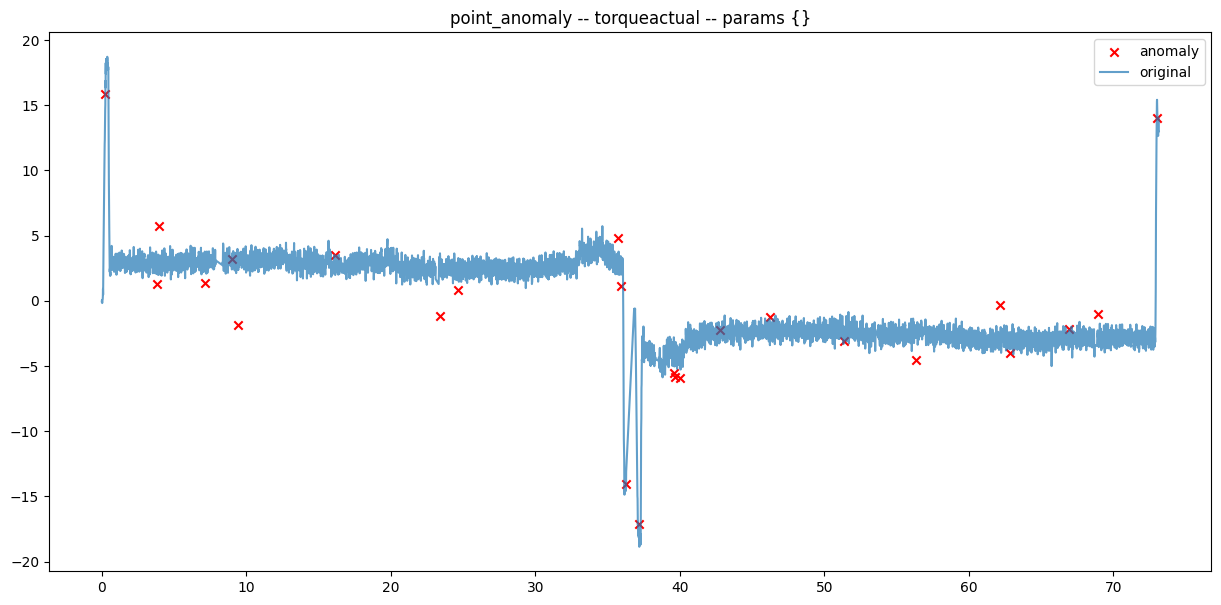

In [6]:
data_point = get_rand_sequence()

std = 2.0
num = 25

data_point = NoiseMachine.point_anomaly(data_point, num=num, std=std)

data_point['torquenoise'] = data_point['torqueactual'] + data_point['noise']
NoiseMachine.plot(data_point, column="torqueactual")

In [7]:
# Extract features for training
#features_point = data_point[['timeindex','torqueactual']].values
#features_point

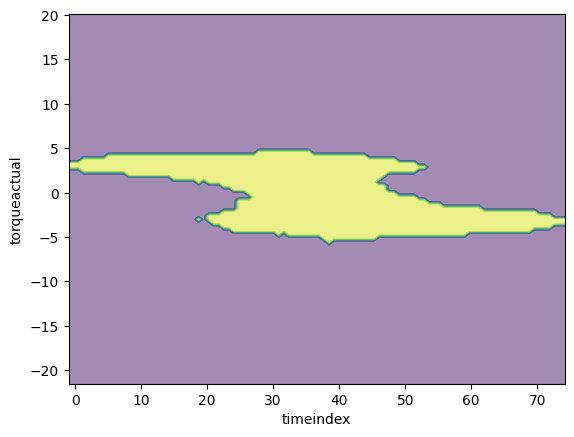

In [8]:
# Normalize the features
#scaler = StandardScaler()
#scaled_features_point = scaler.fit_transform(features_point)
#print(scaled_features_point)

# Train Isolation Forest on the normalized features
iso_forest = IsolationForest(n_estimators=500, contamination=0.05, random_state=42)
iso = iso_forest.fit(data[['timeindex','torqueactual']])

disp = DecisionBoundaryDisplay.from_estimator(
    iso,
    data[['timeindex','torqueactual']],
    response_method="predict",
    alpha=0.5,
)


In [127]:
data_point['outlier'] = iso.predict(data_point[['timeindex','torquenoise']].values)

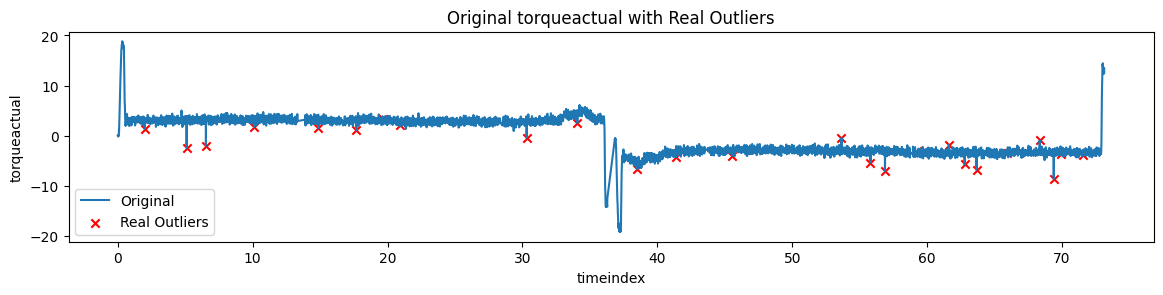

In [128]:
real_anomalies_point = data_point[data_point['noise'] != 0]

# Plotting torqueactual against timeindex
plt.figure(figsize=(14, 6))

# Plot original torqueactual with real anomalies
plt.subplot(2, 1, 1)
plt.plot(data_point['timeindex'], data_point['torquenoise'], label='Original')
plt.scatter(real_anomalies_point['timeindex'], real_anomalies_point['torqueactual'] + real_anomalies_point['noise'], 
            c='red', label='Real Outliers', marker='x')
plt.xlabel('timeindex')
plt.ylabel('torqueactual')
plt.title('Original torqueactual with Real Outliers')
plt.legend()

# Separate inliers and outliers for plotting
outliers = data_point[data_point['outlier'] == -1]



<Figure size 1400x600 with 0 Axes>

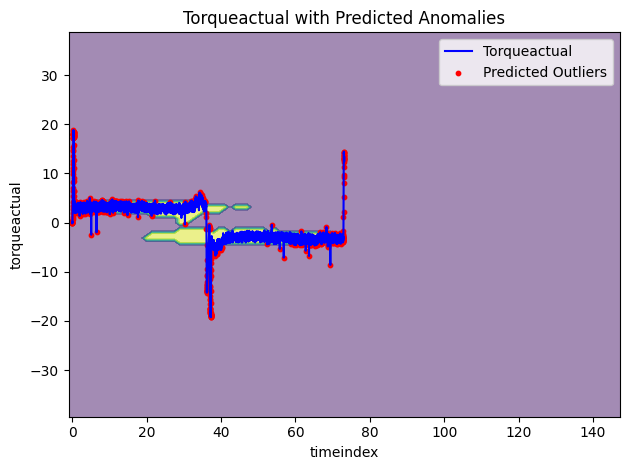

In [129]:

# Highlighting detected anomalies in torqueactual
plt.figure(figsize=(14, 6))
disp = DecisionBoundaryDisplay.from_estimator(
    iso,
    data_point[['timeindex','torqueactual']].values + data_point[['timeindex','torquenoise']].values,
    response_method="predict",
    alpha=0.5,
)
plt.plot(data_point['timeindex'], data_point['torquenoise'], label='Torqueactual', color='blue')
plt.scatter(outliers['timeindex'], outliers['torquenoise'], color='red', s=10, label='Predicted Outliers')
plt.title('Torqueactual with Predicted Anomalies')
plt.xlabel('timeindex')
plt.ylabel('torqueactual')
plt.legend()

plt.tight_layout()
plt.show()

In [12]:
# Define scalers
scalers = [StandardScaler(), MinMaxScaler(), RobustScaler()]

# Define parameters for Isolation Forest
params = {
    'n_estimators': [100, 200, 500],
    'contamination': [0.01, 0.02, 0.05],
    'random_state': [42]
}

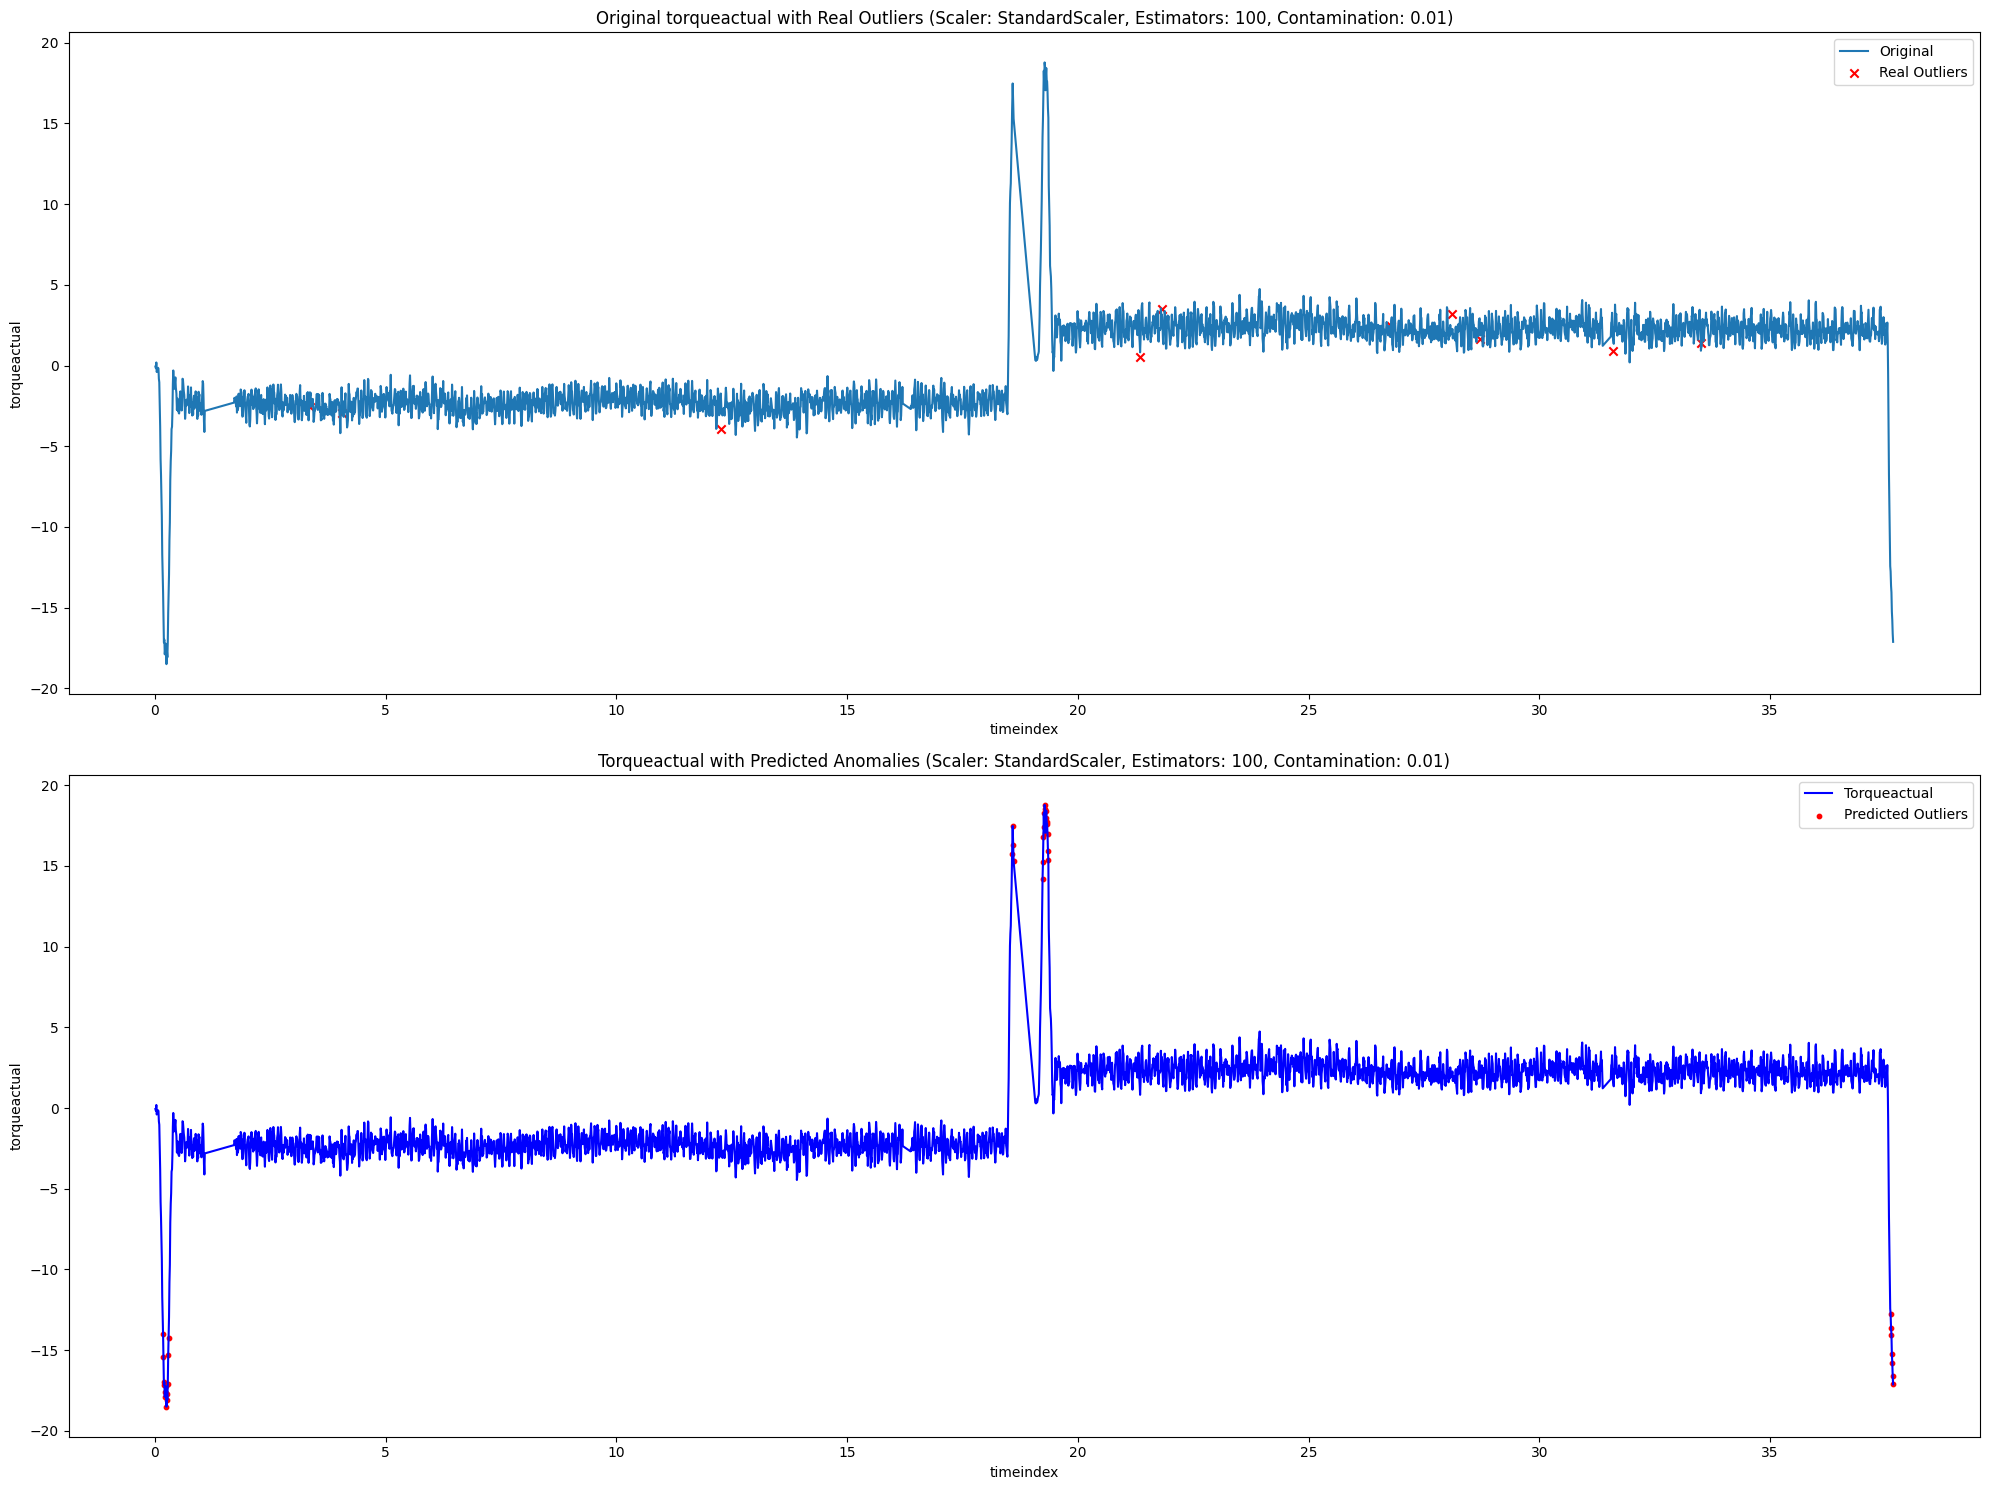

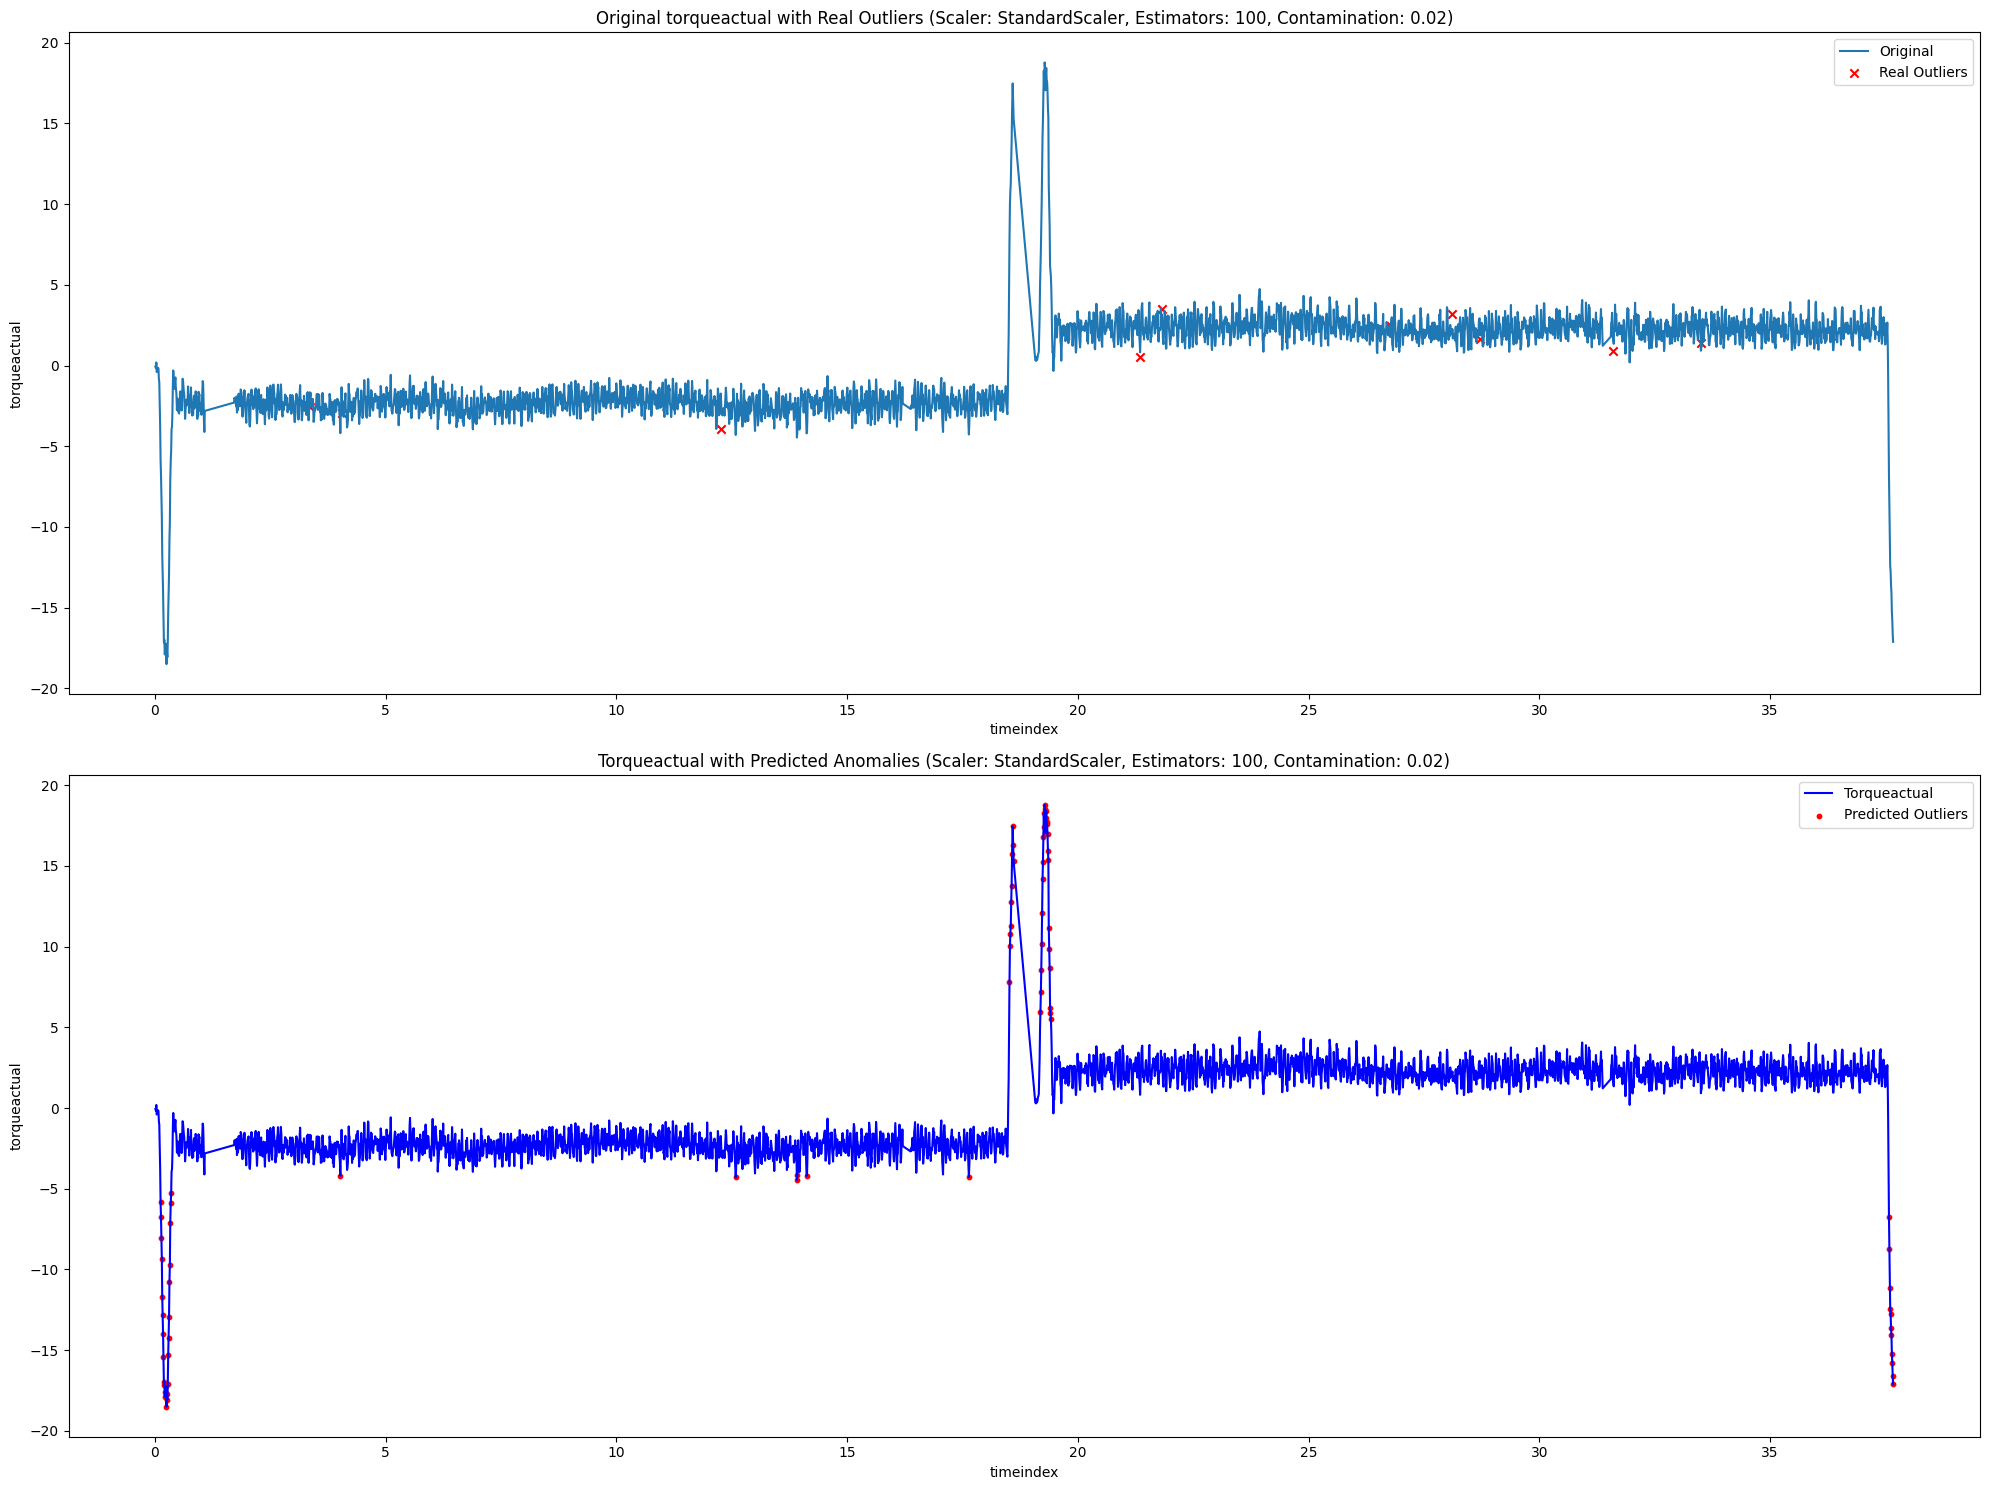

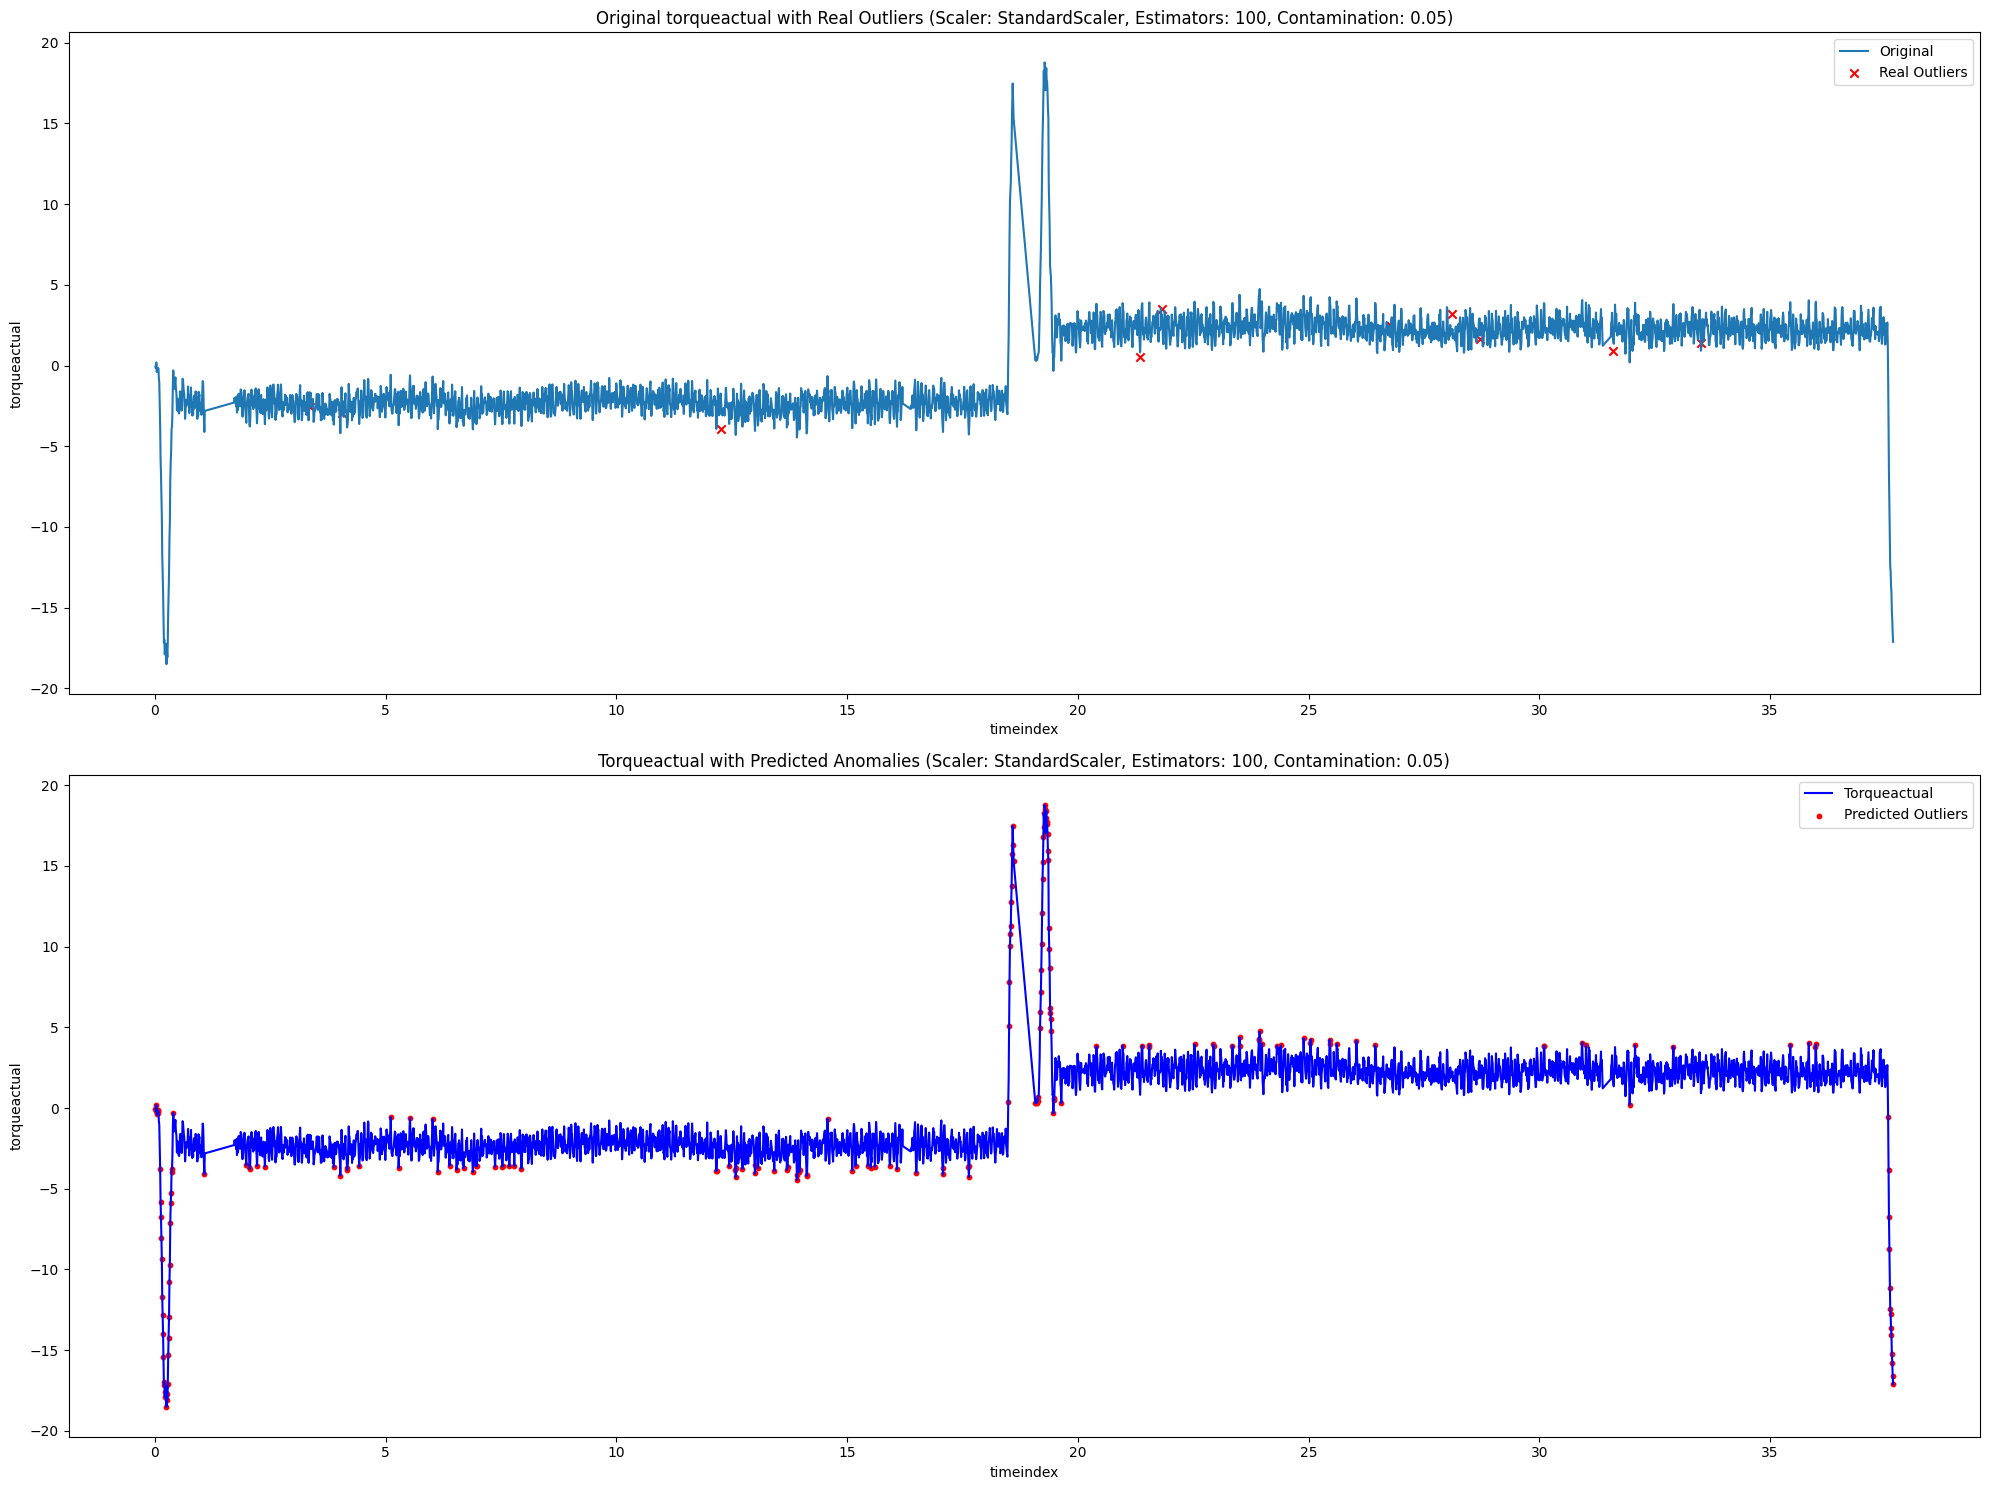

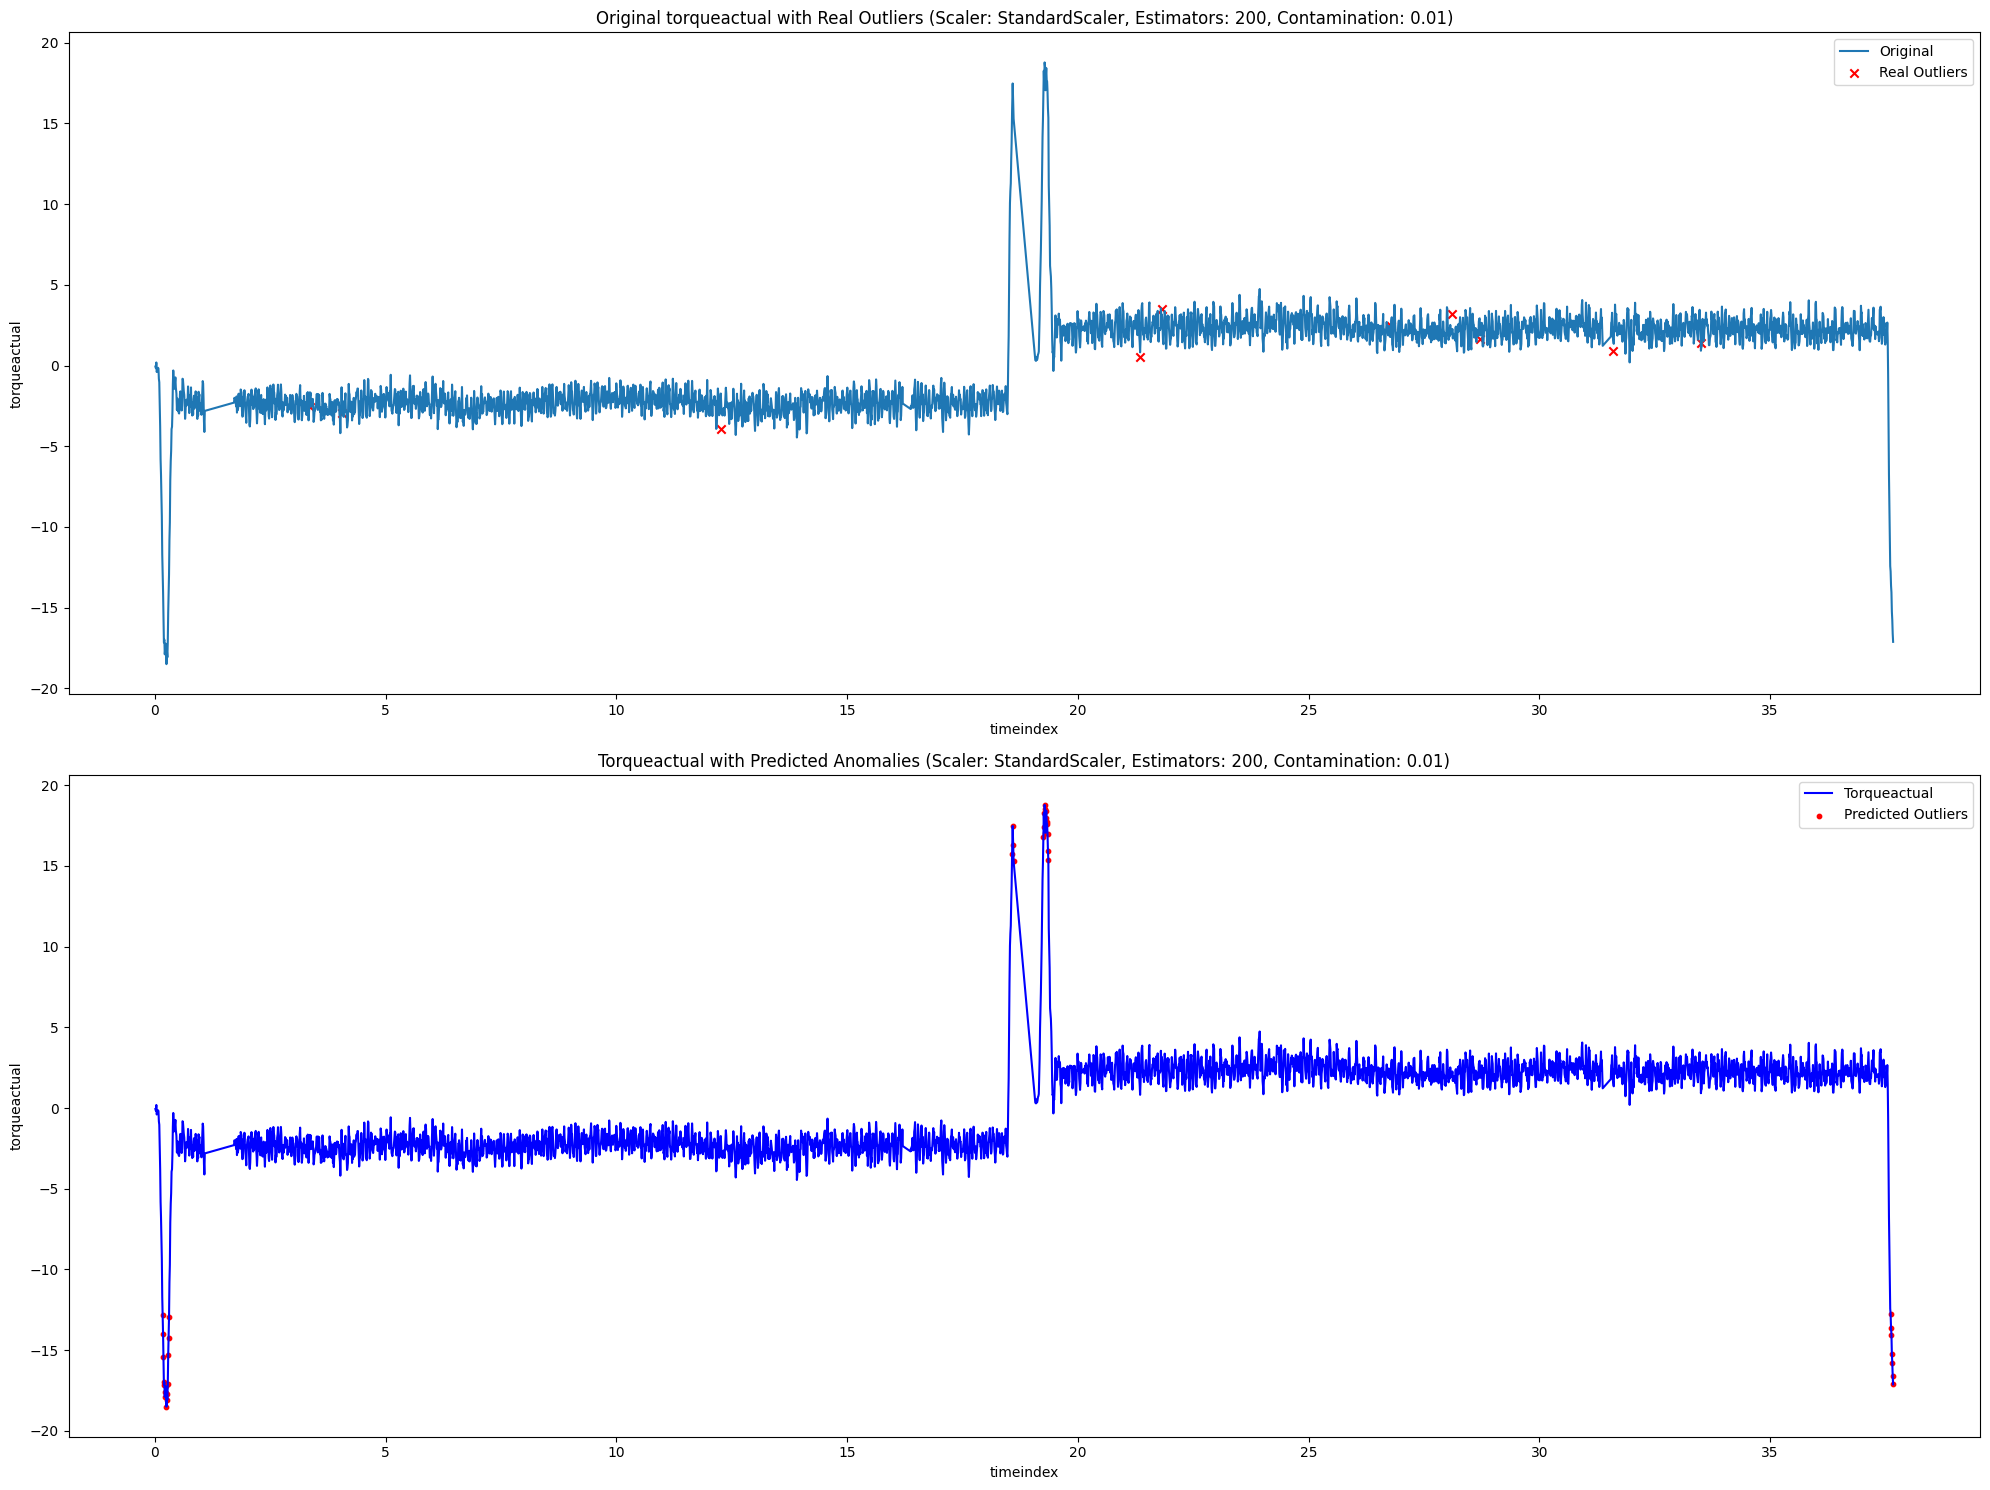

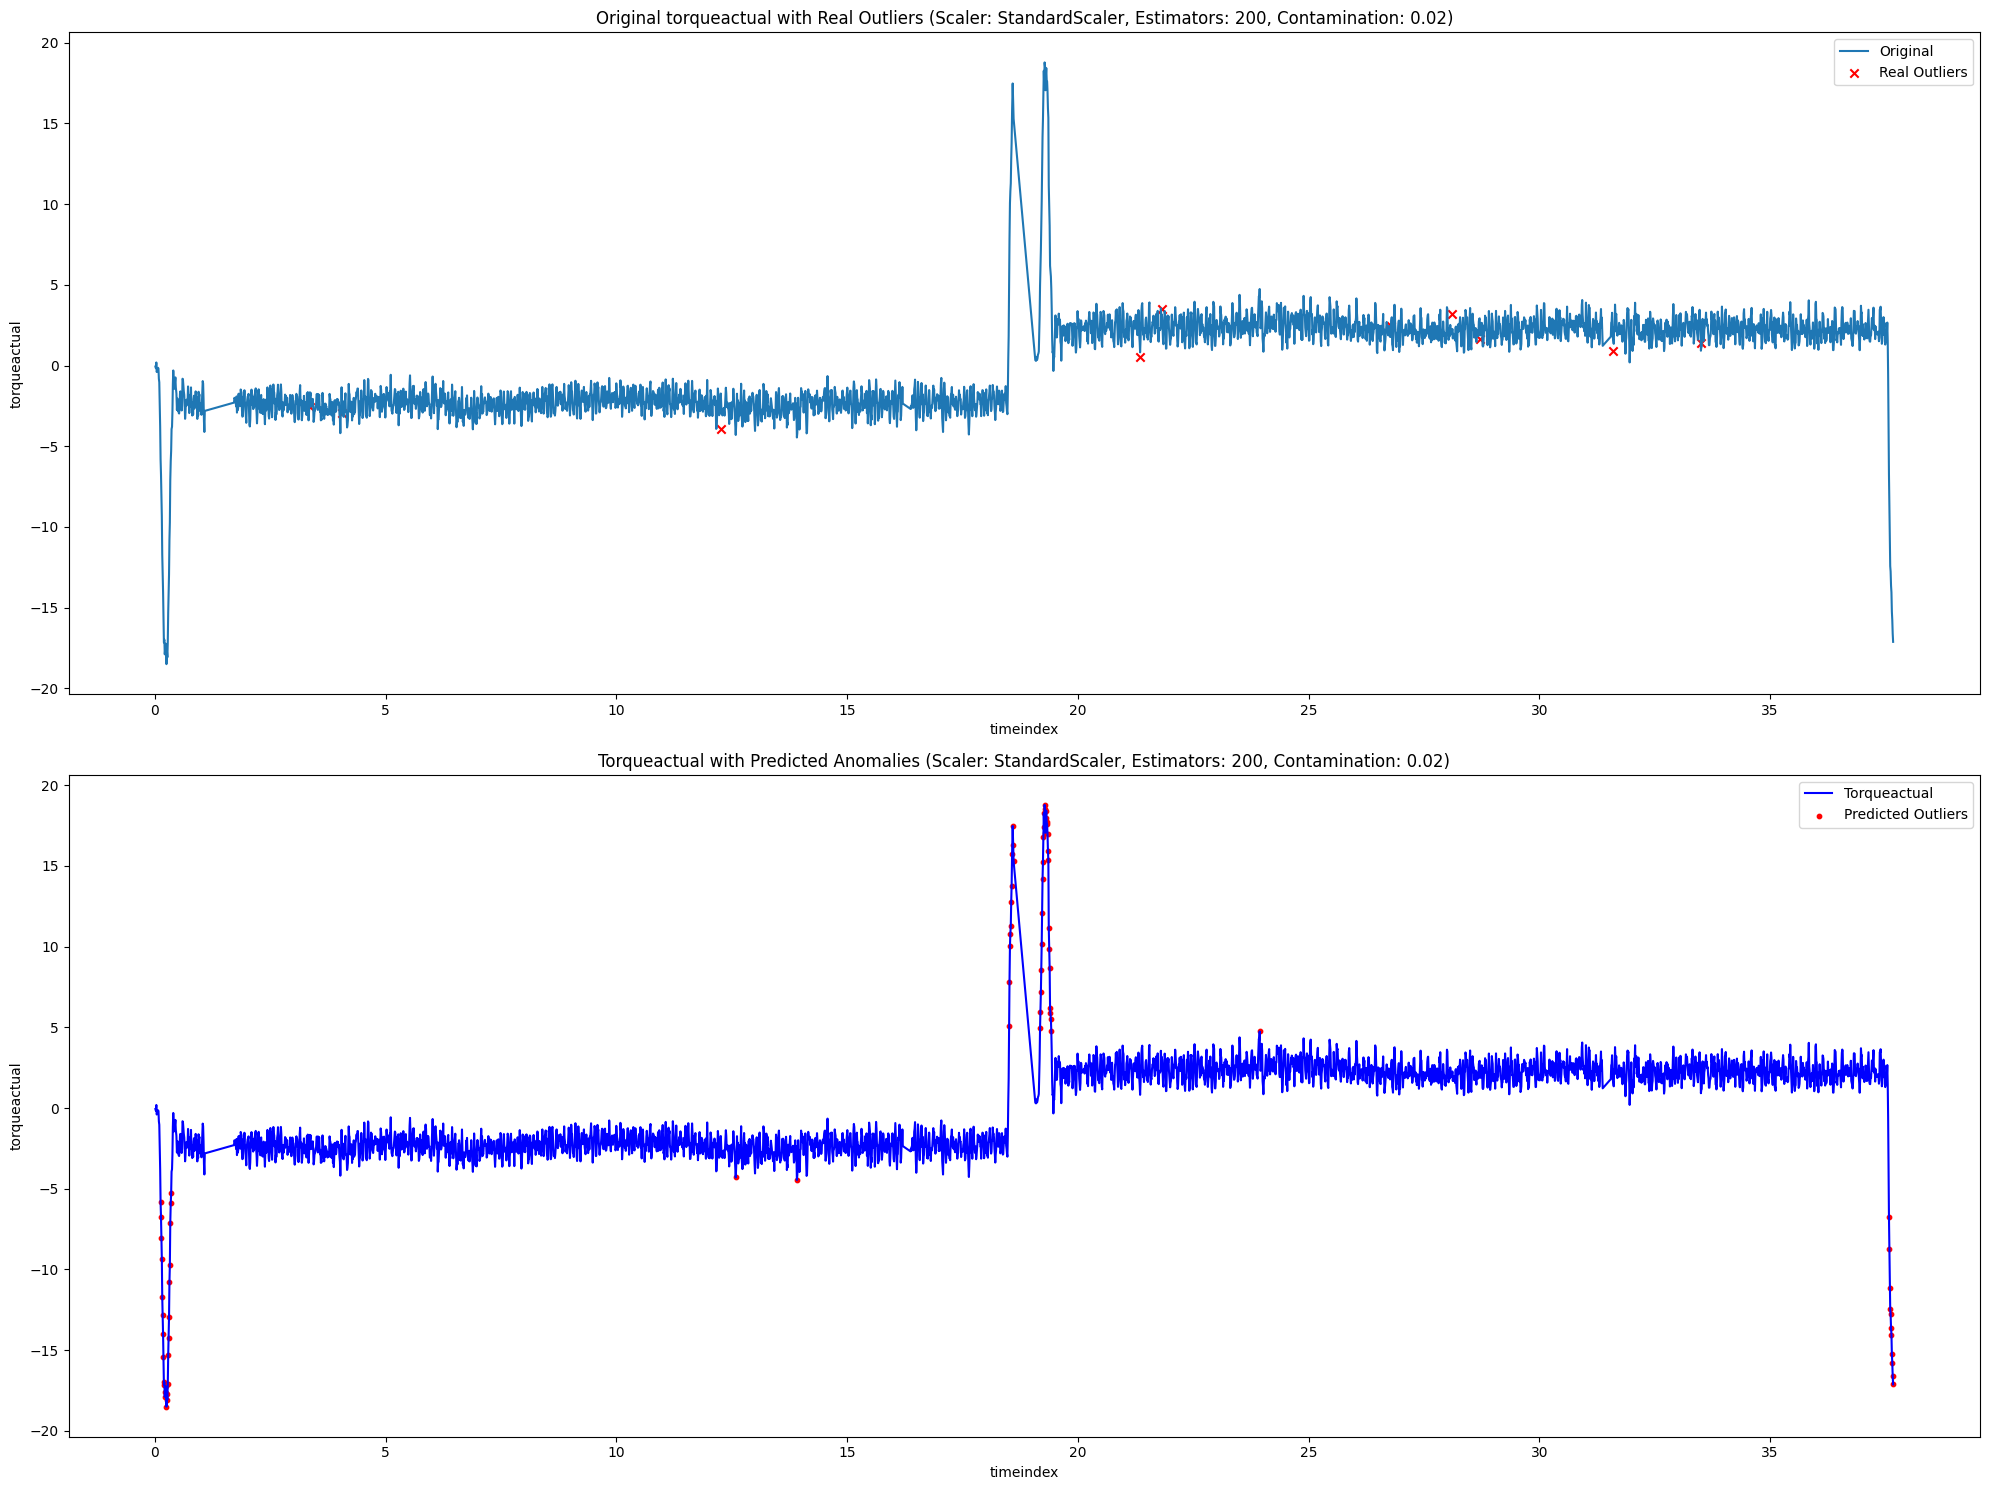

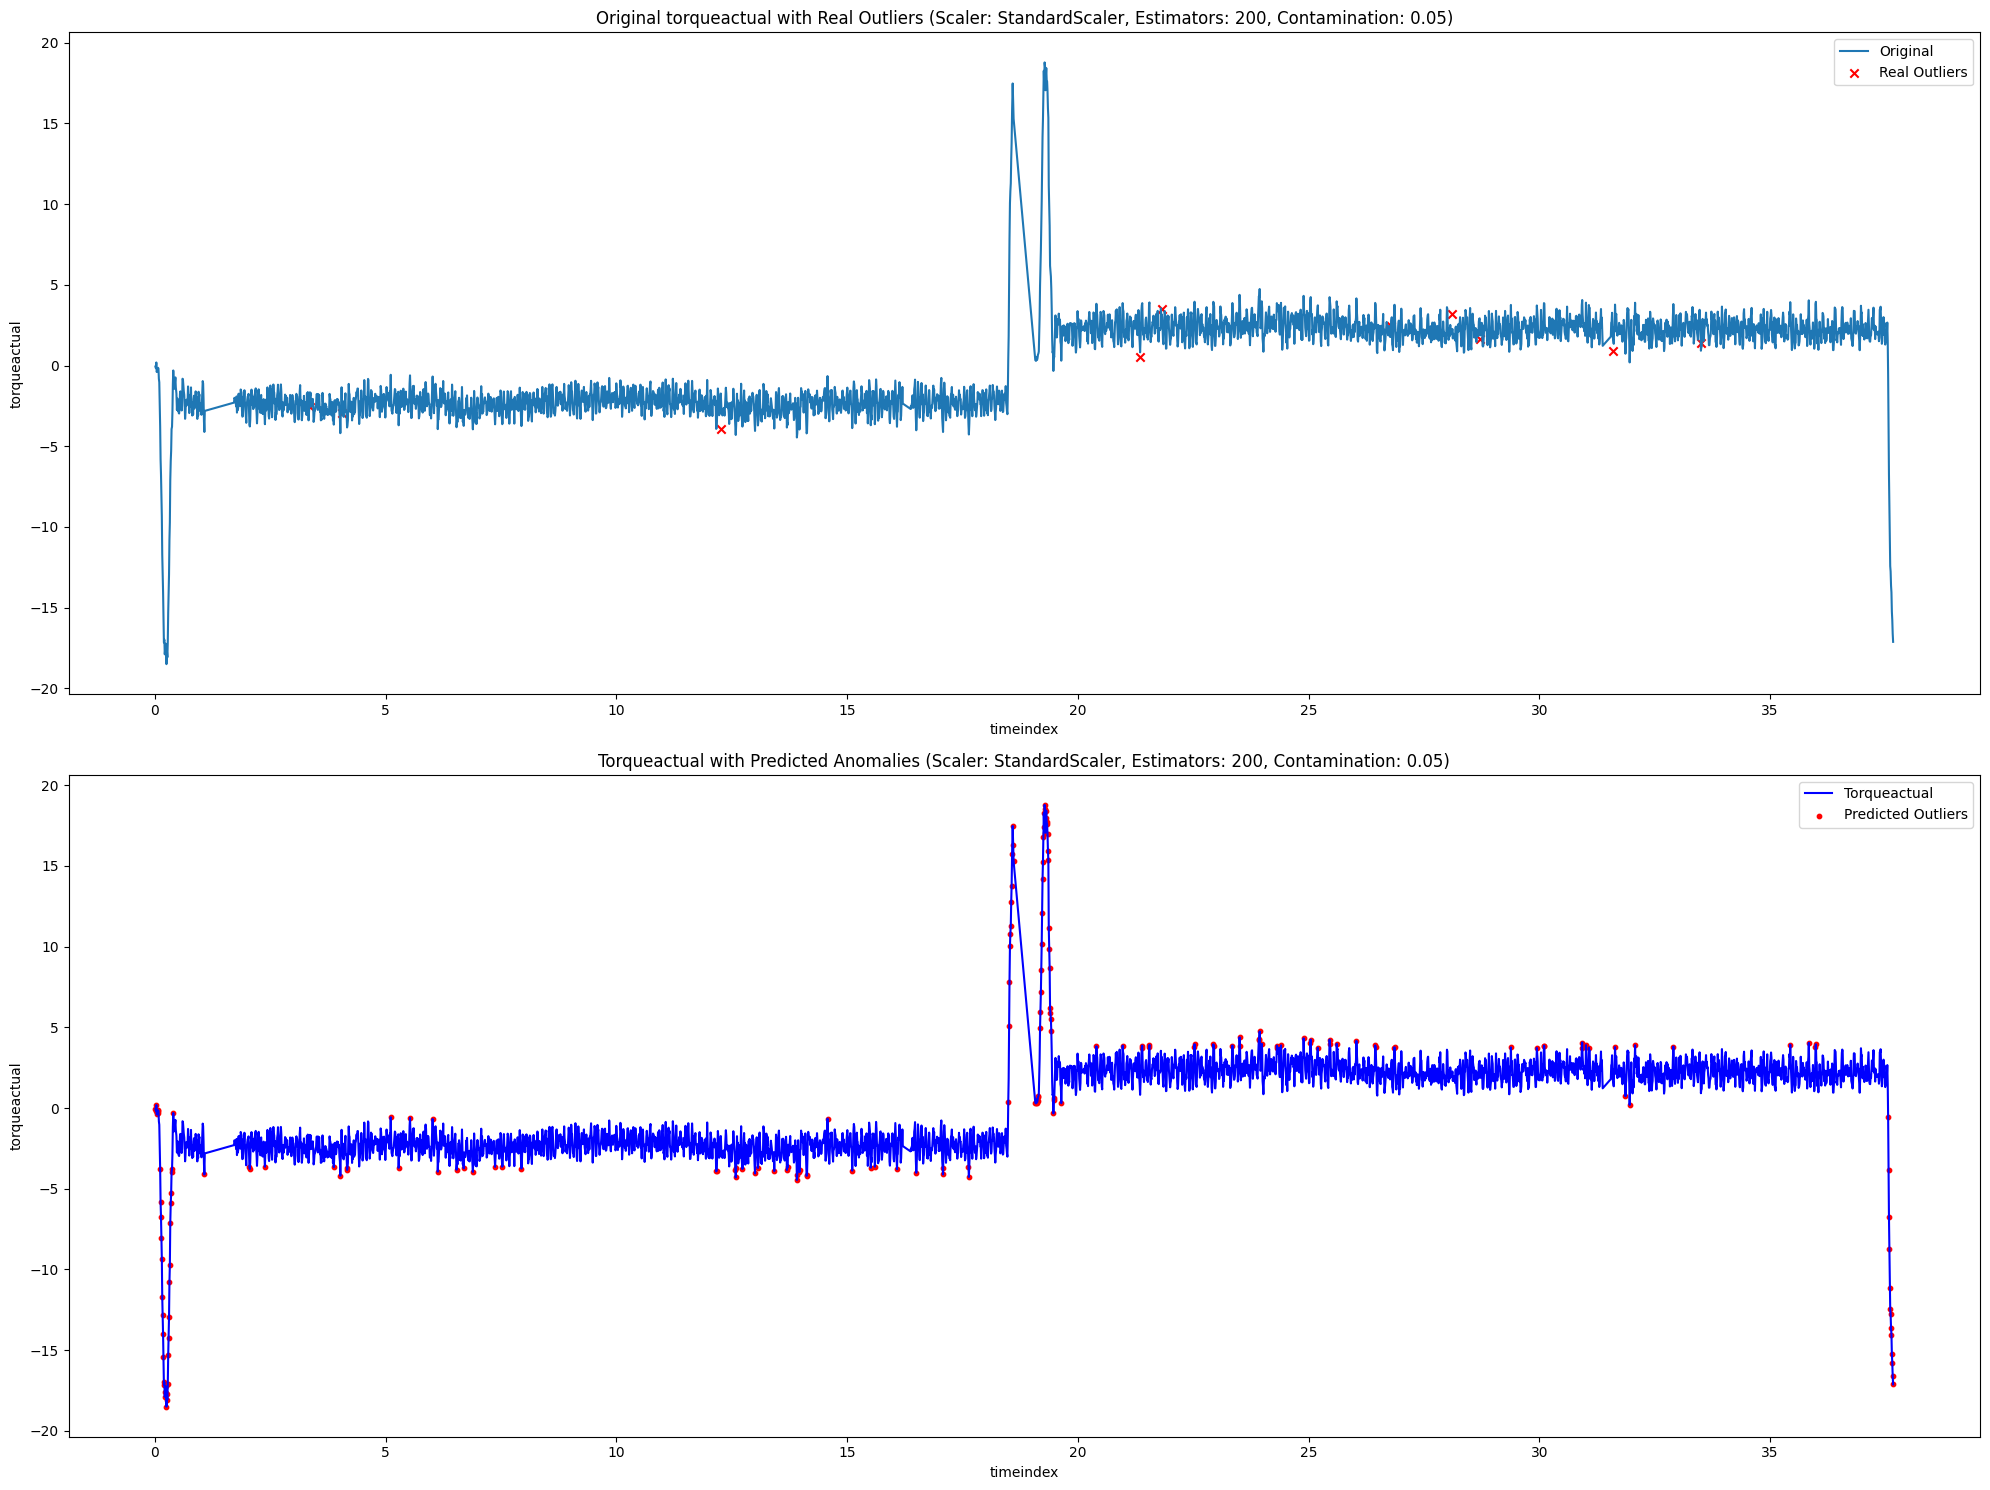

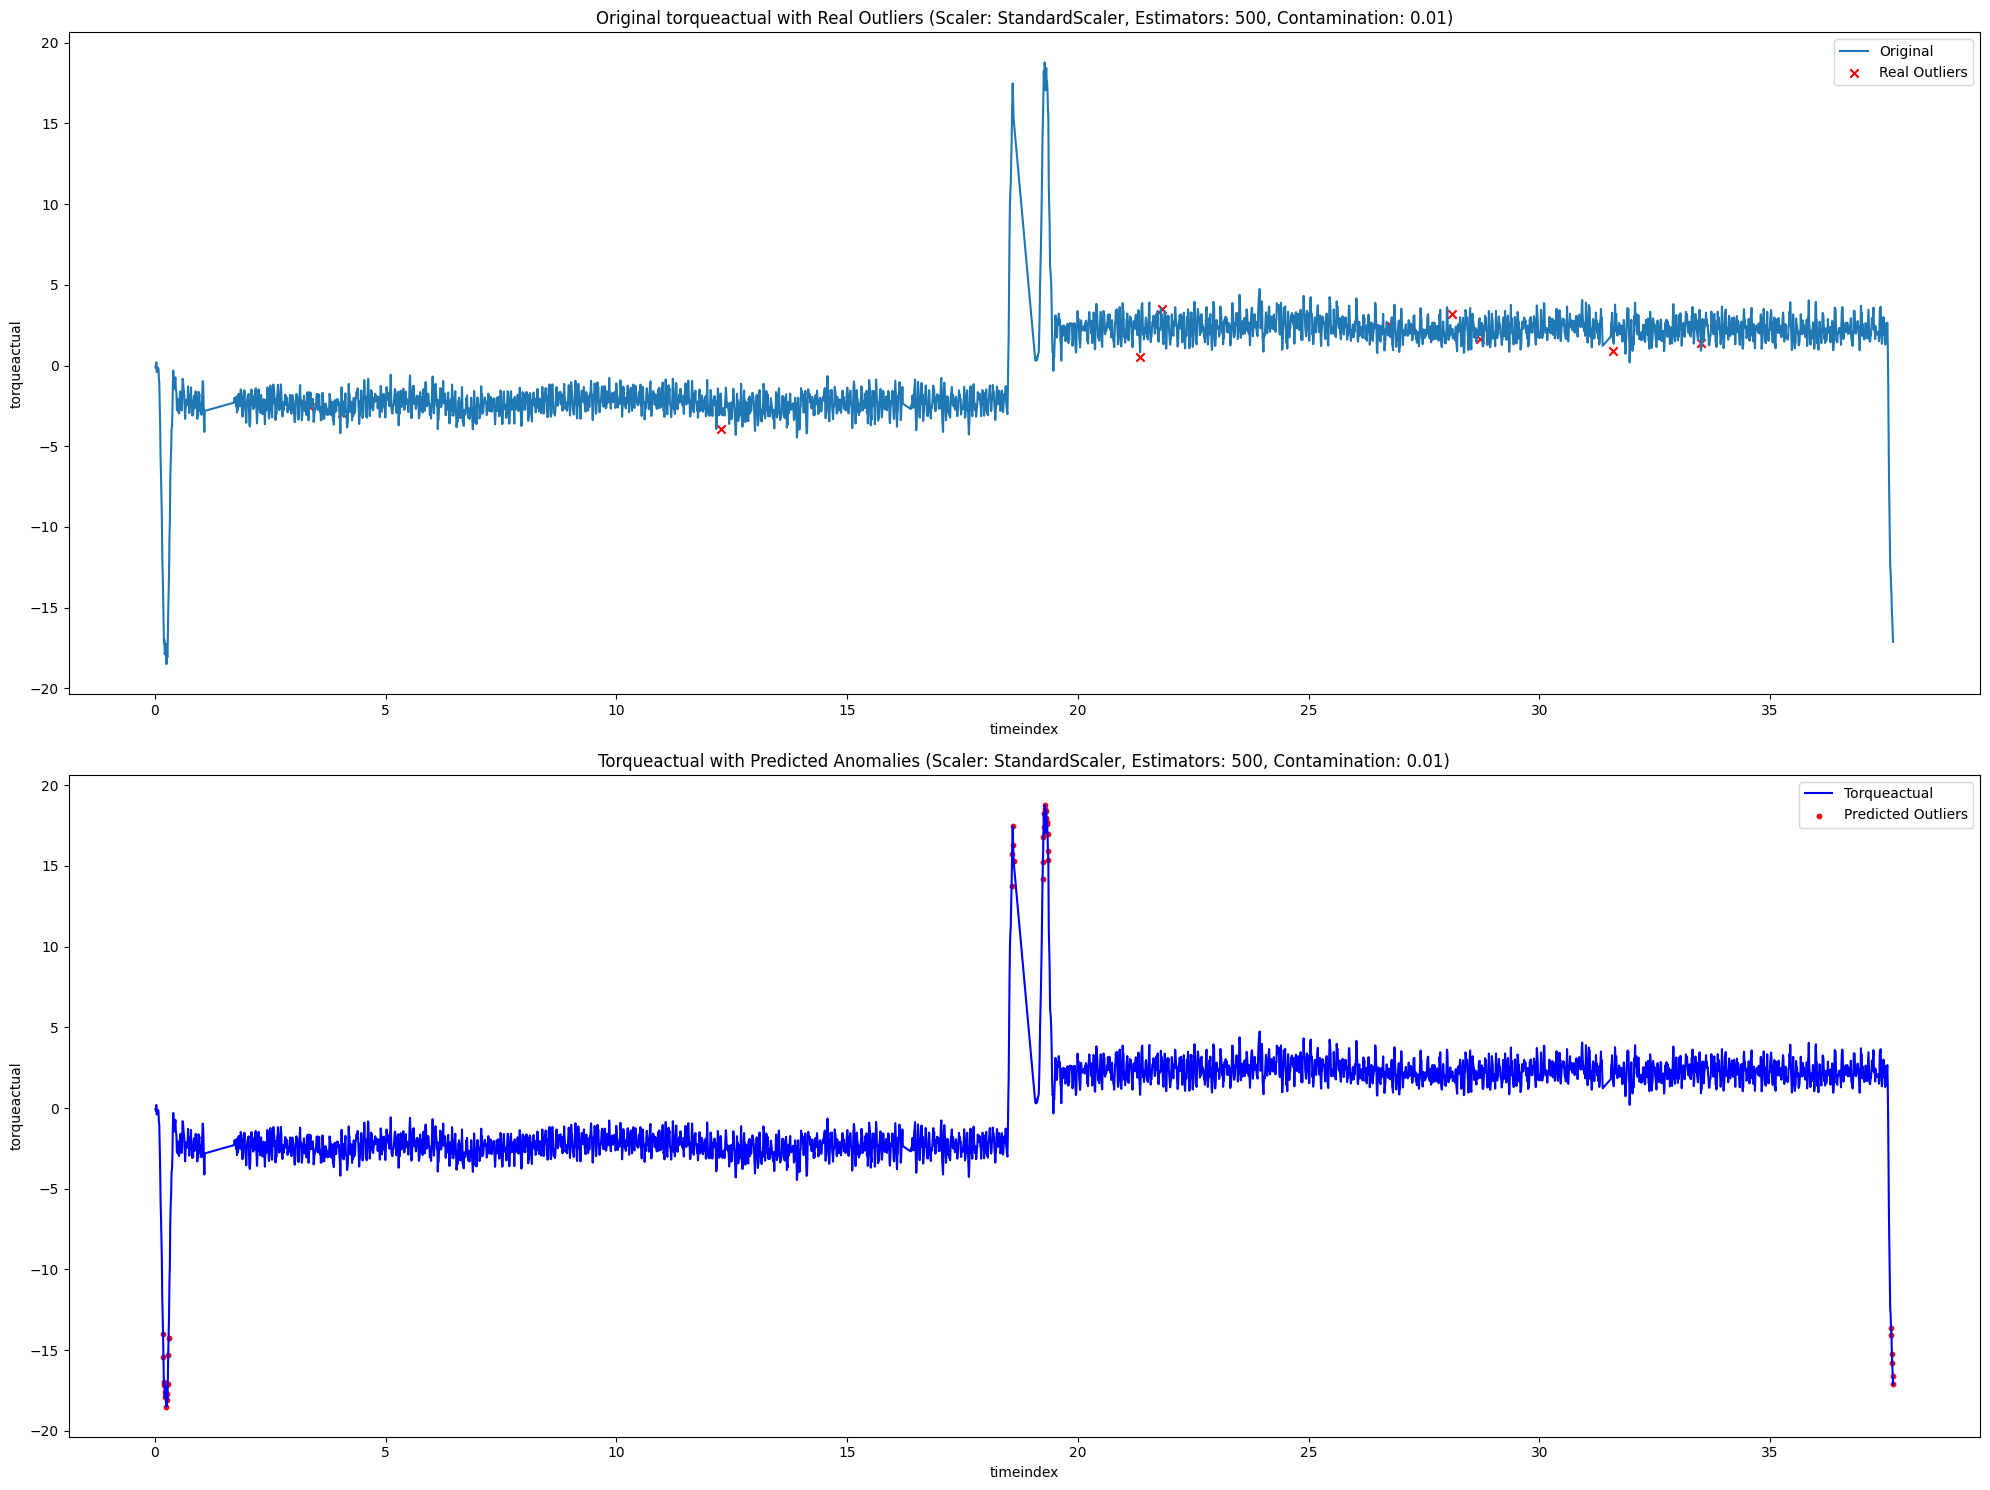

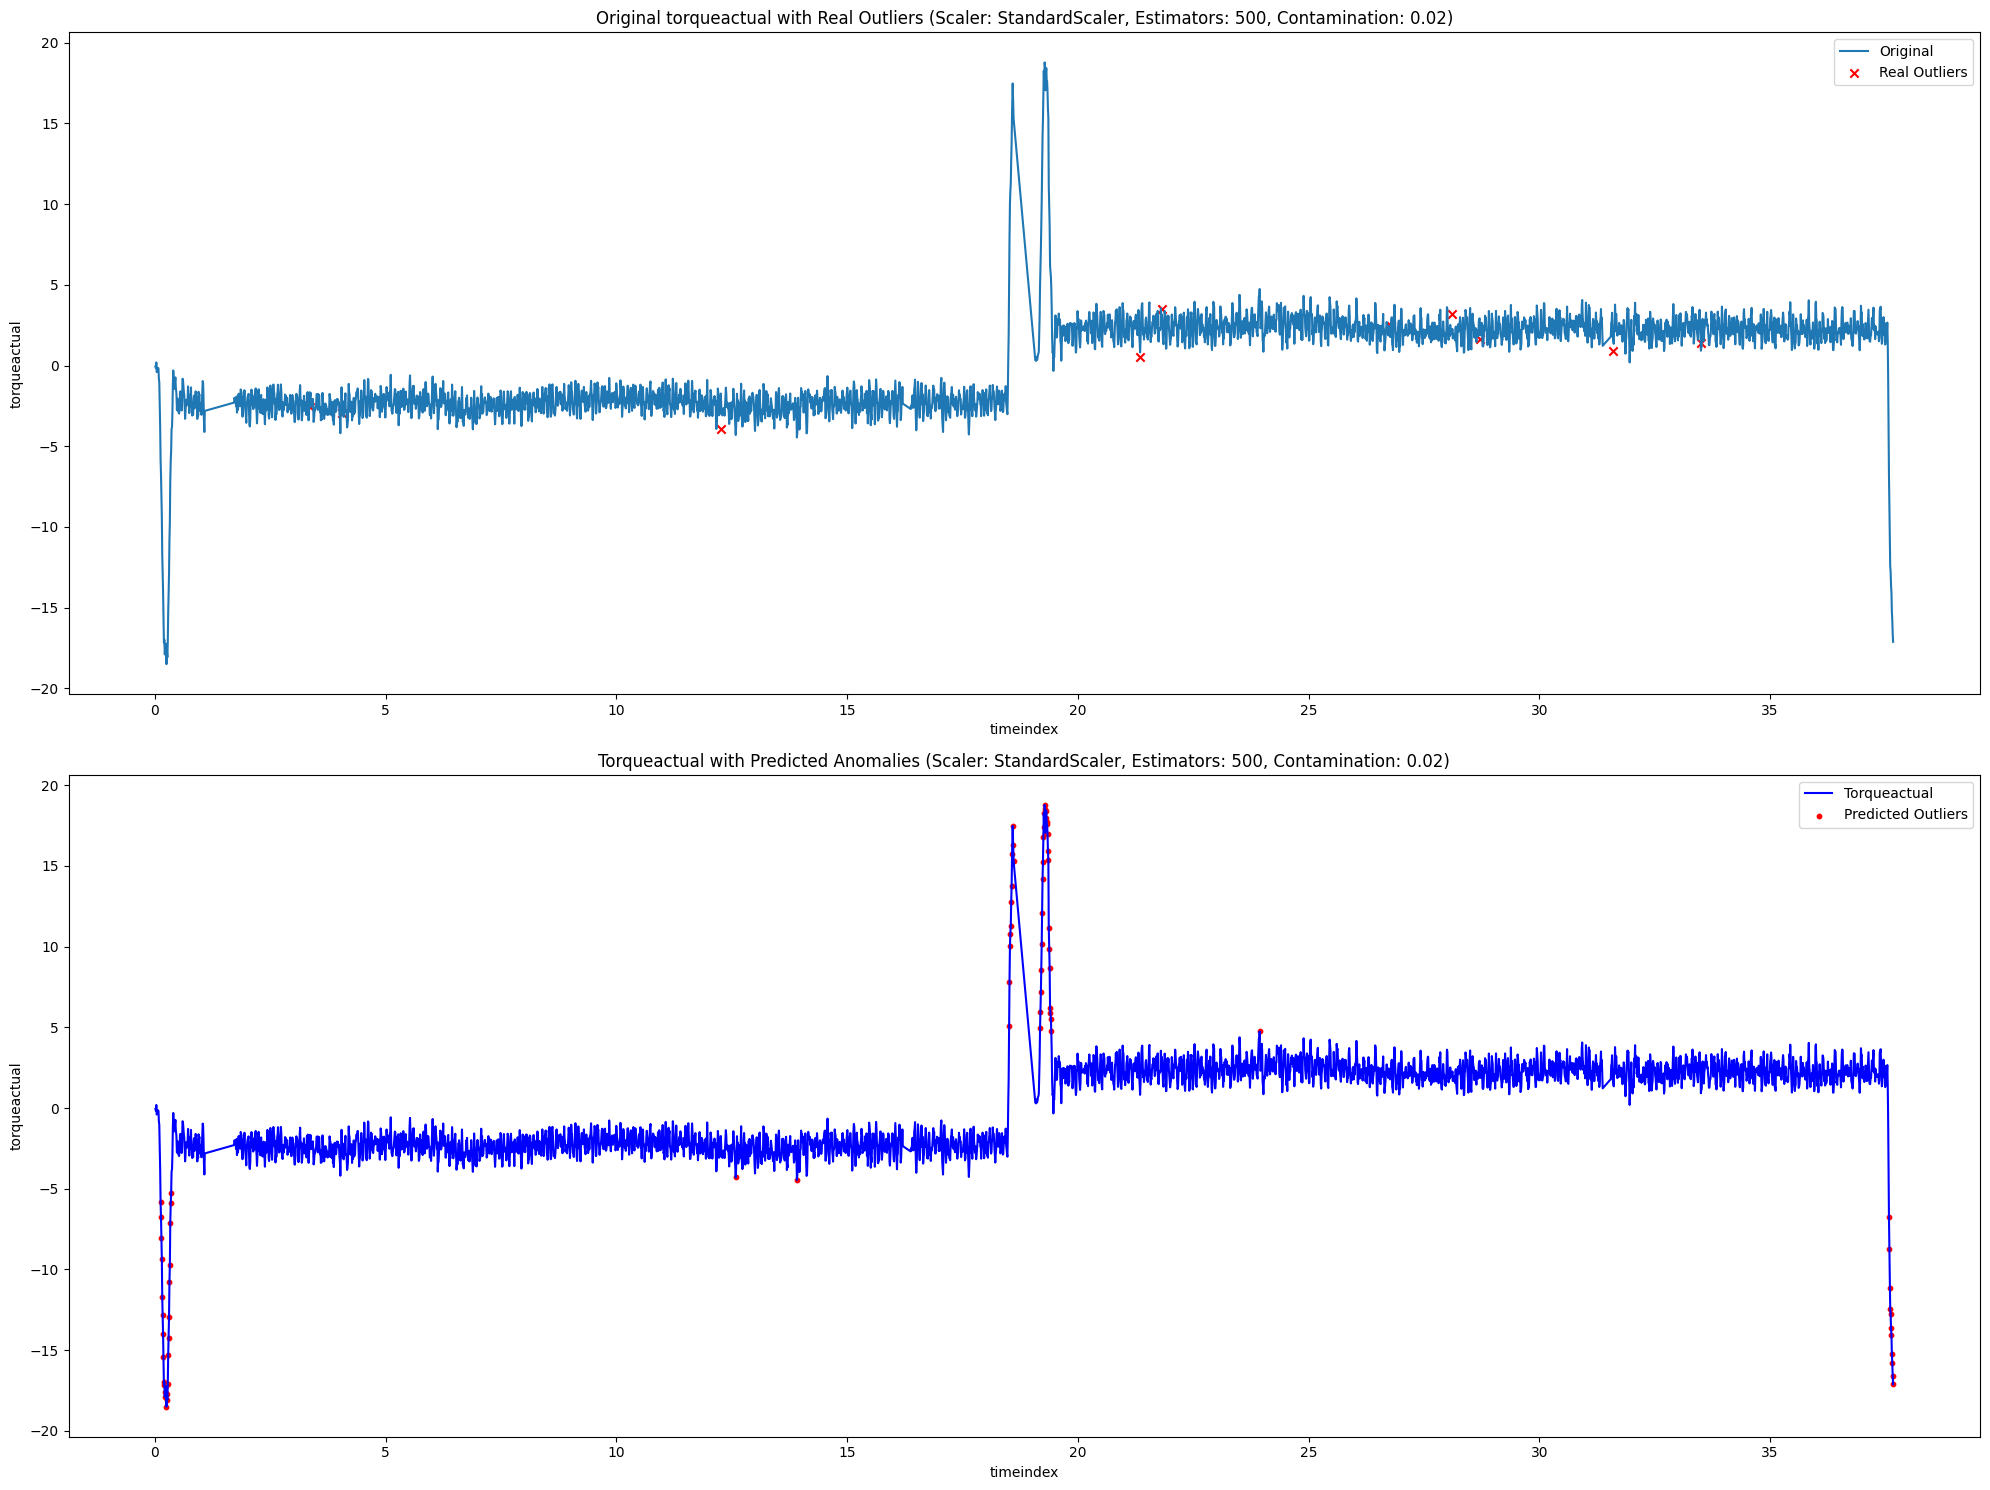

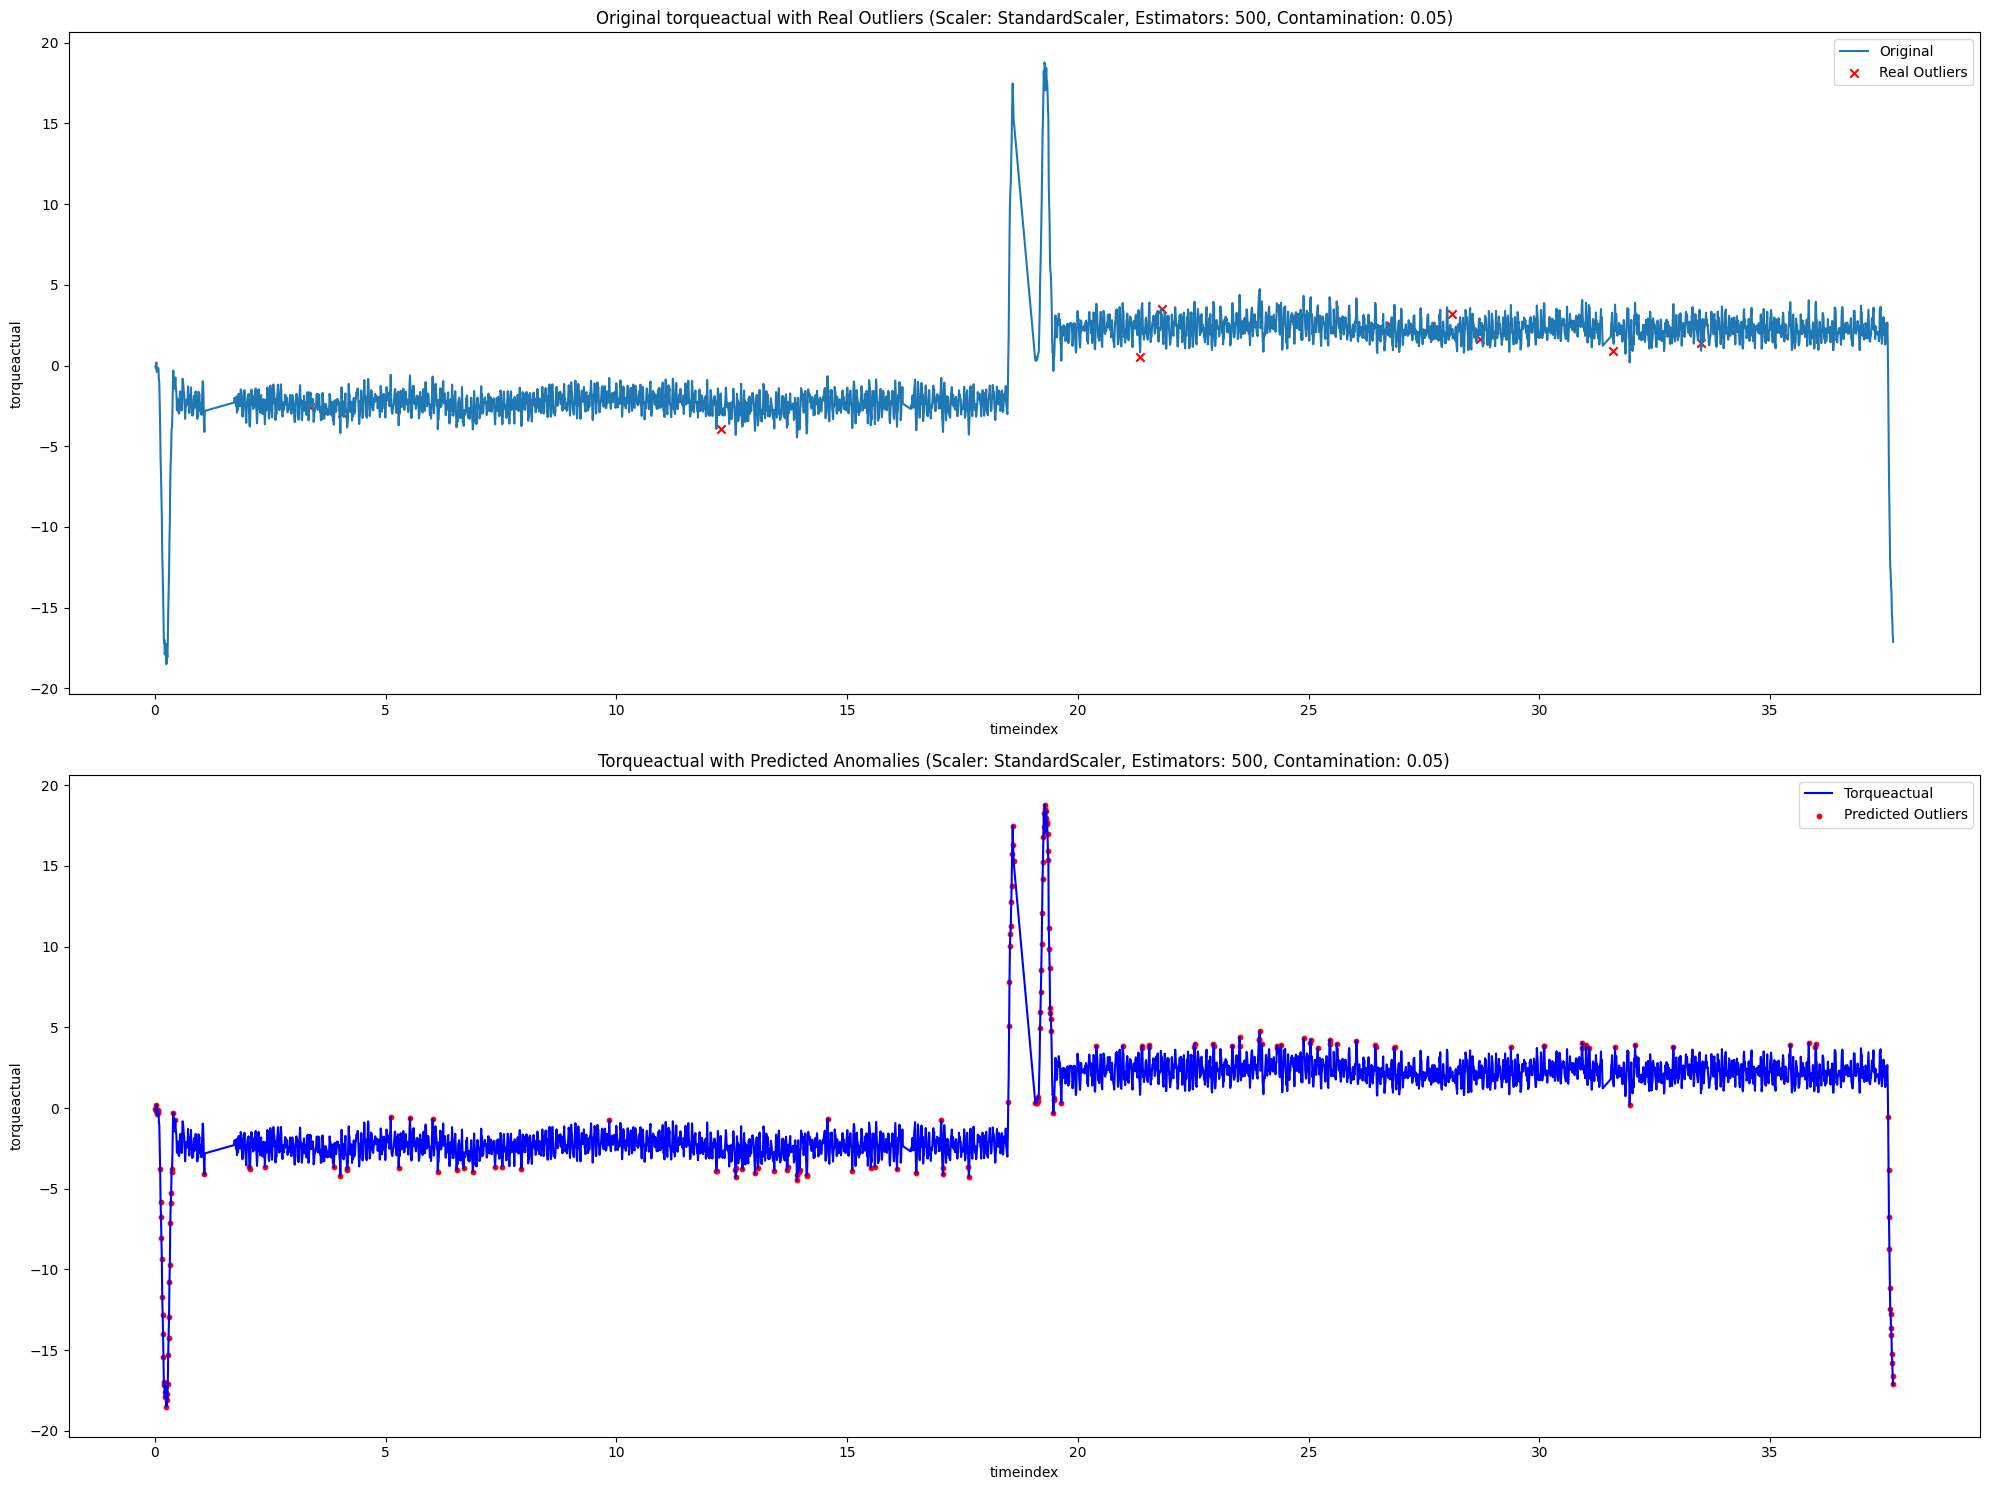

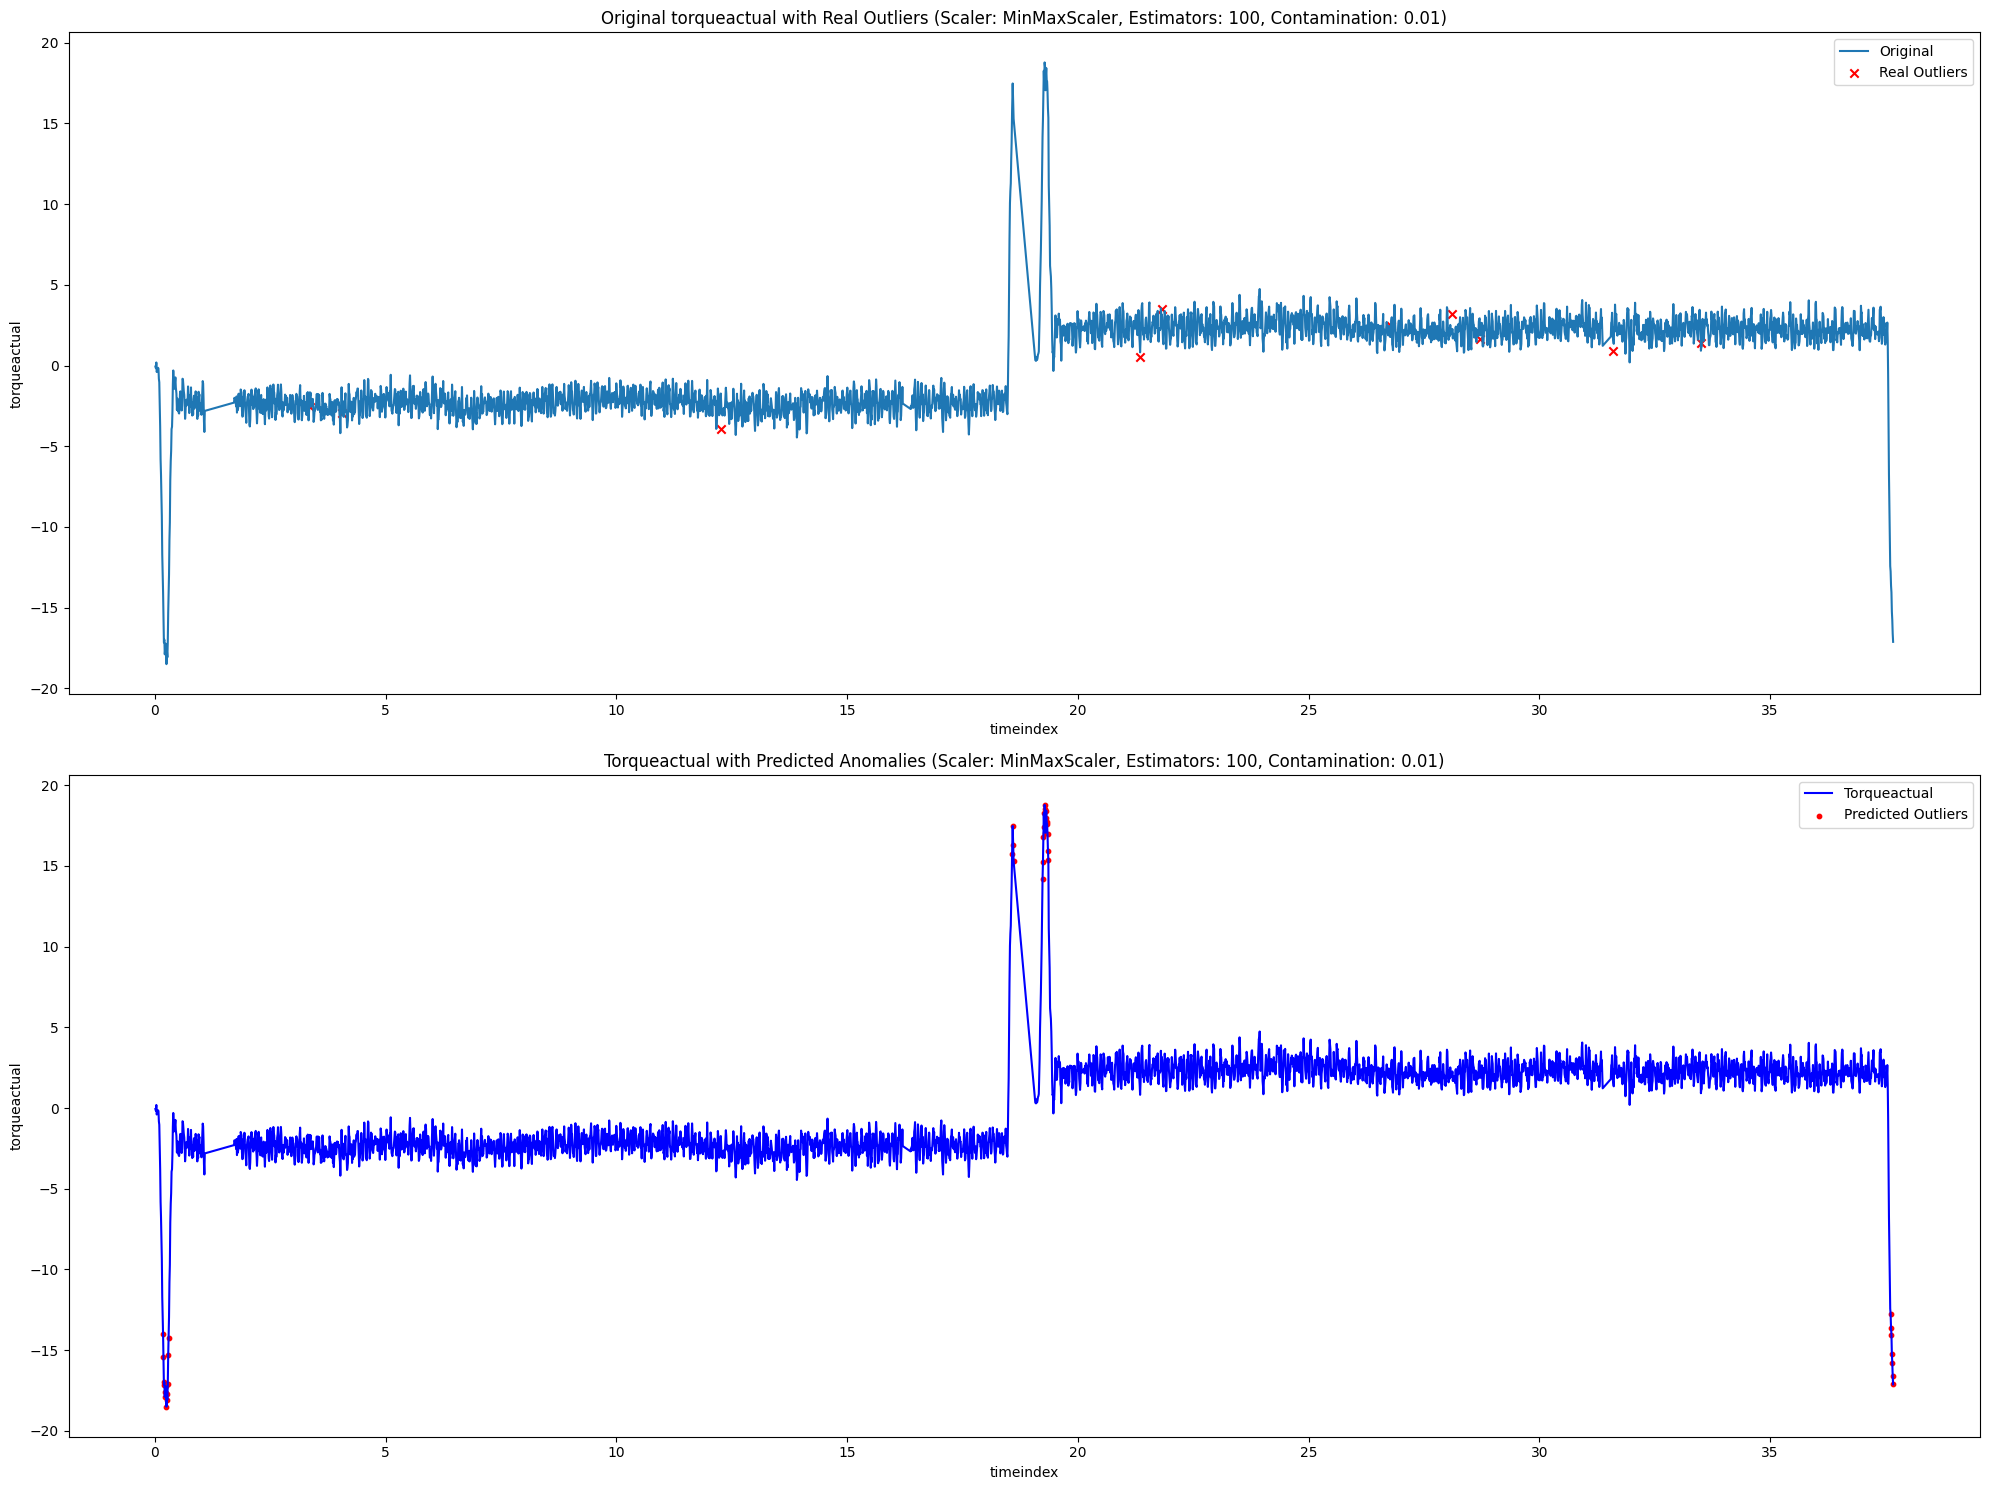

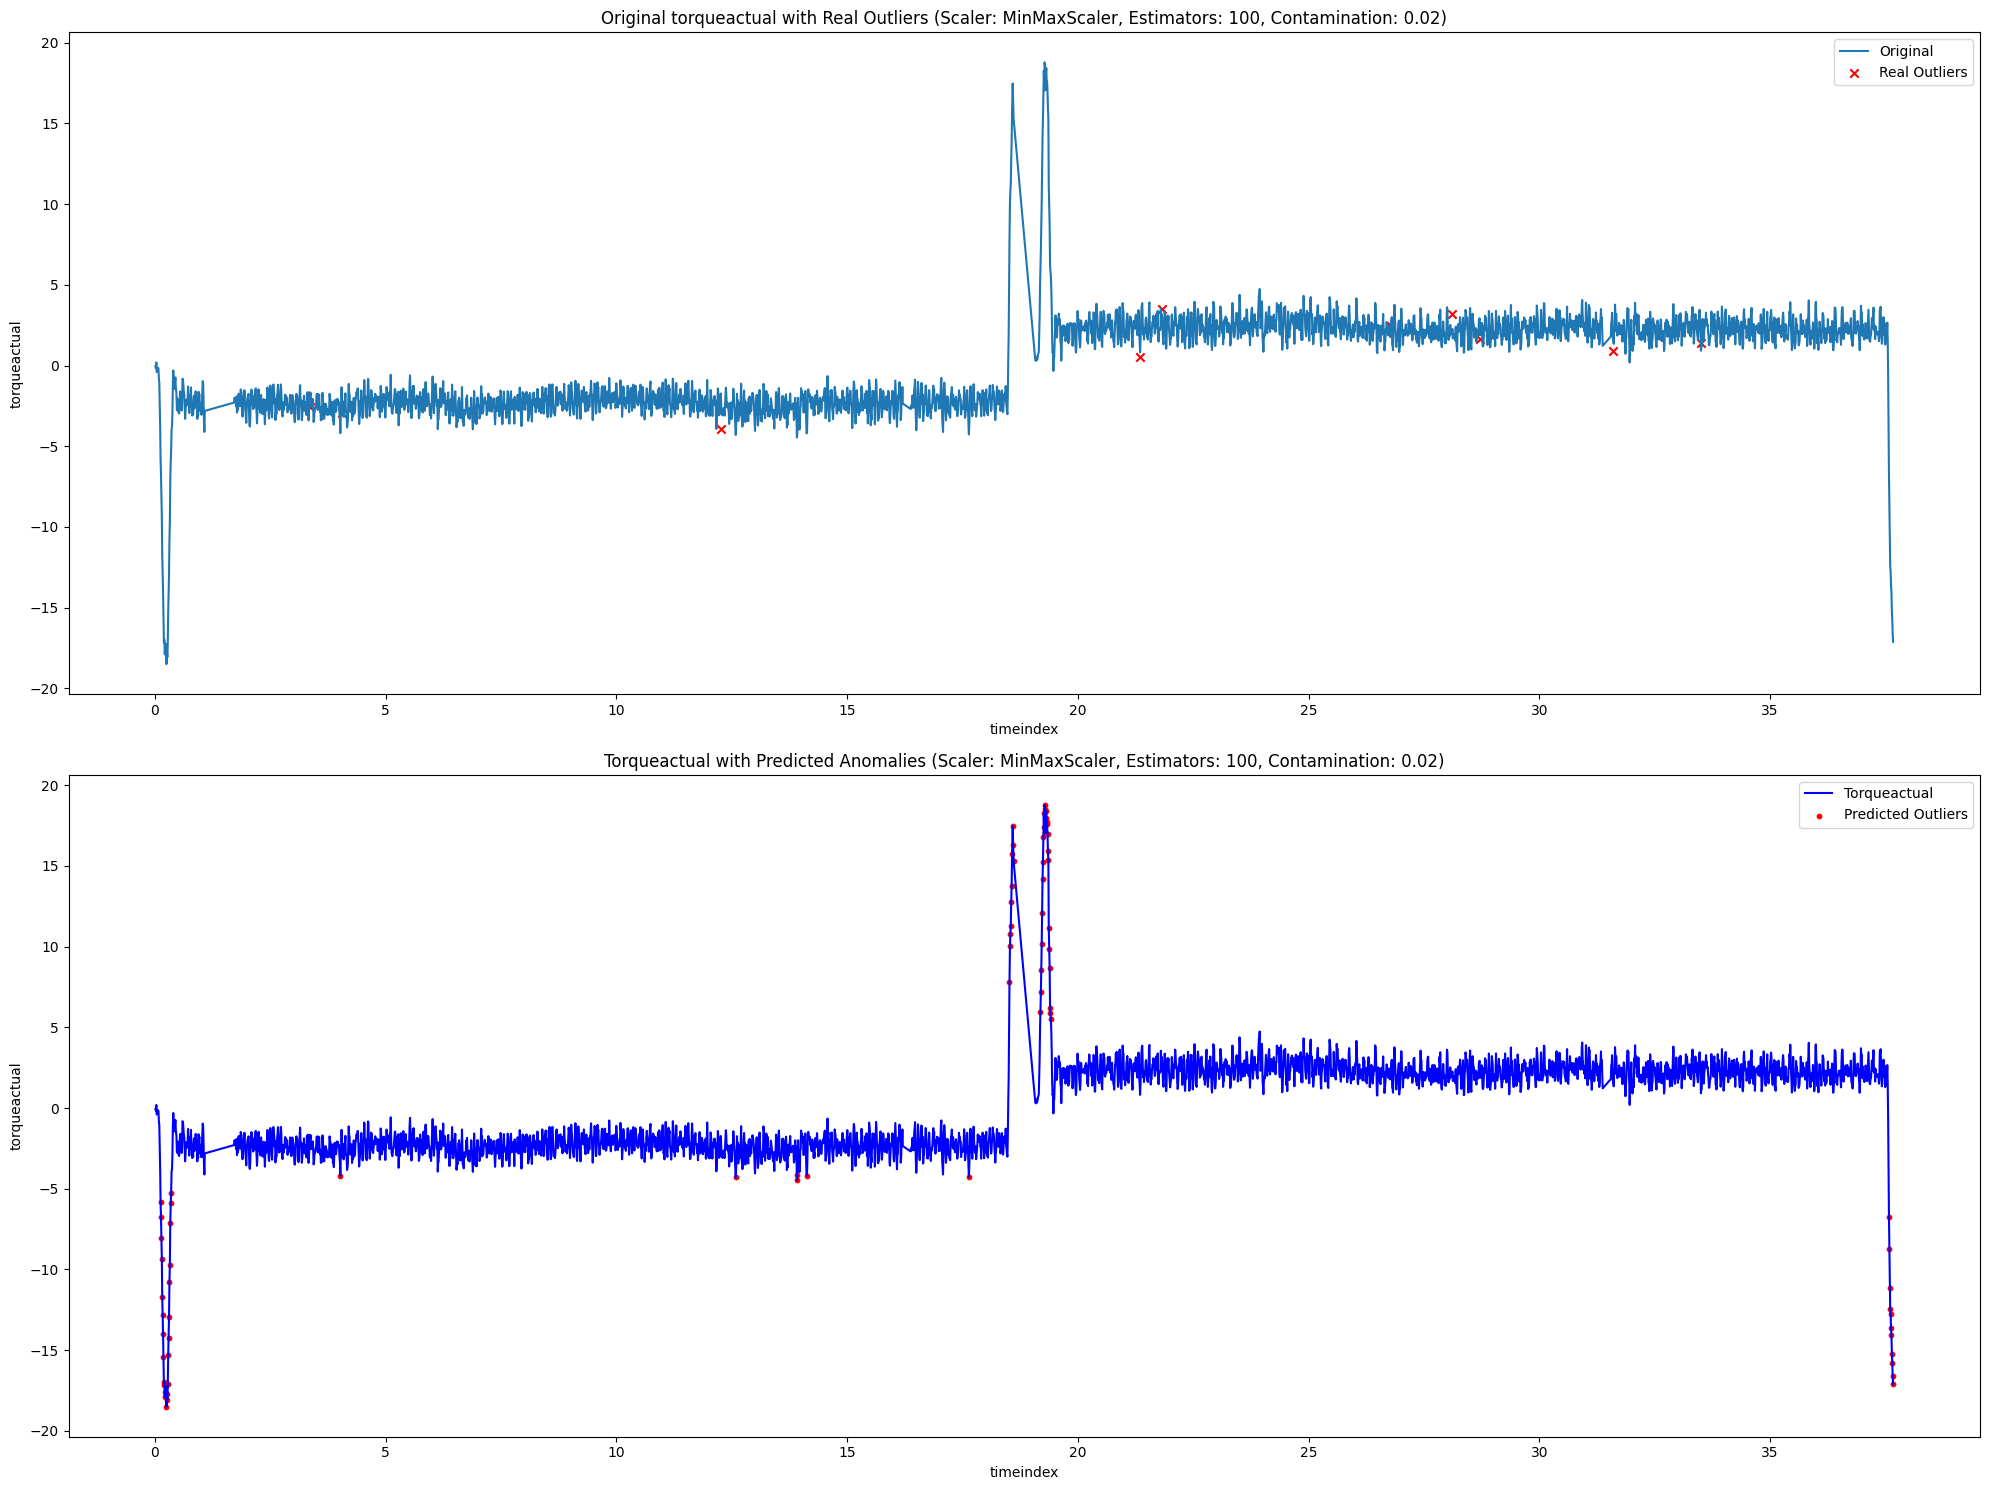

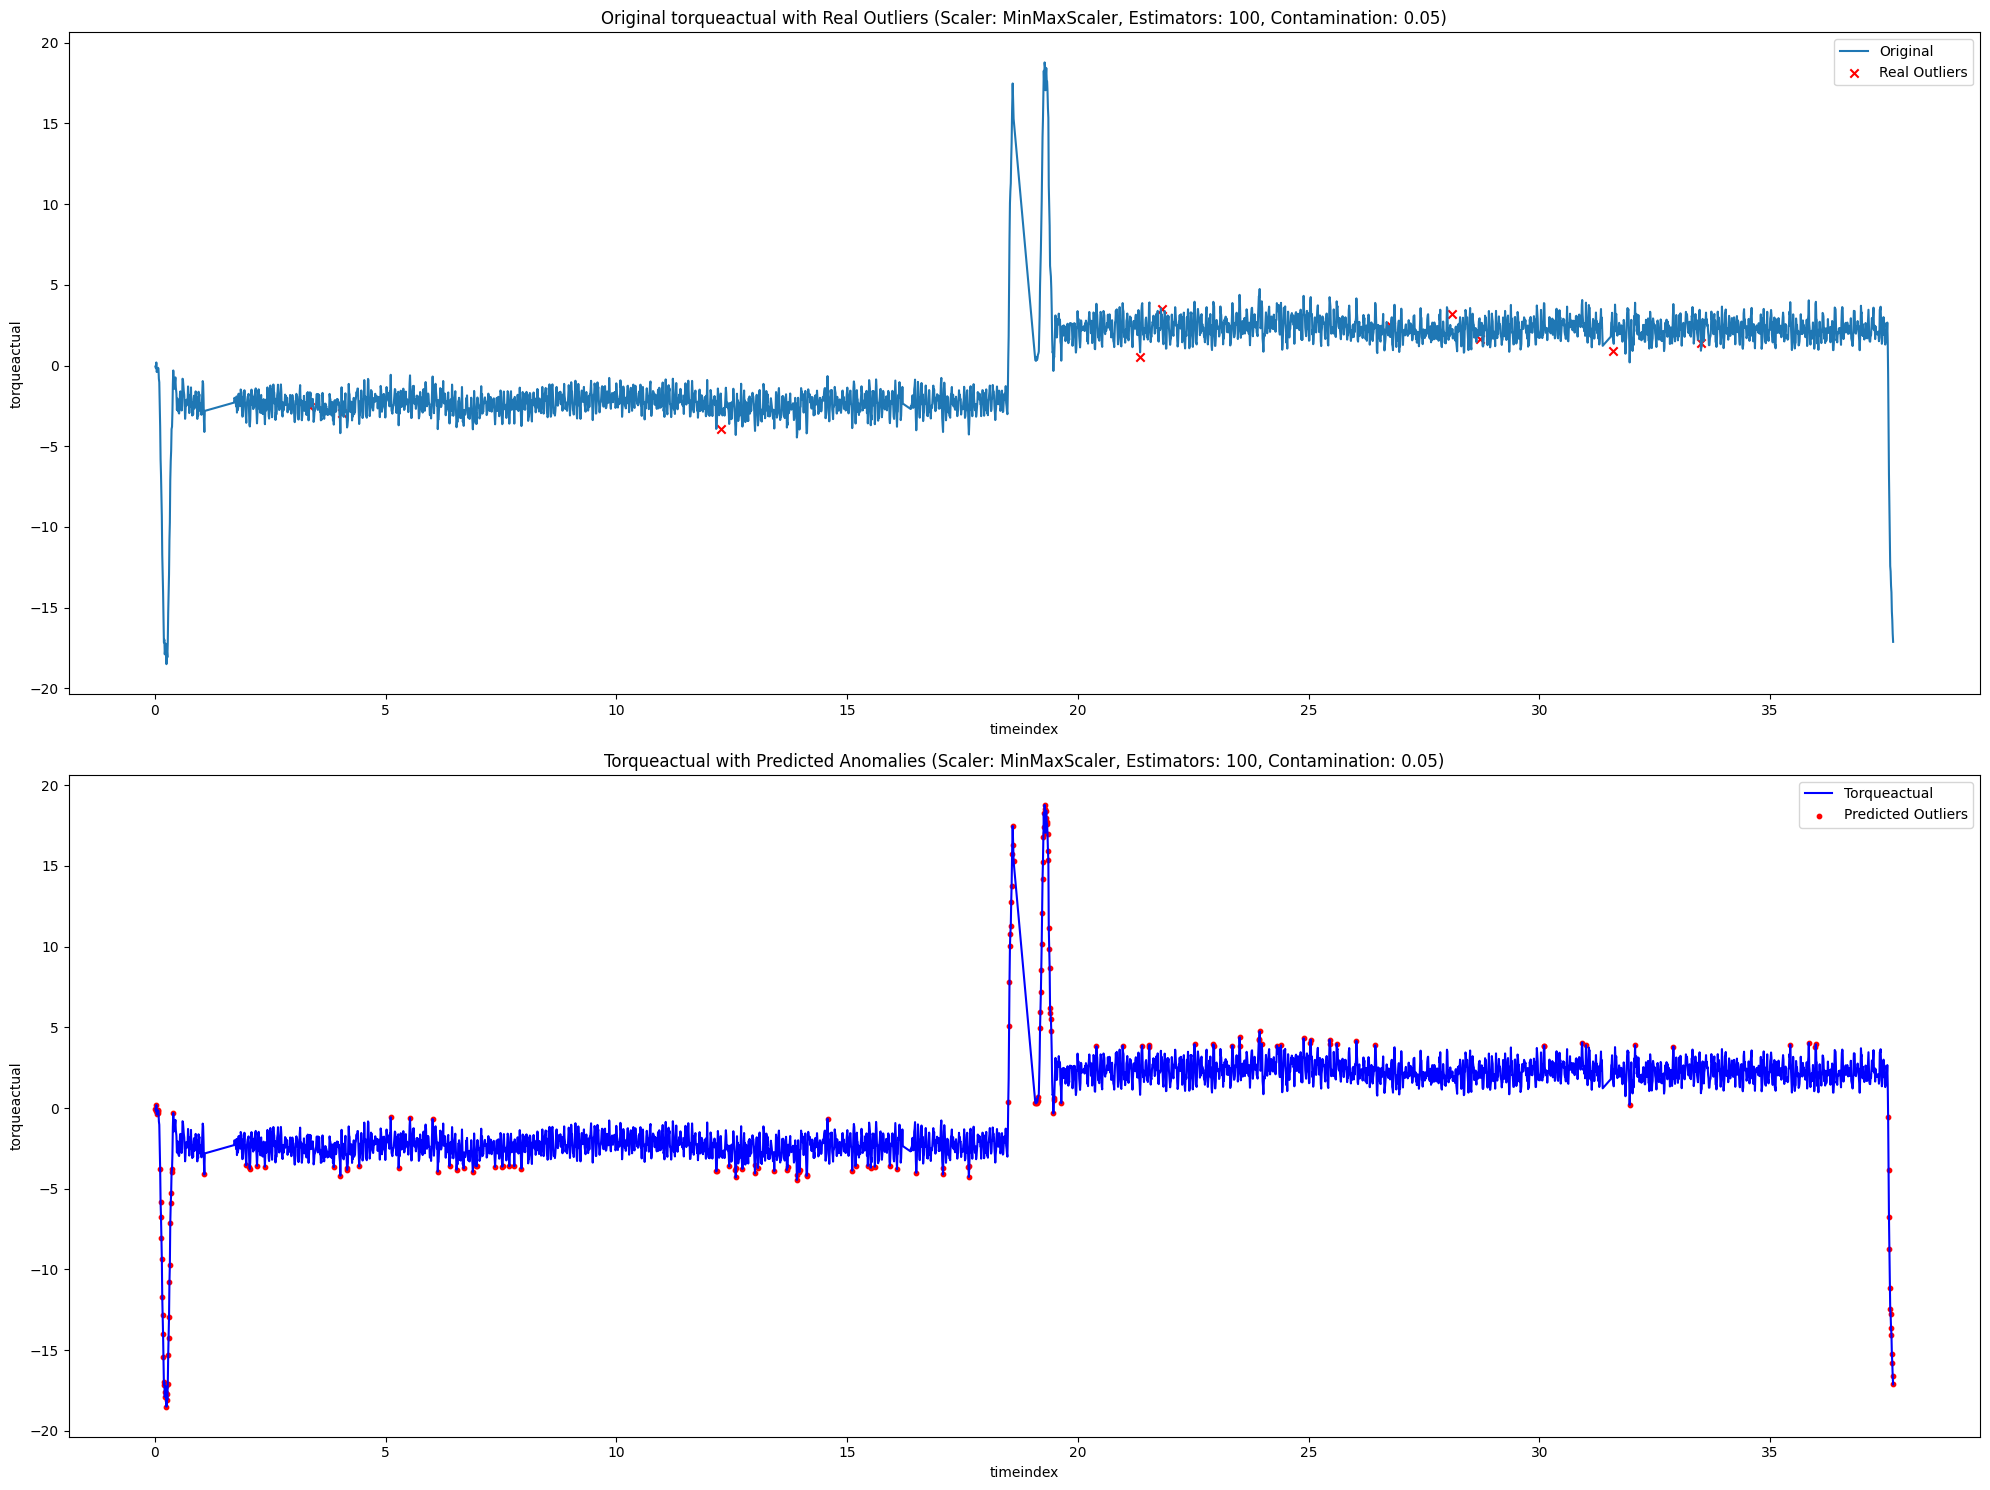

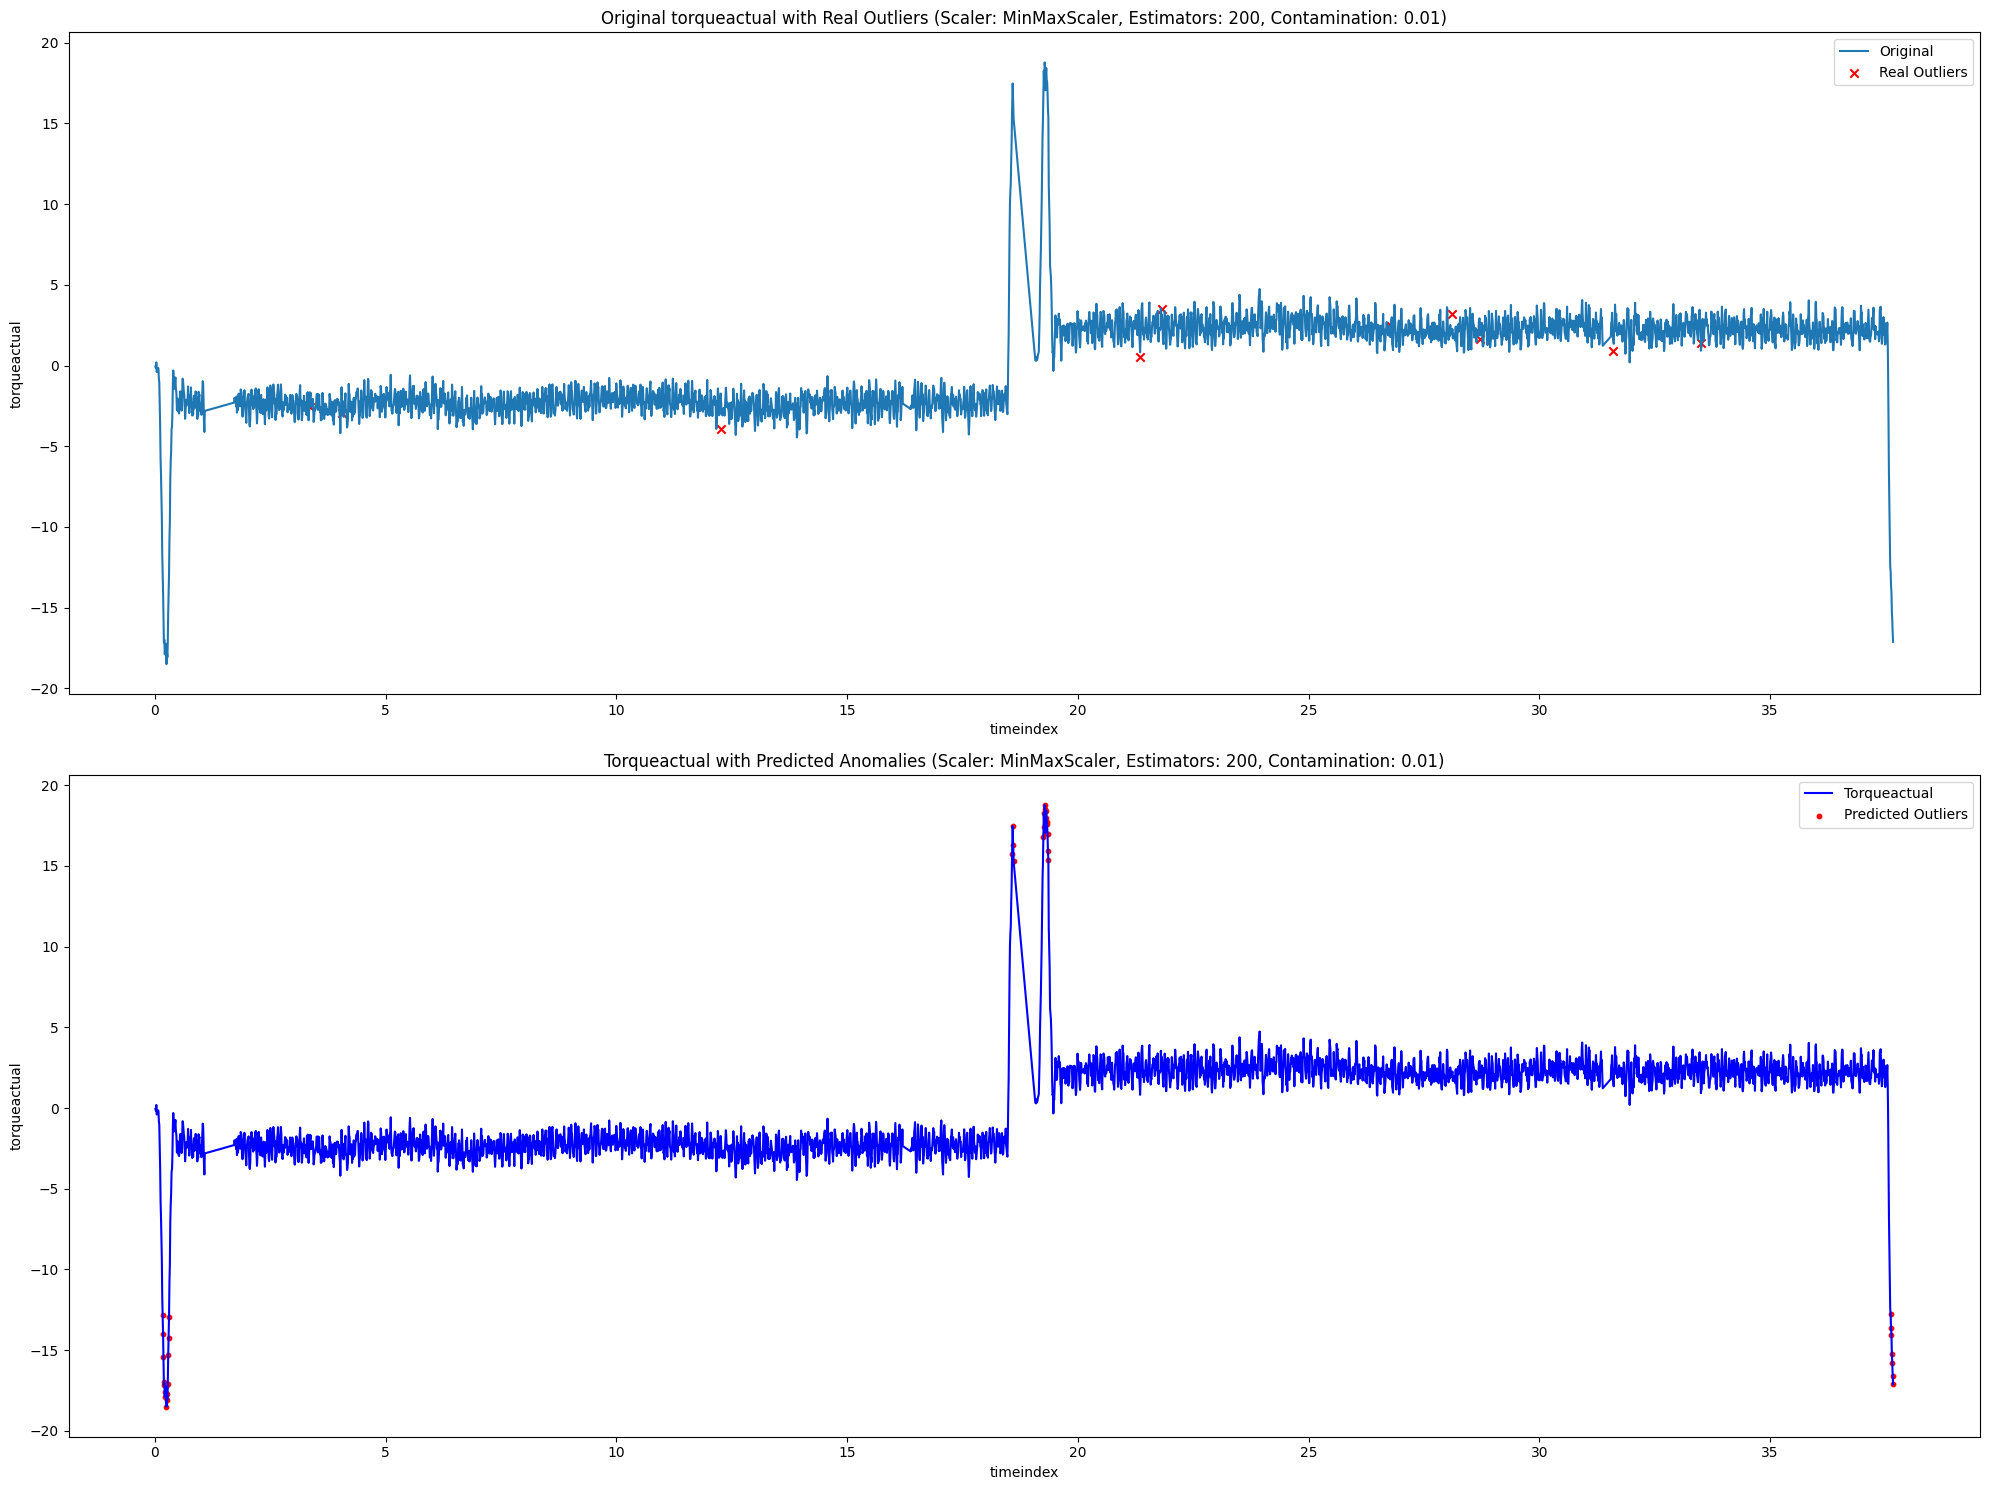

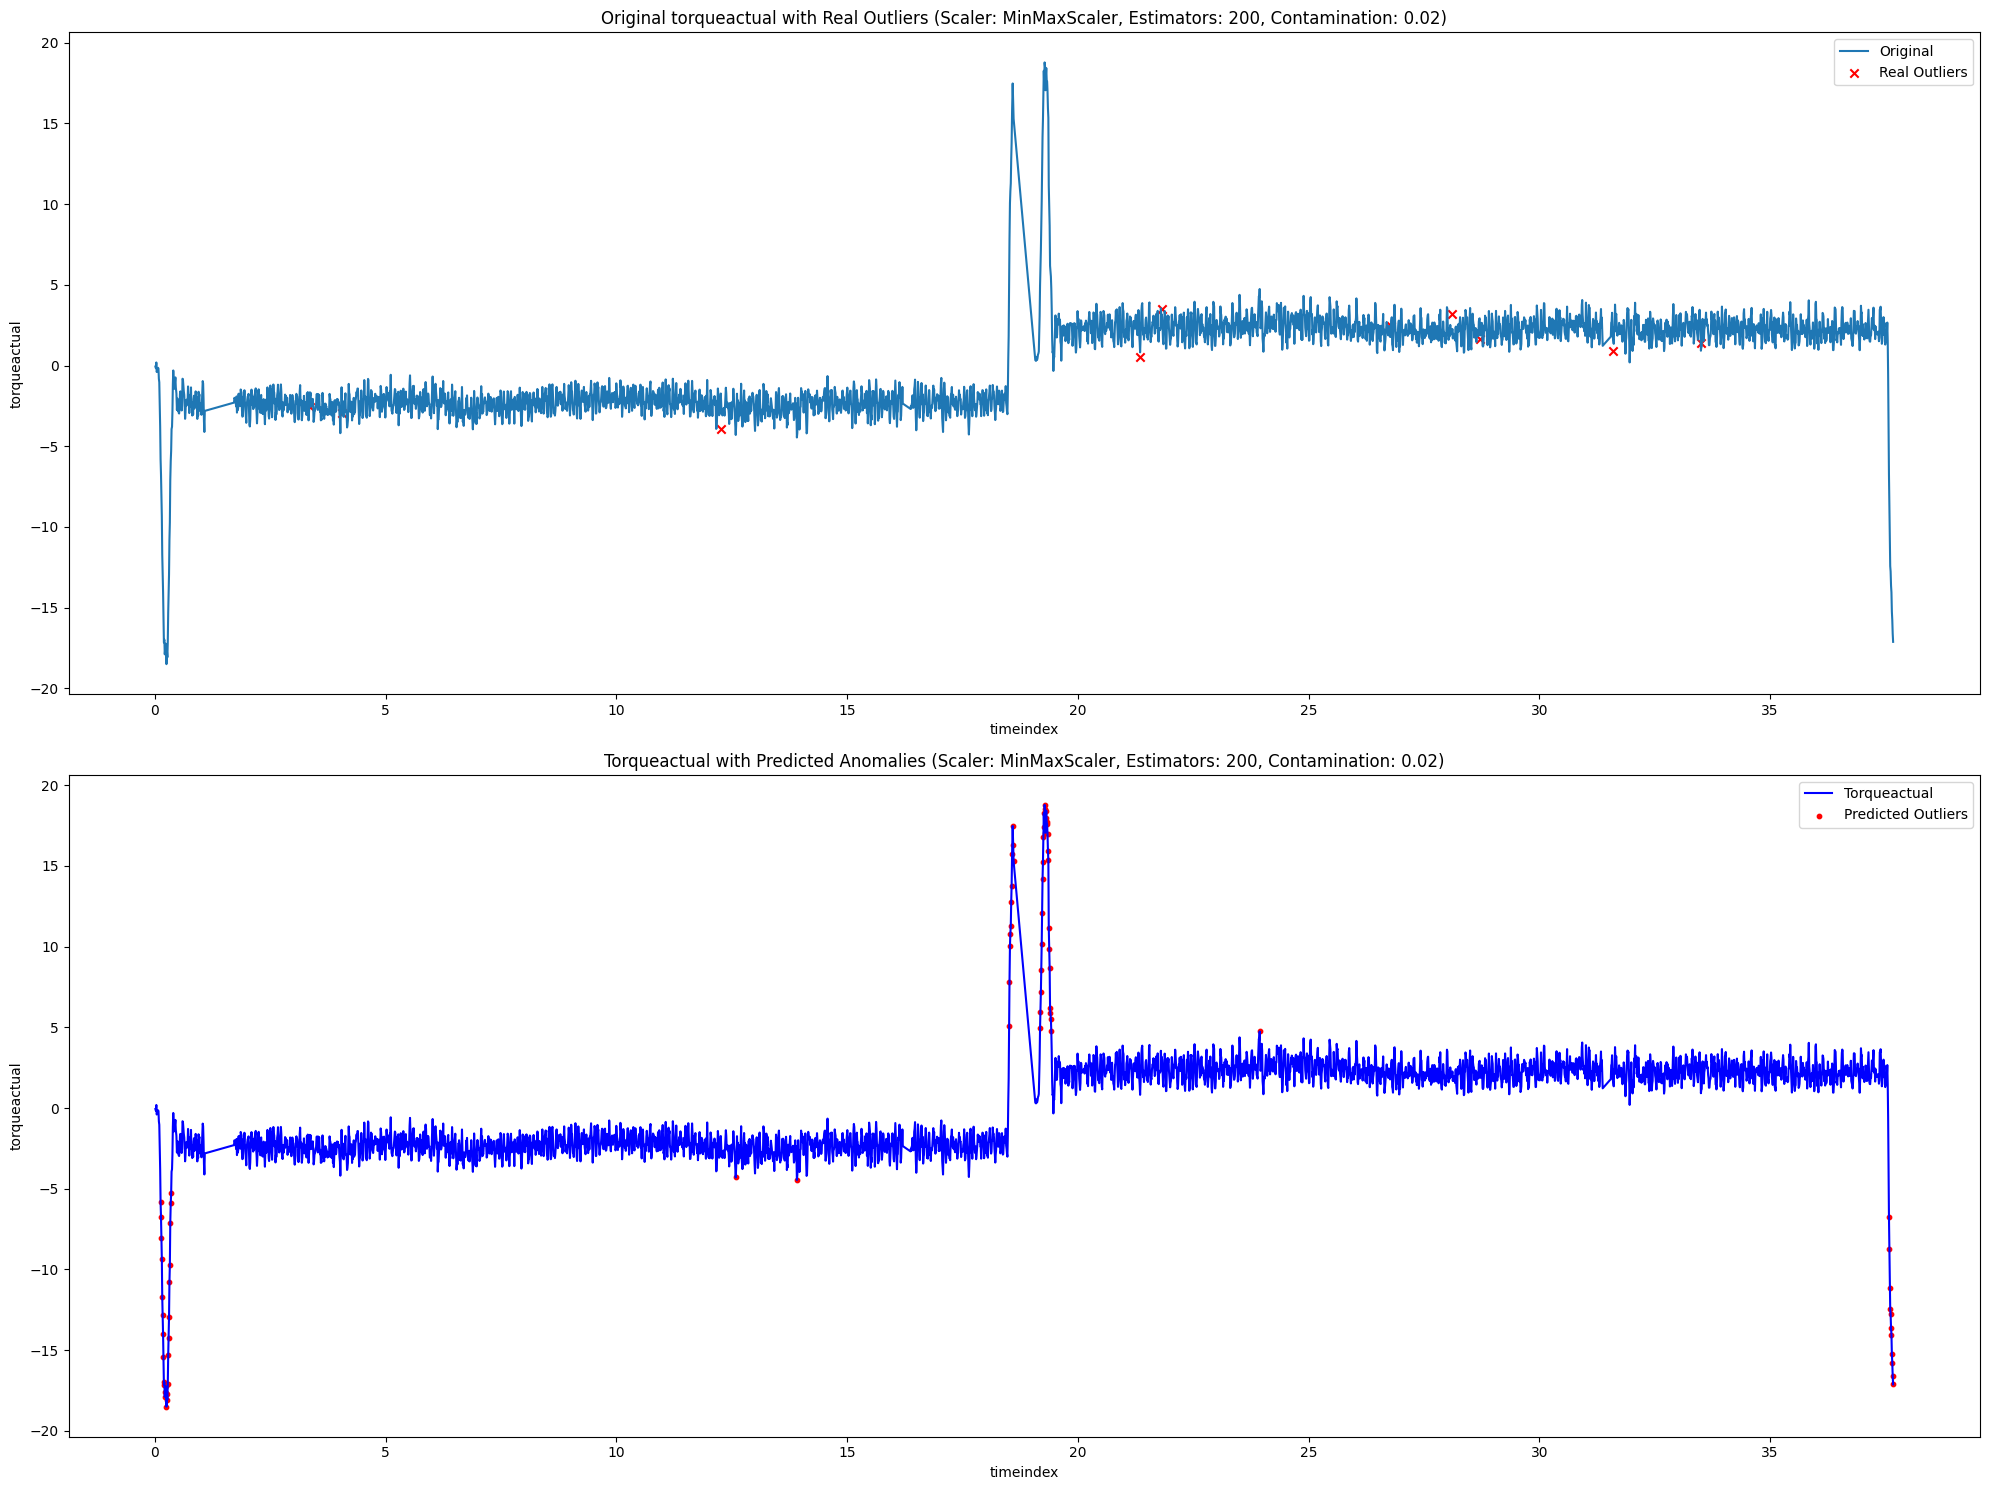

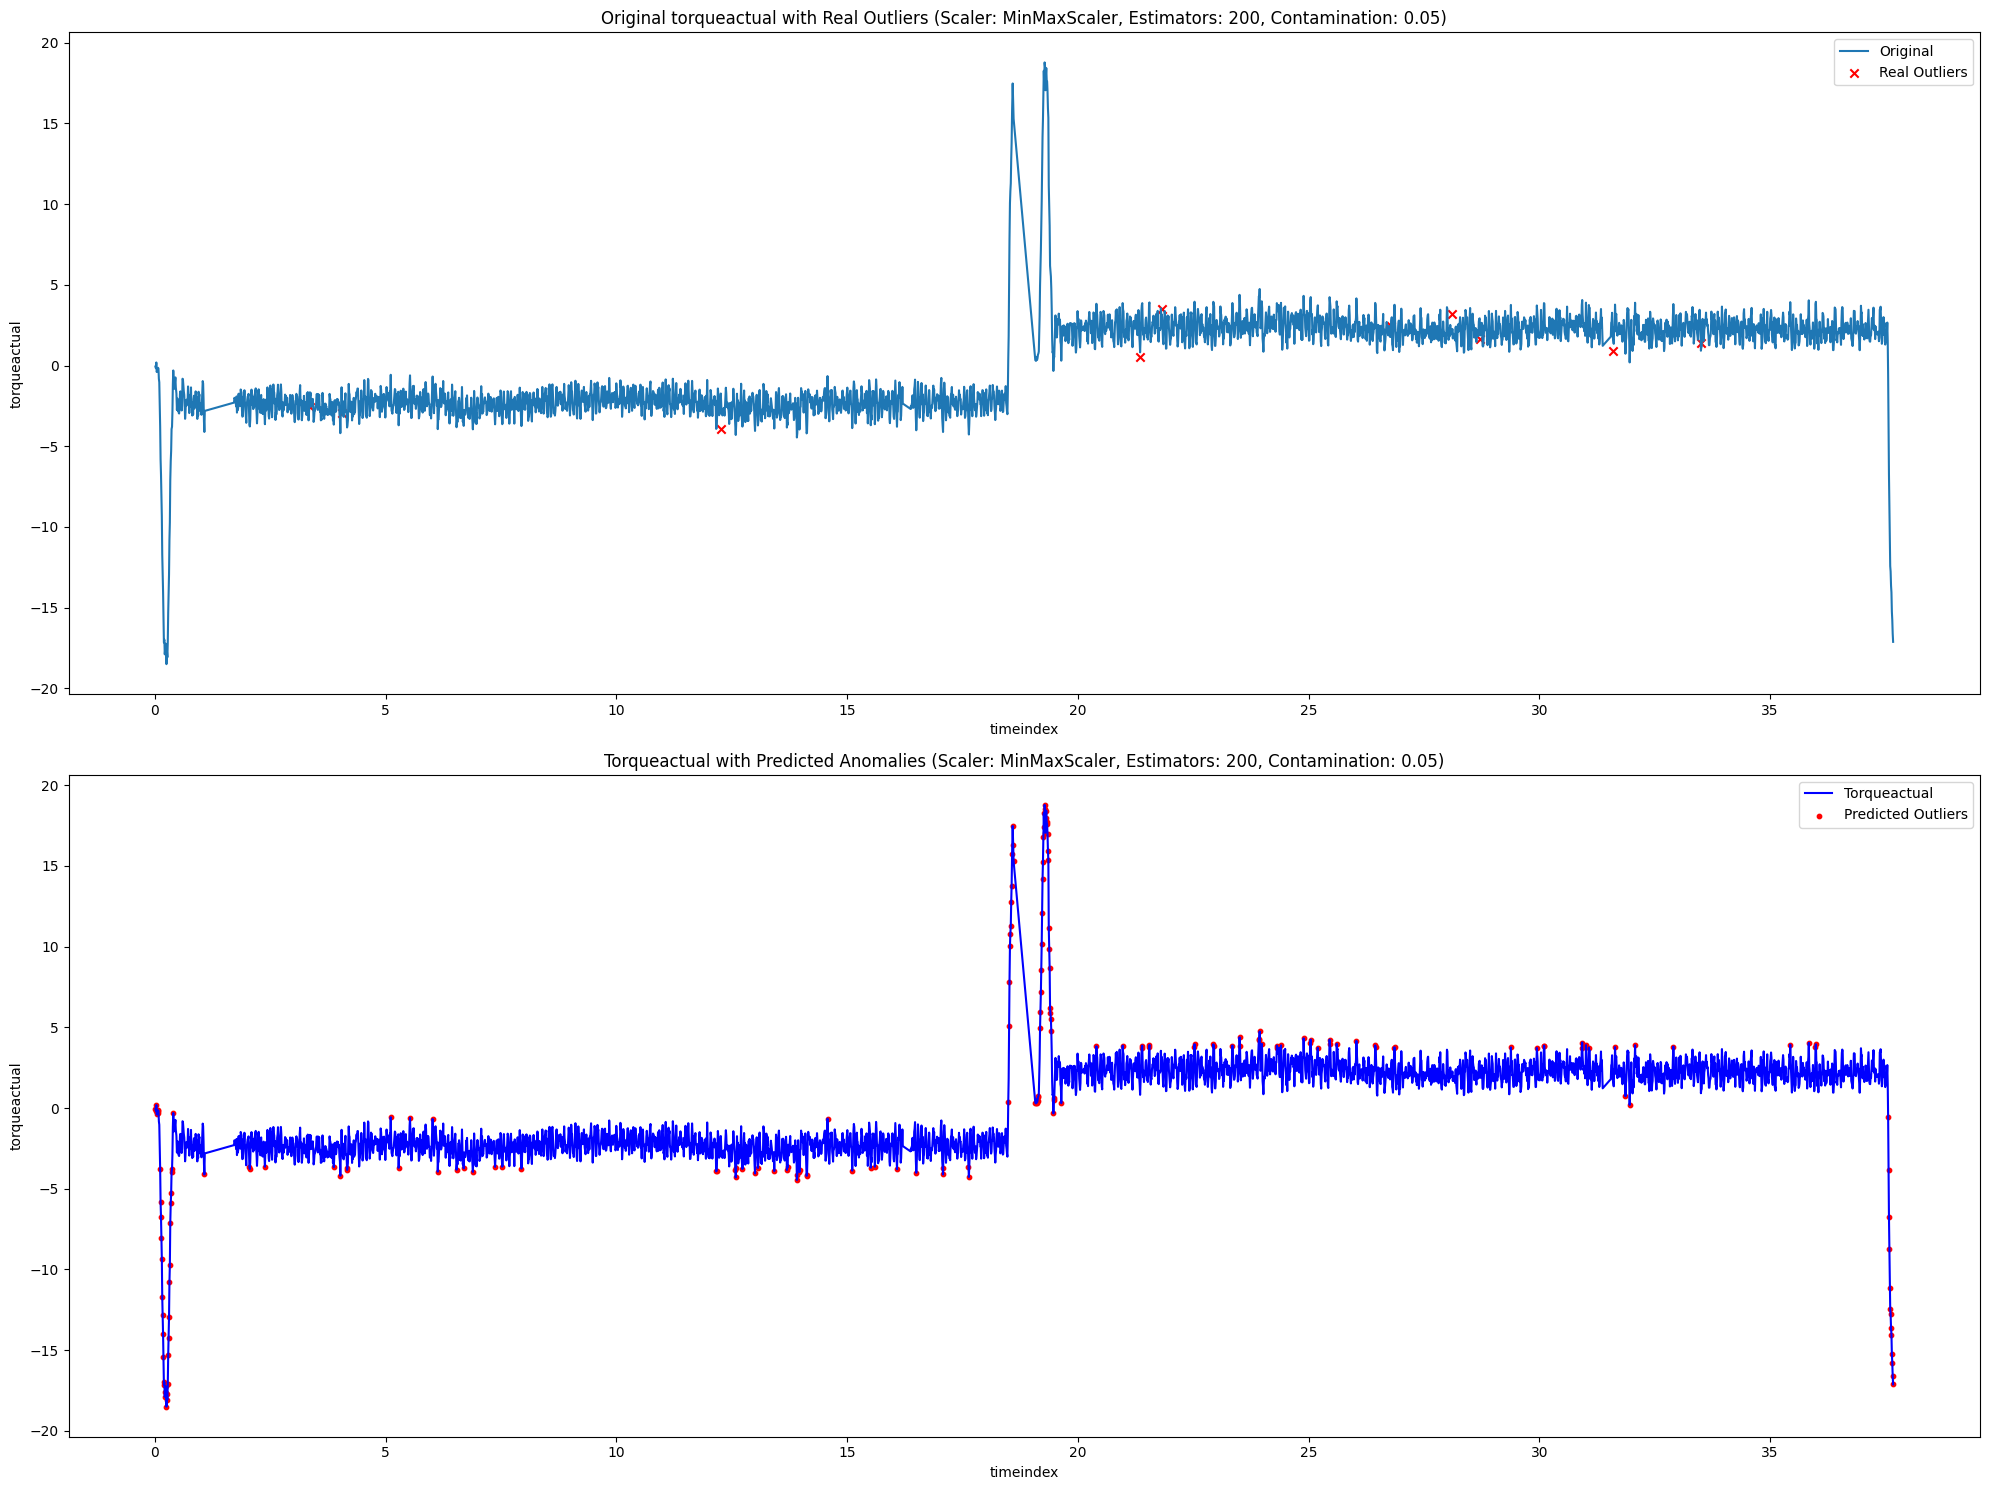

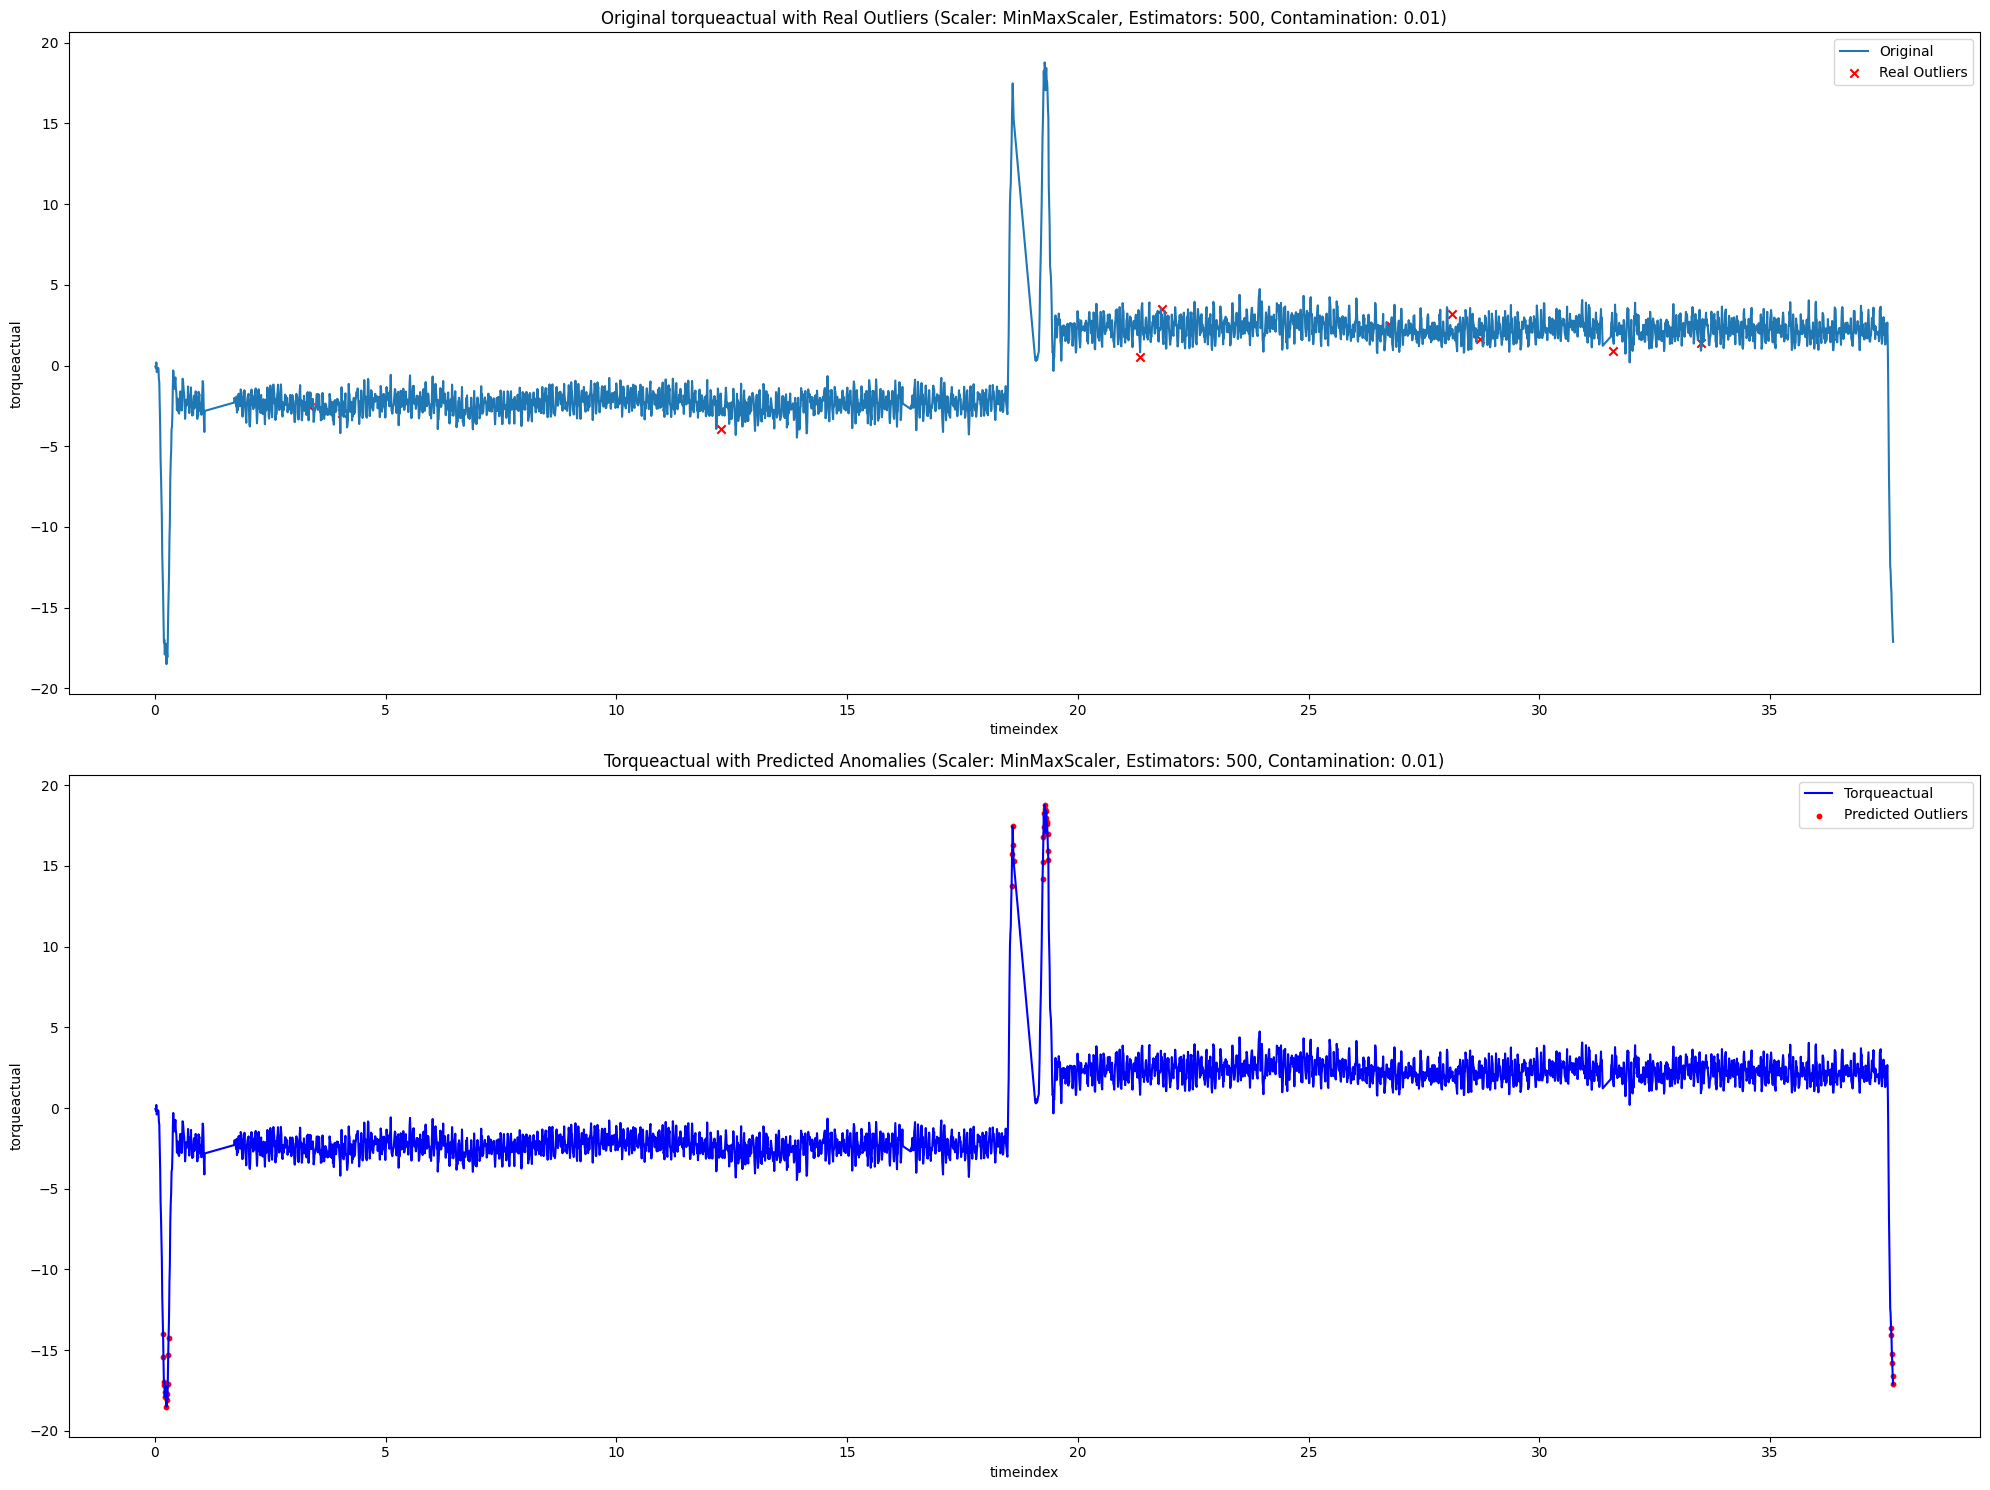

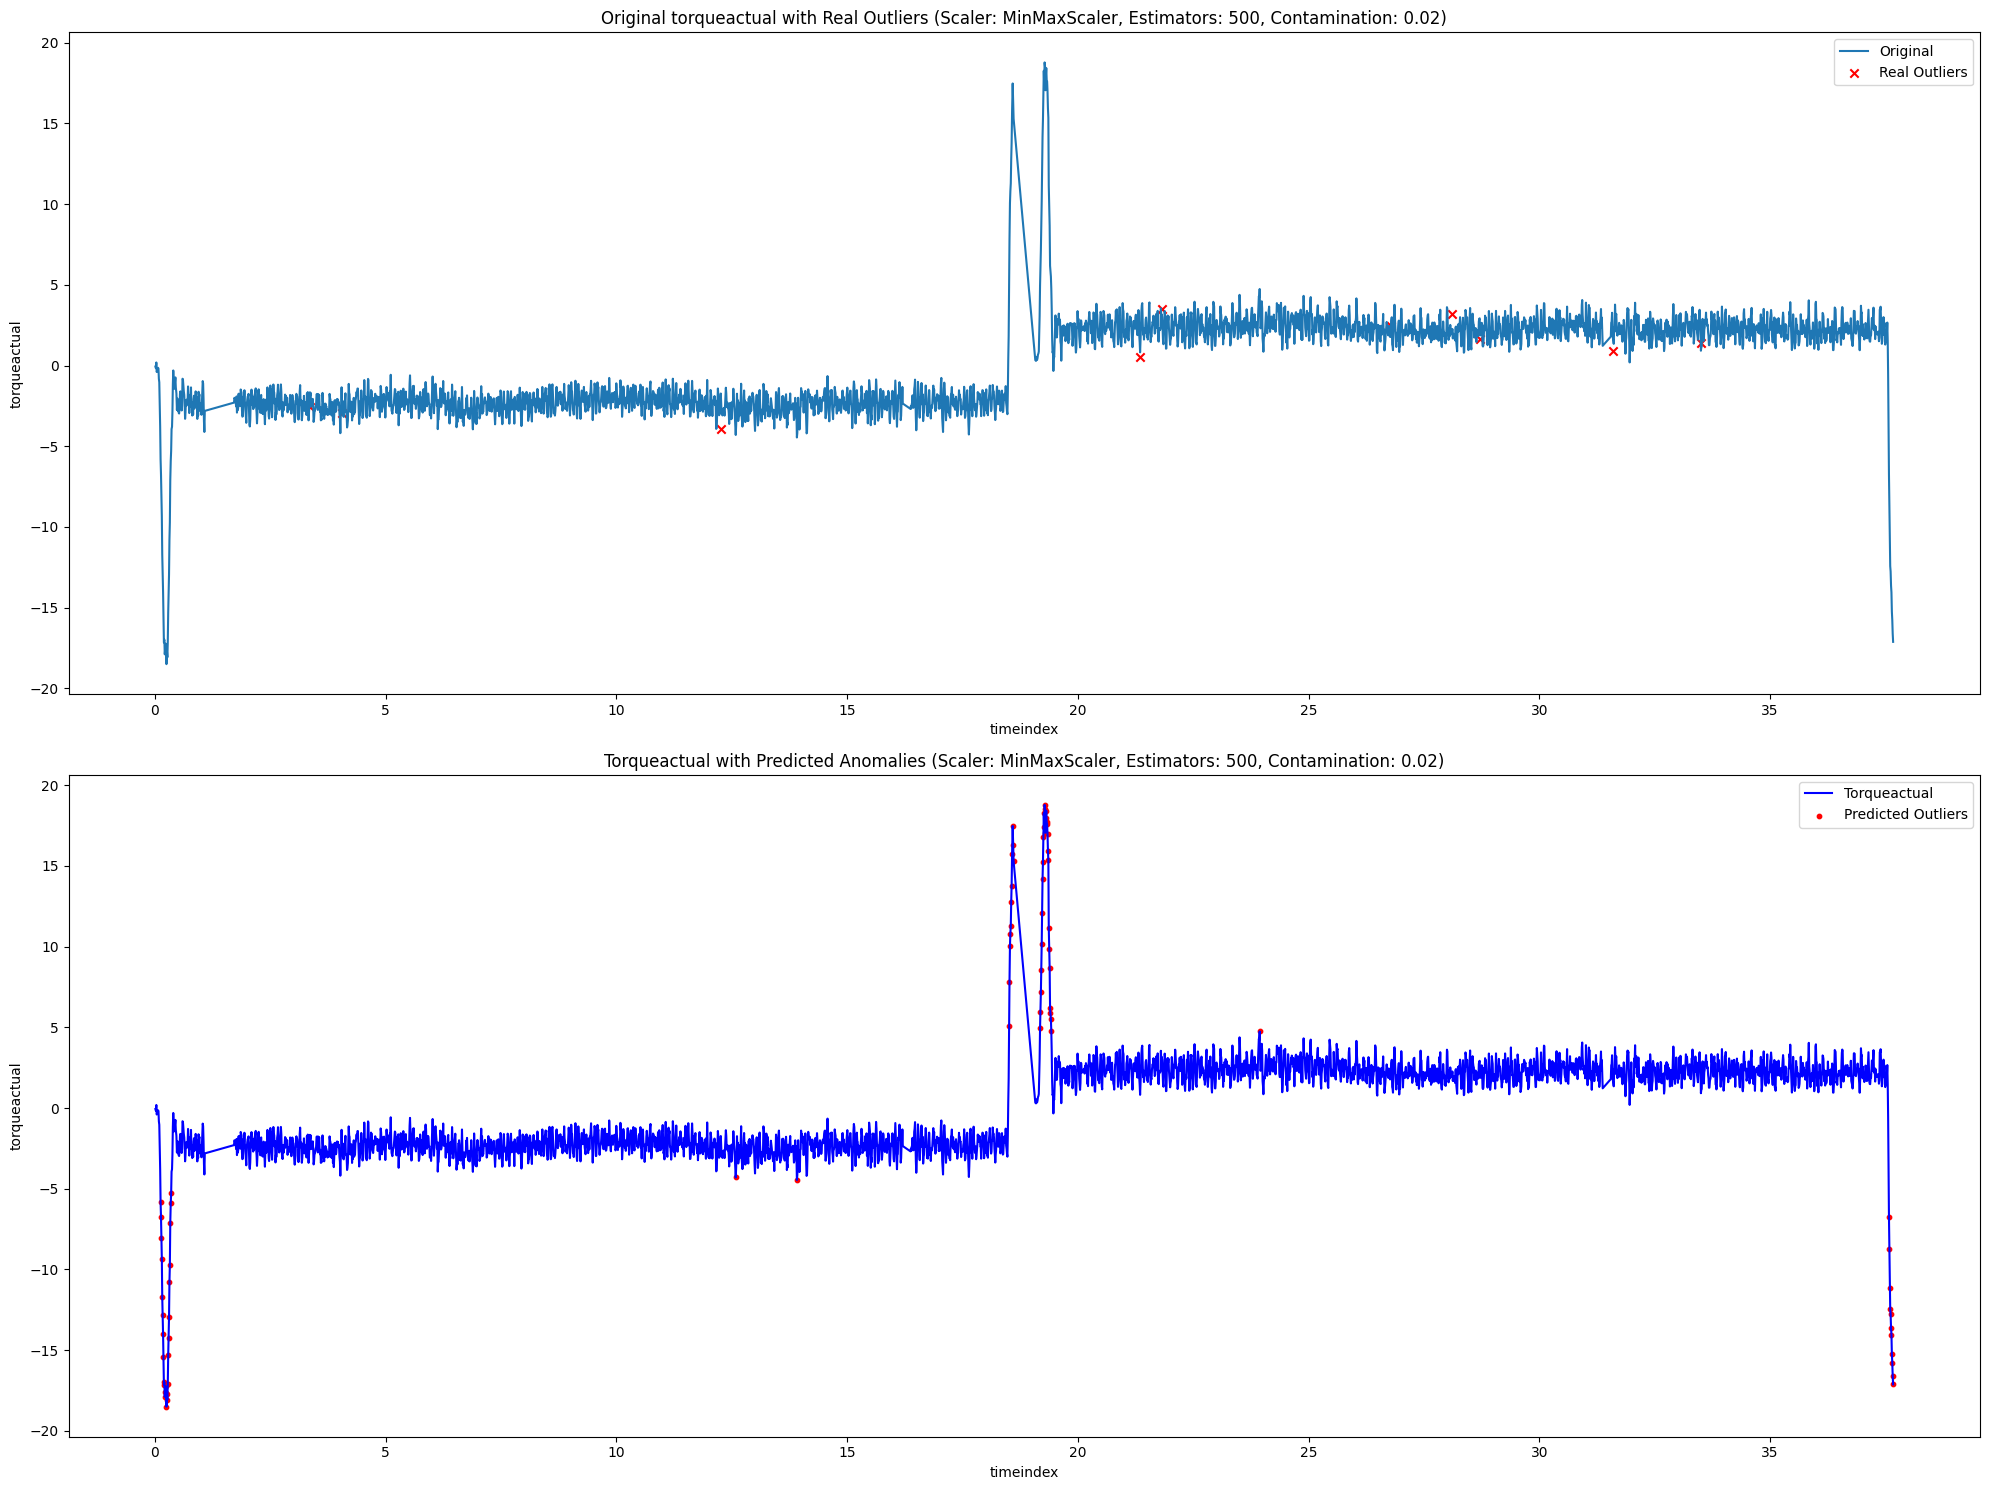

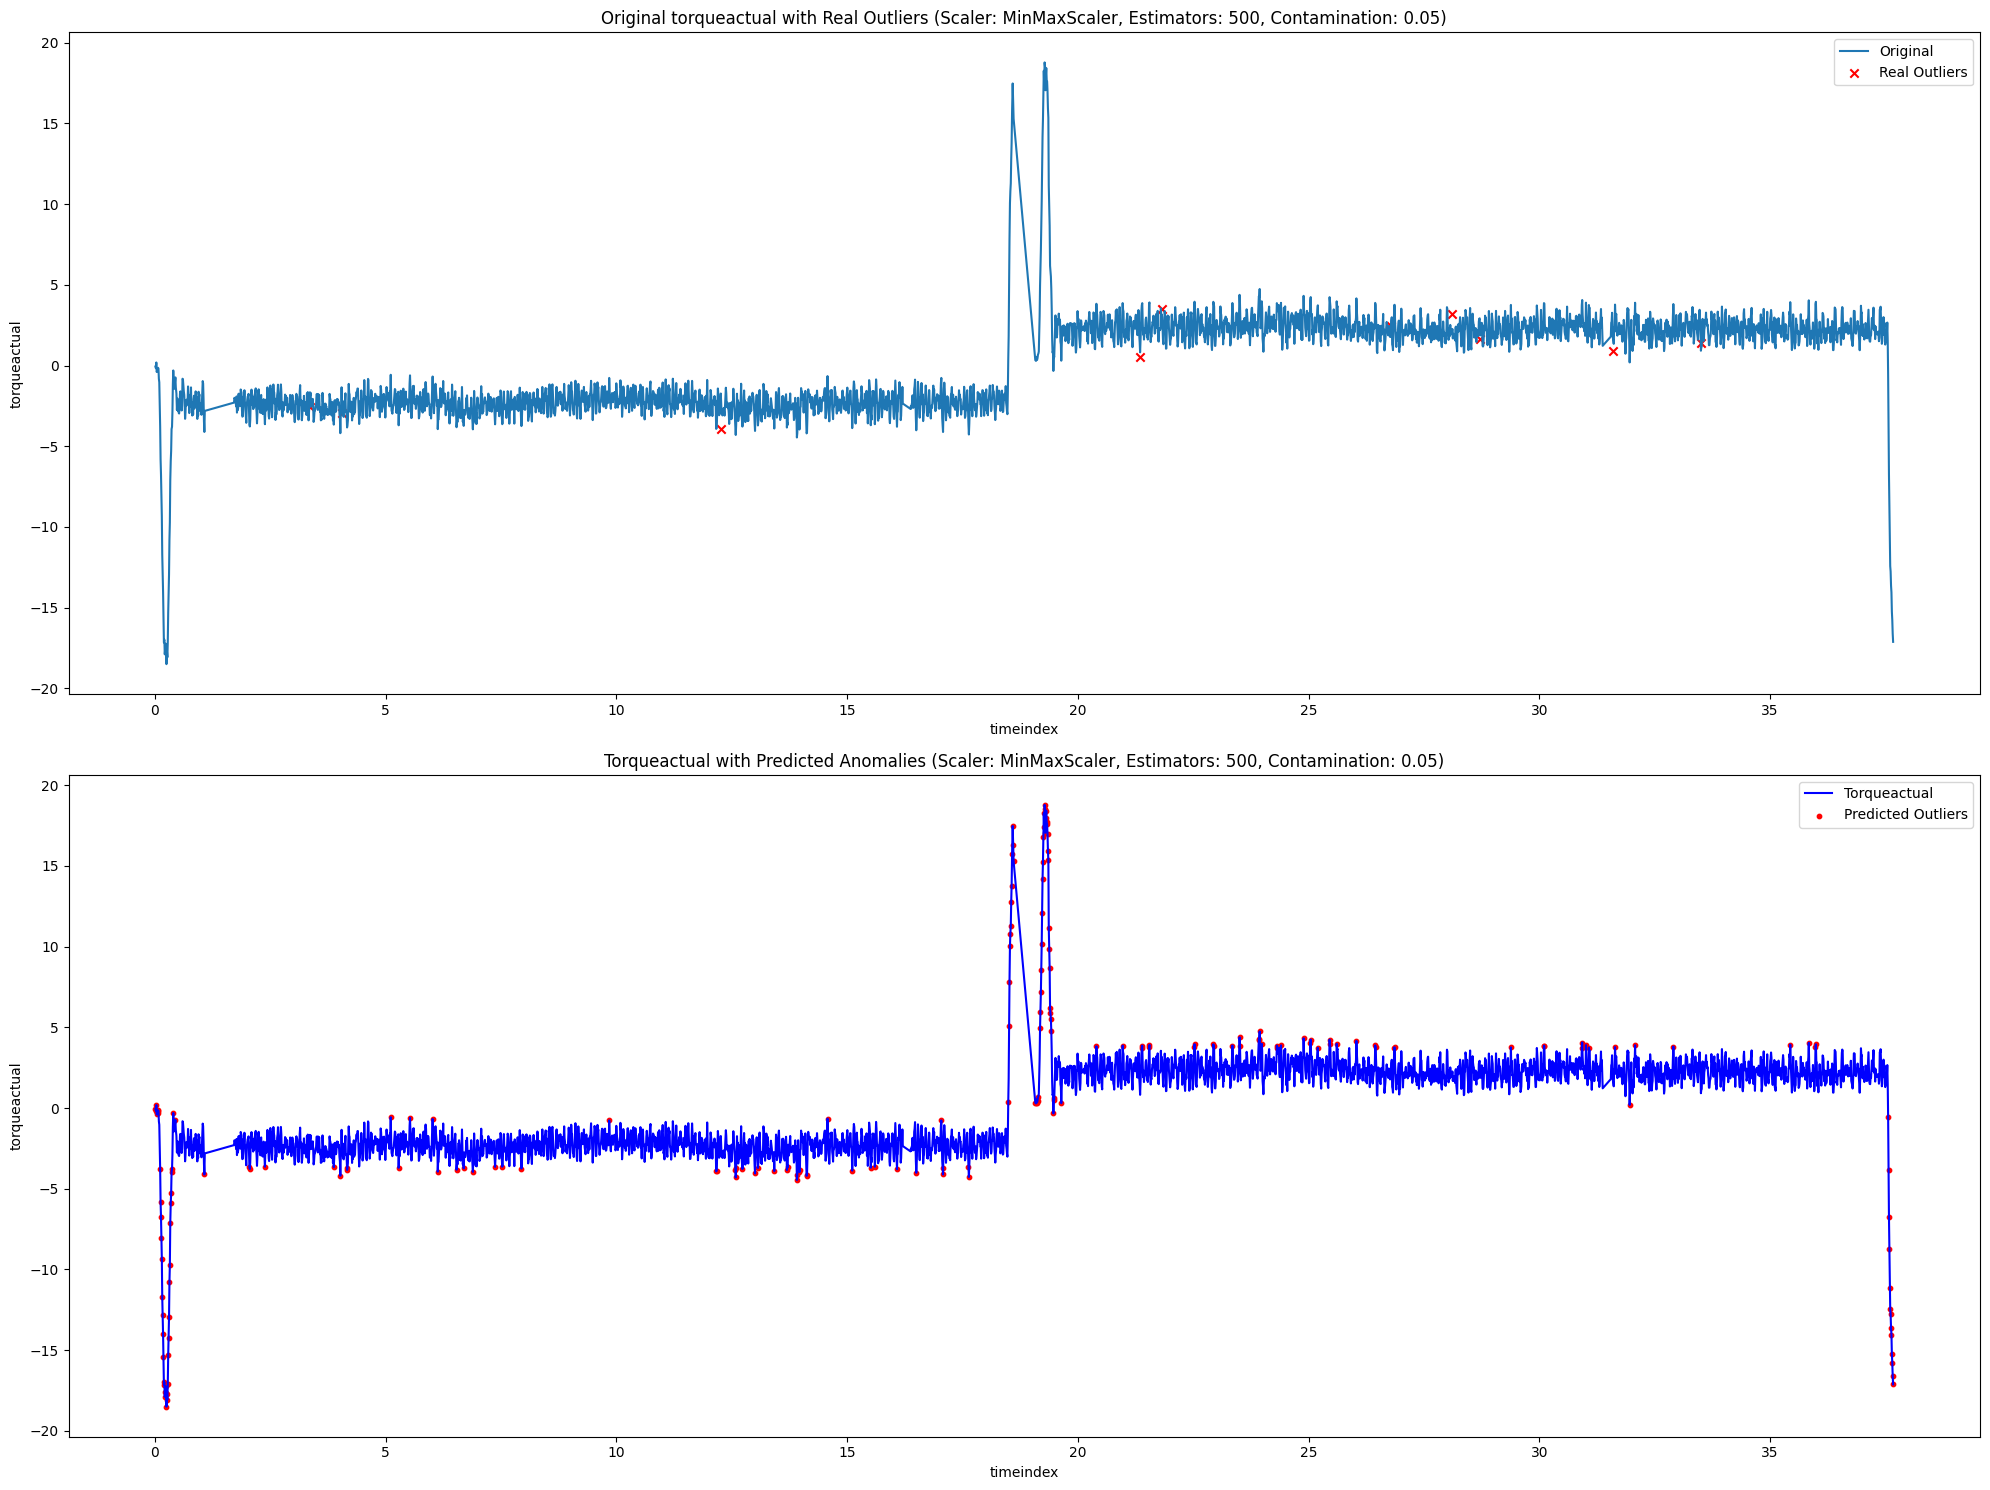

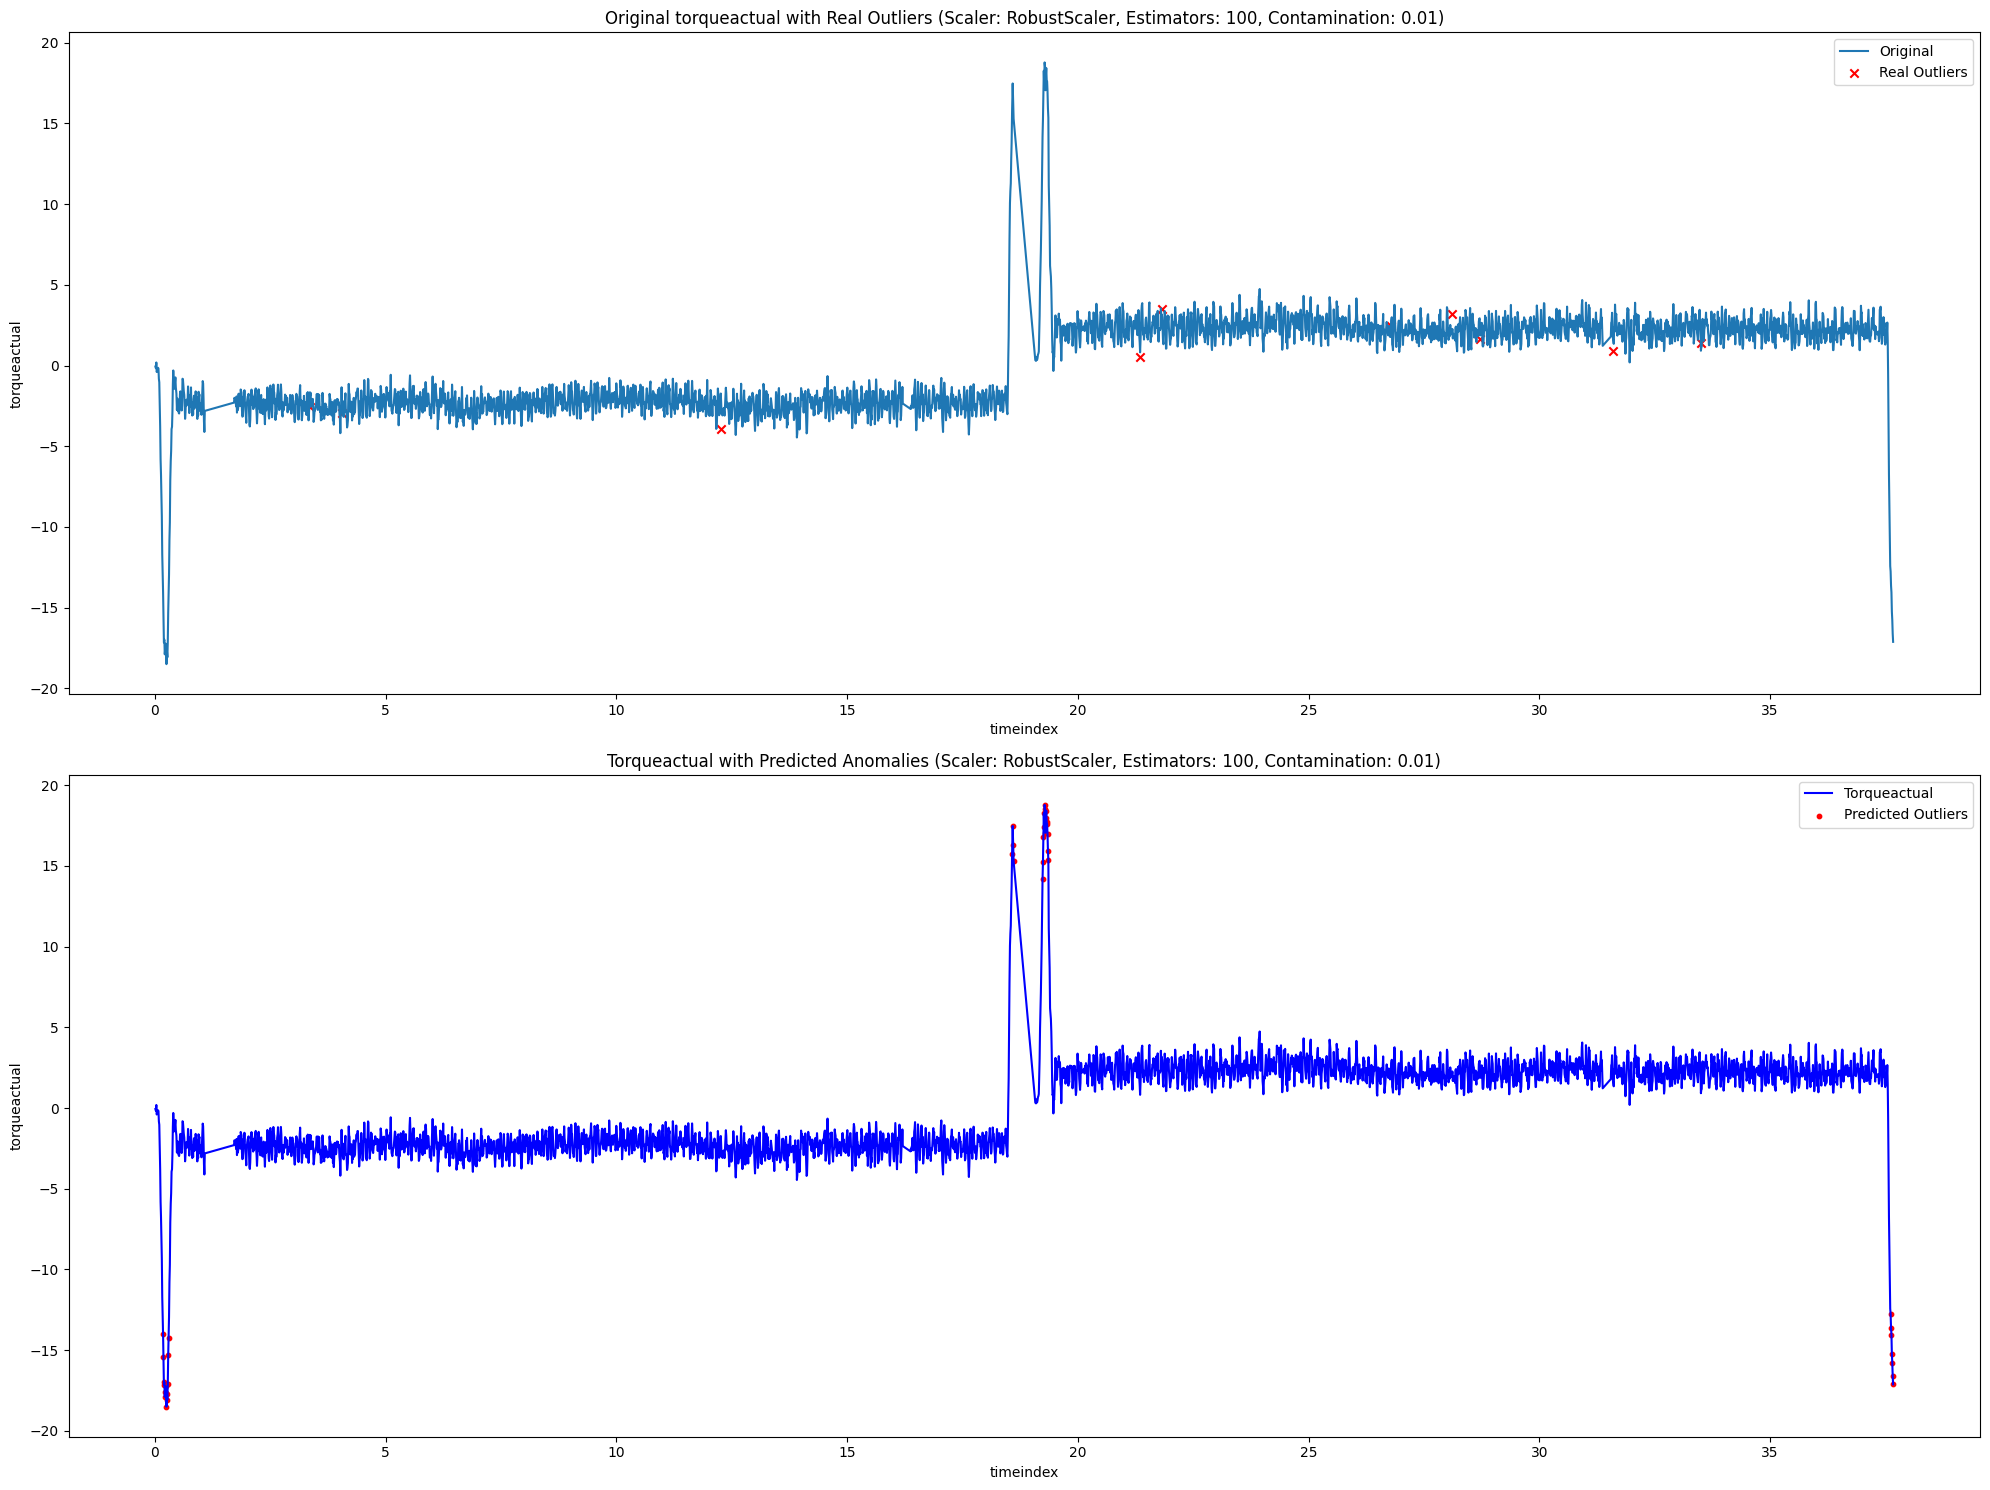

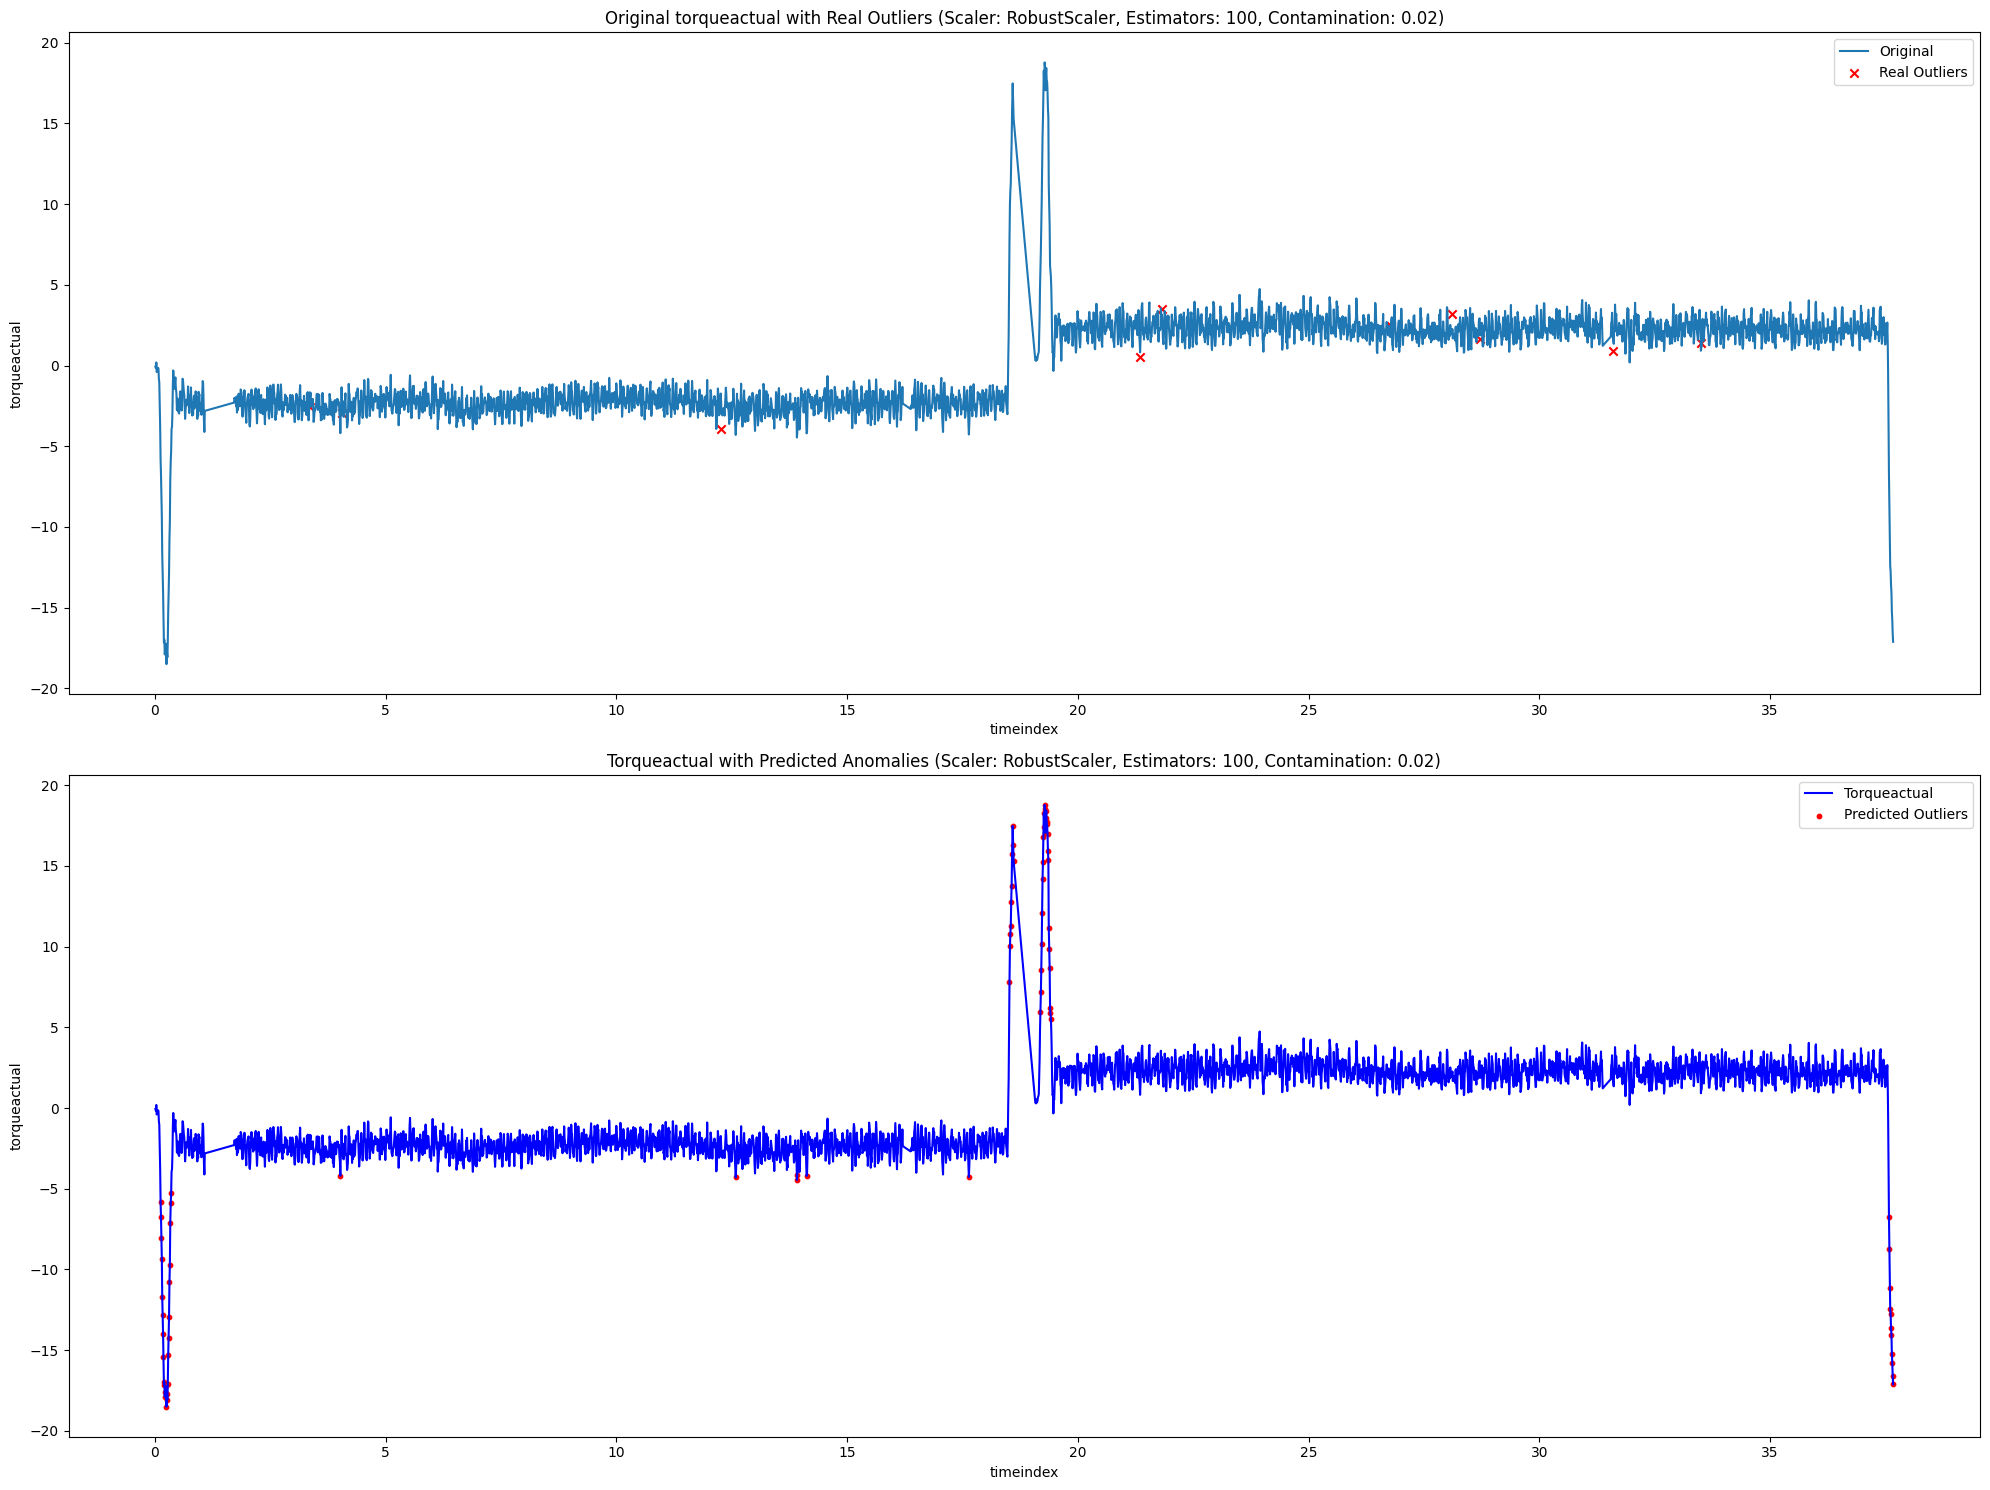

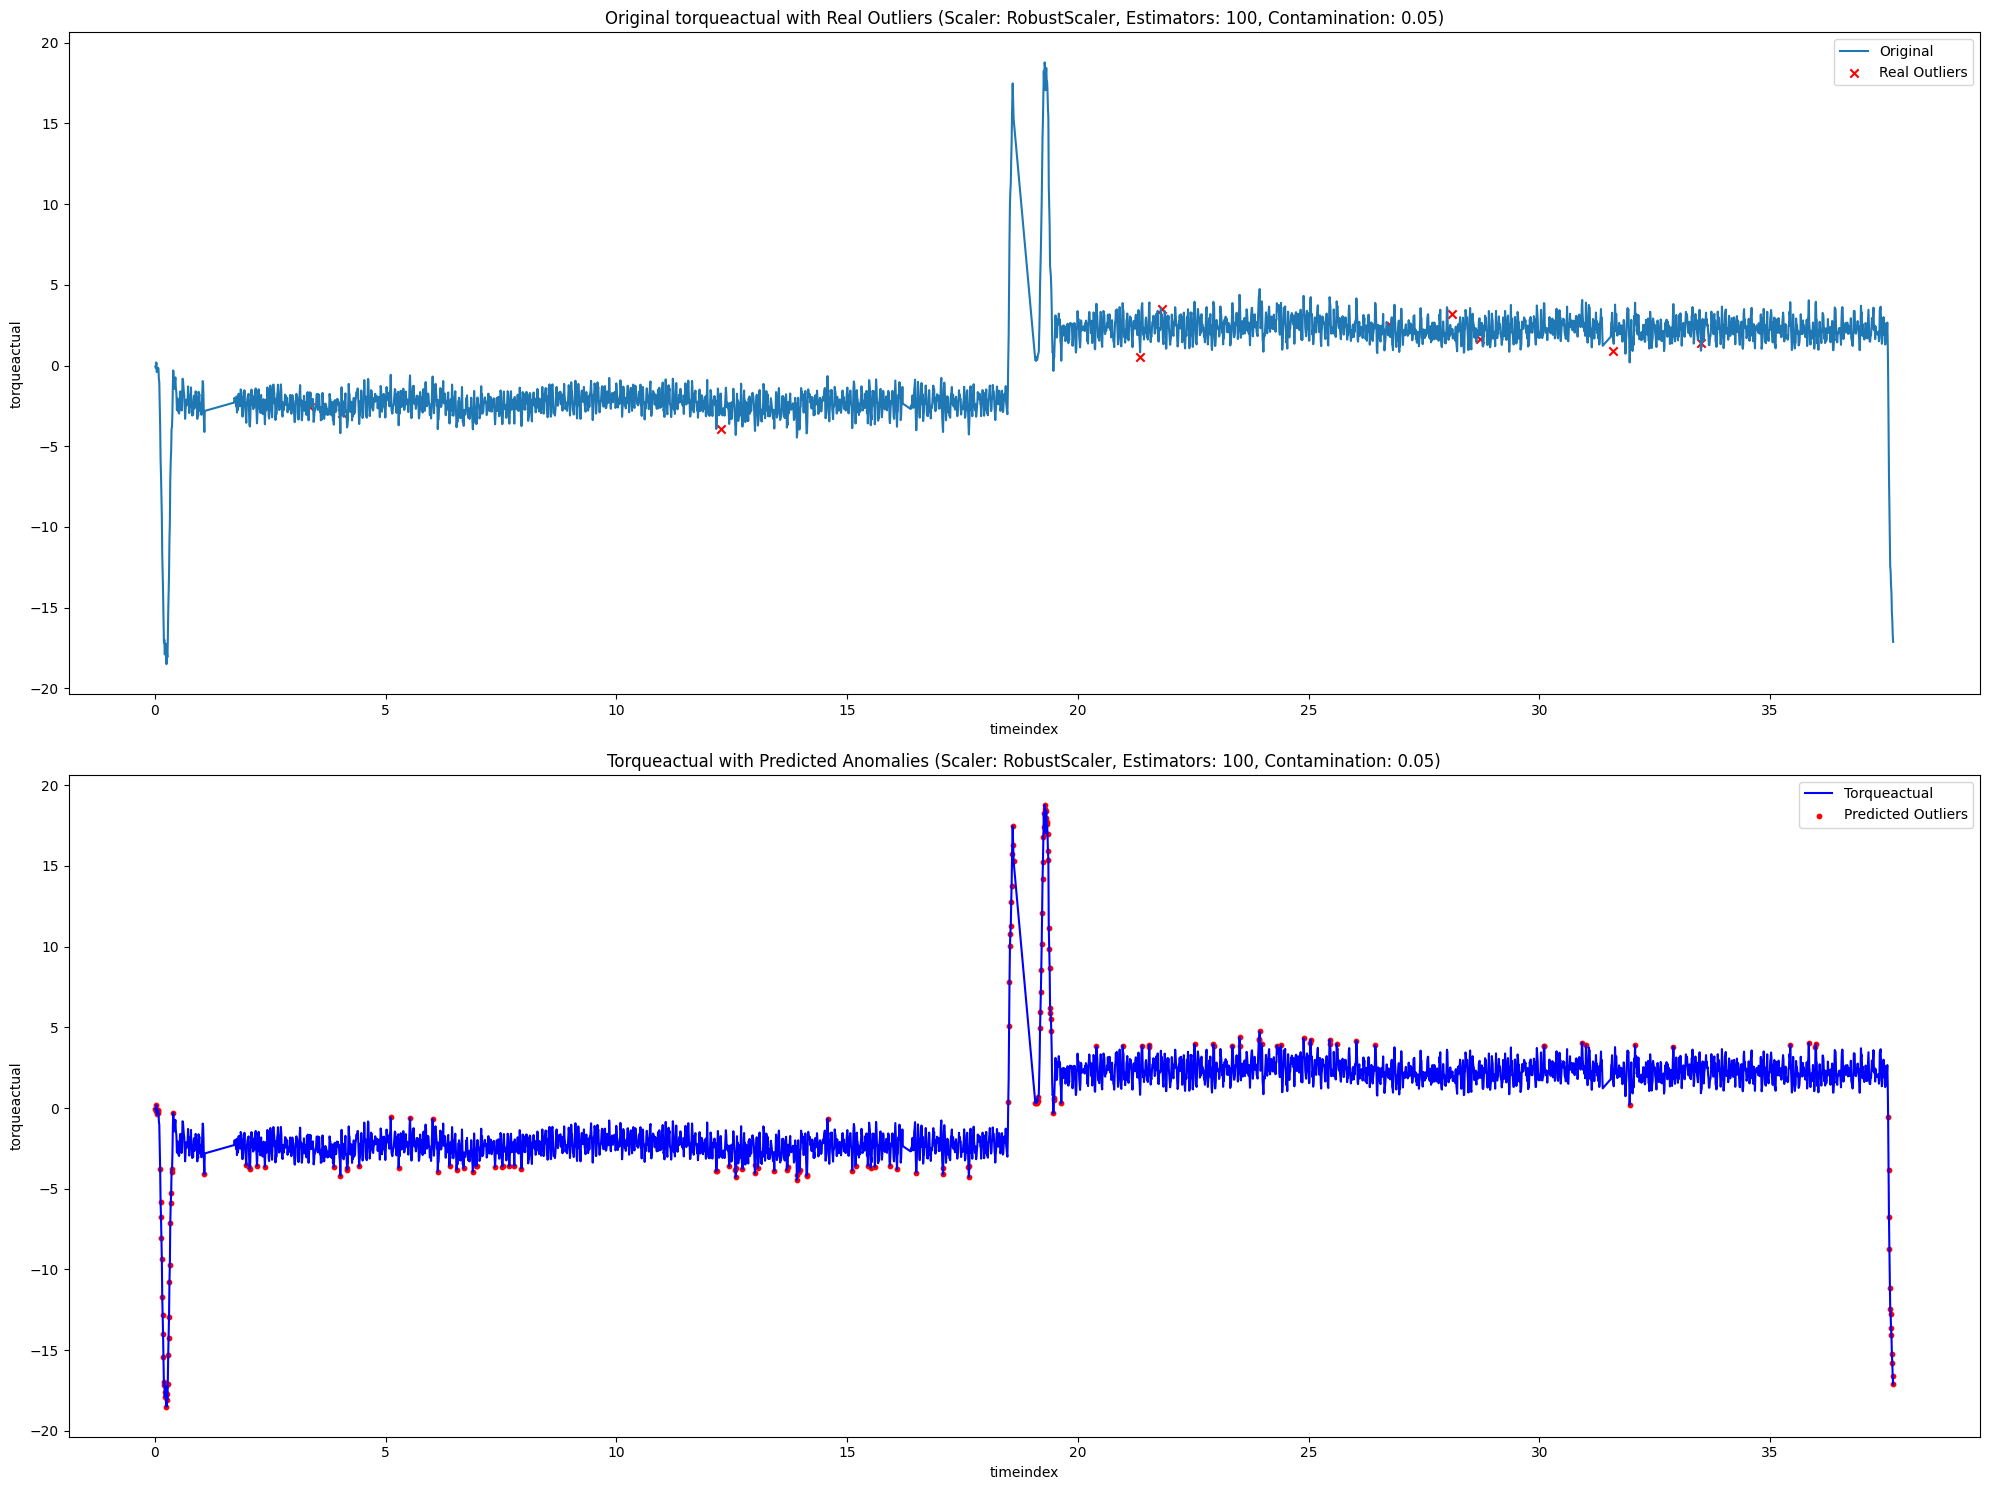

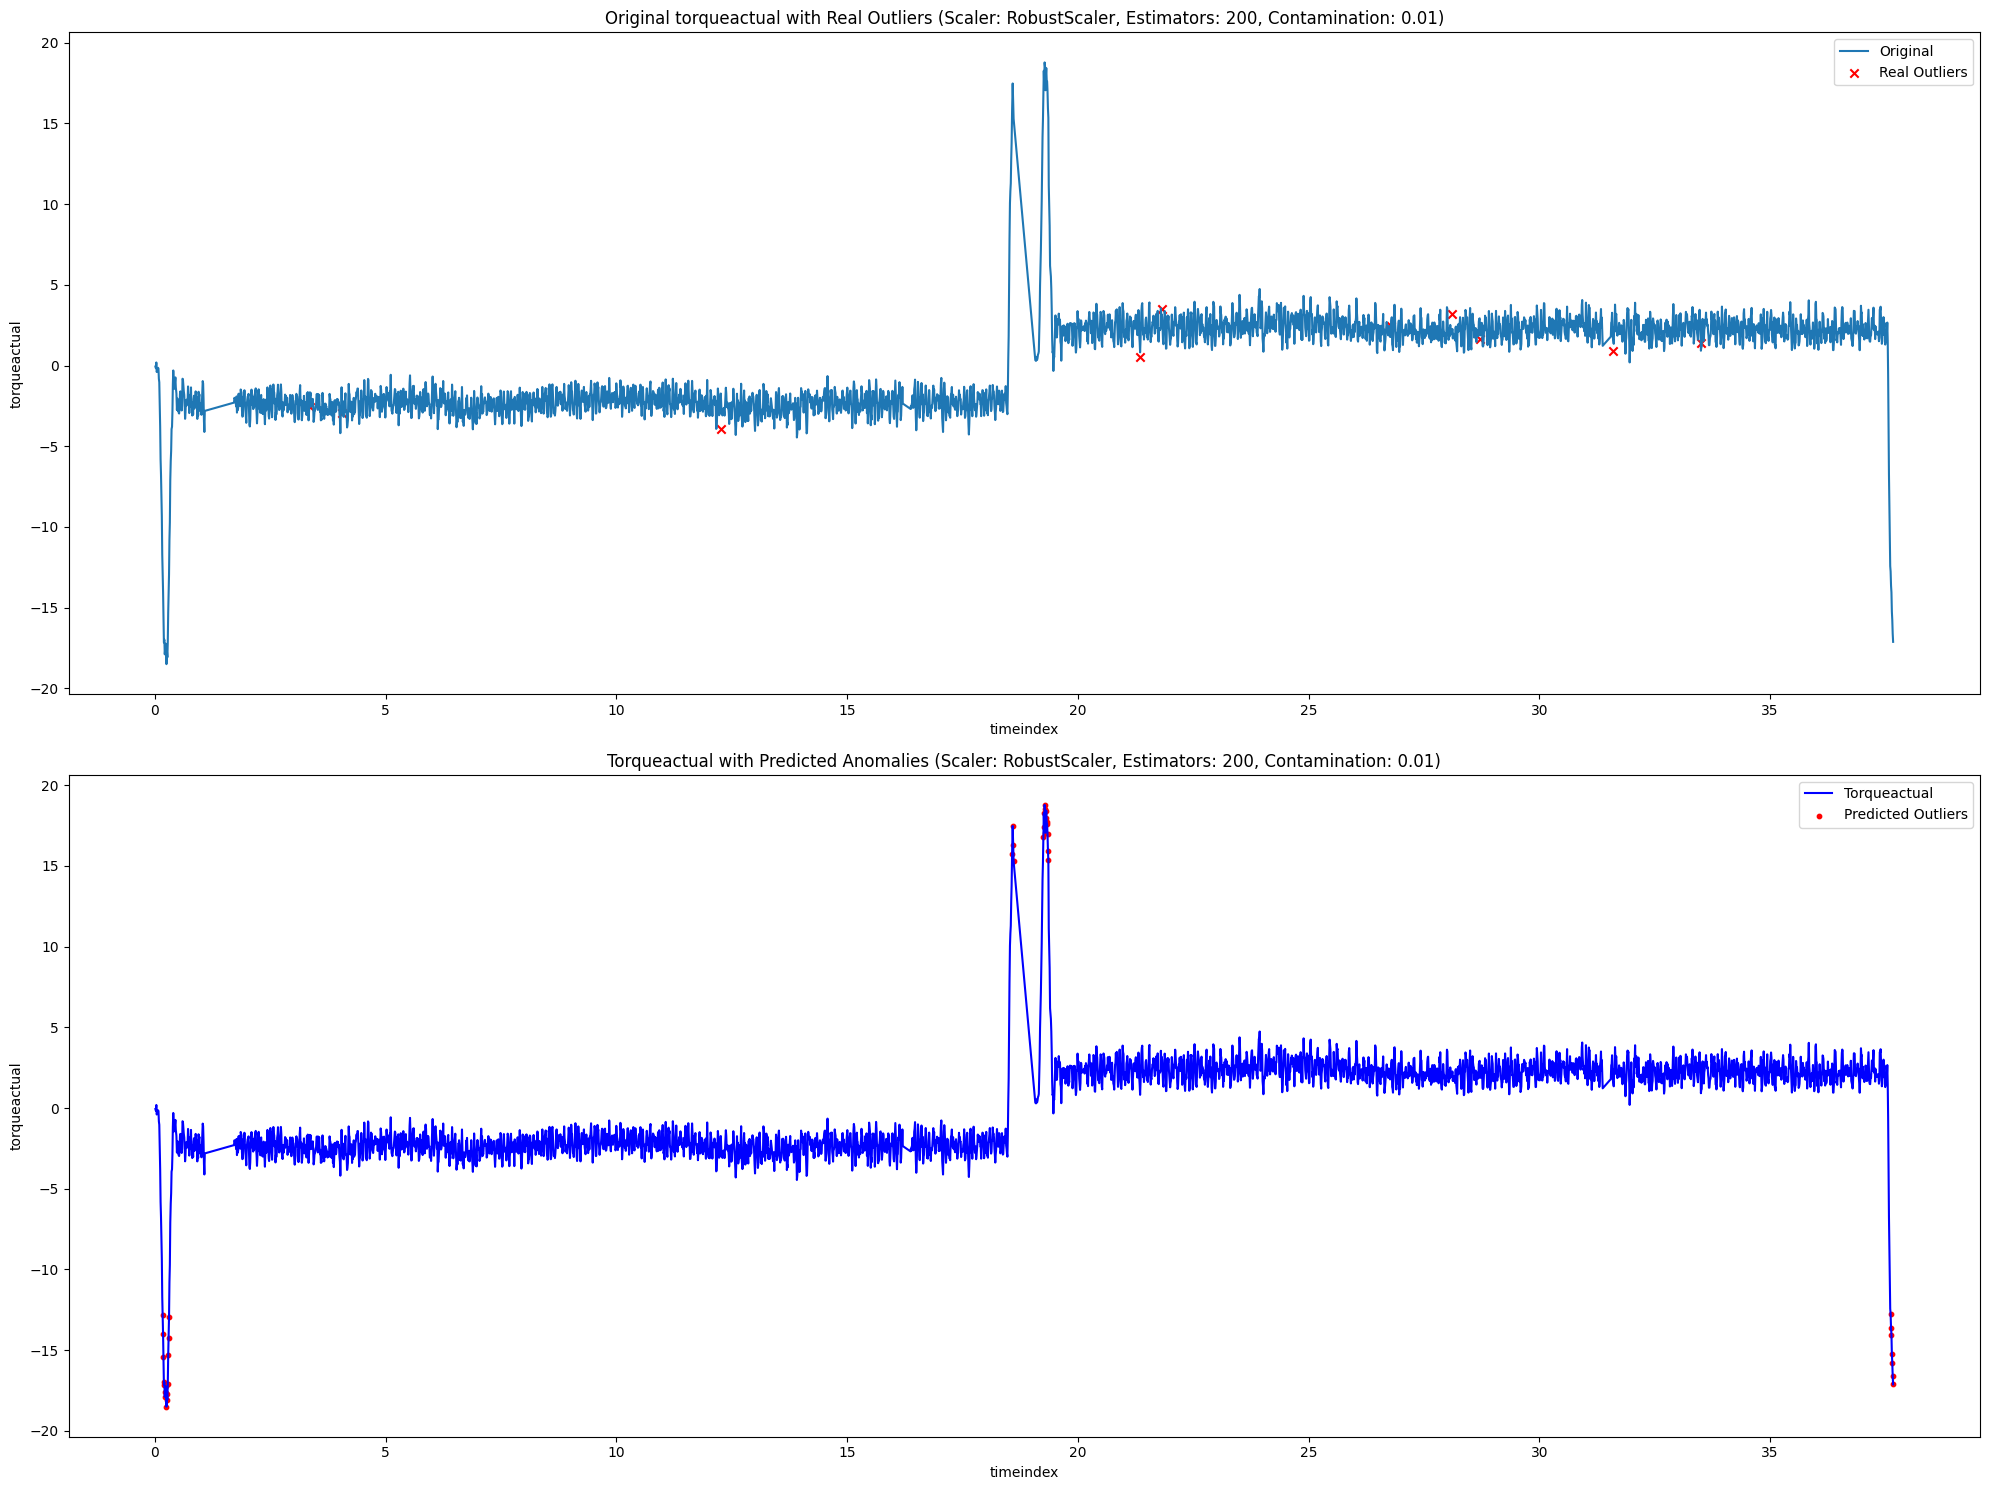

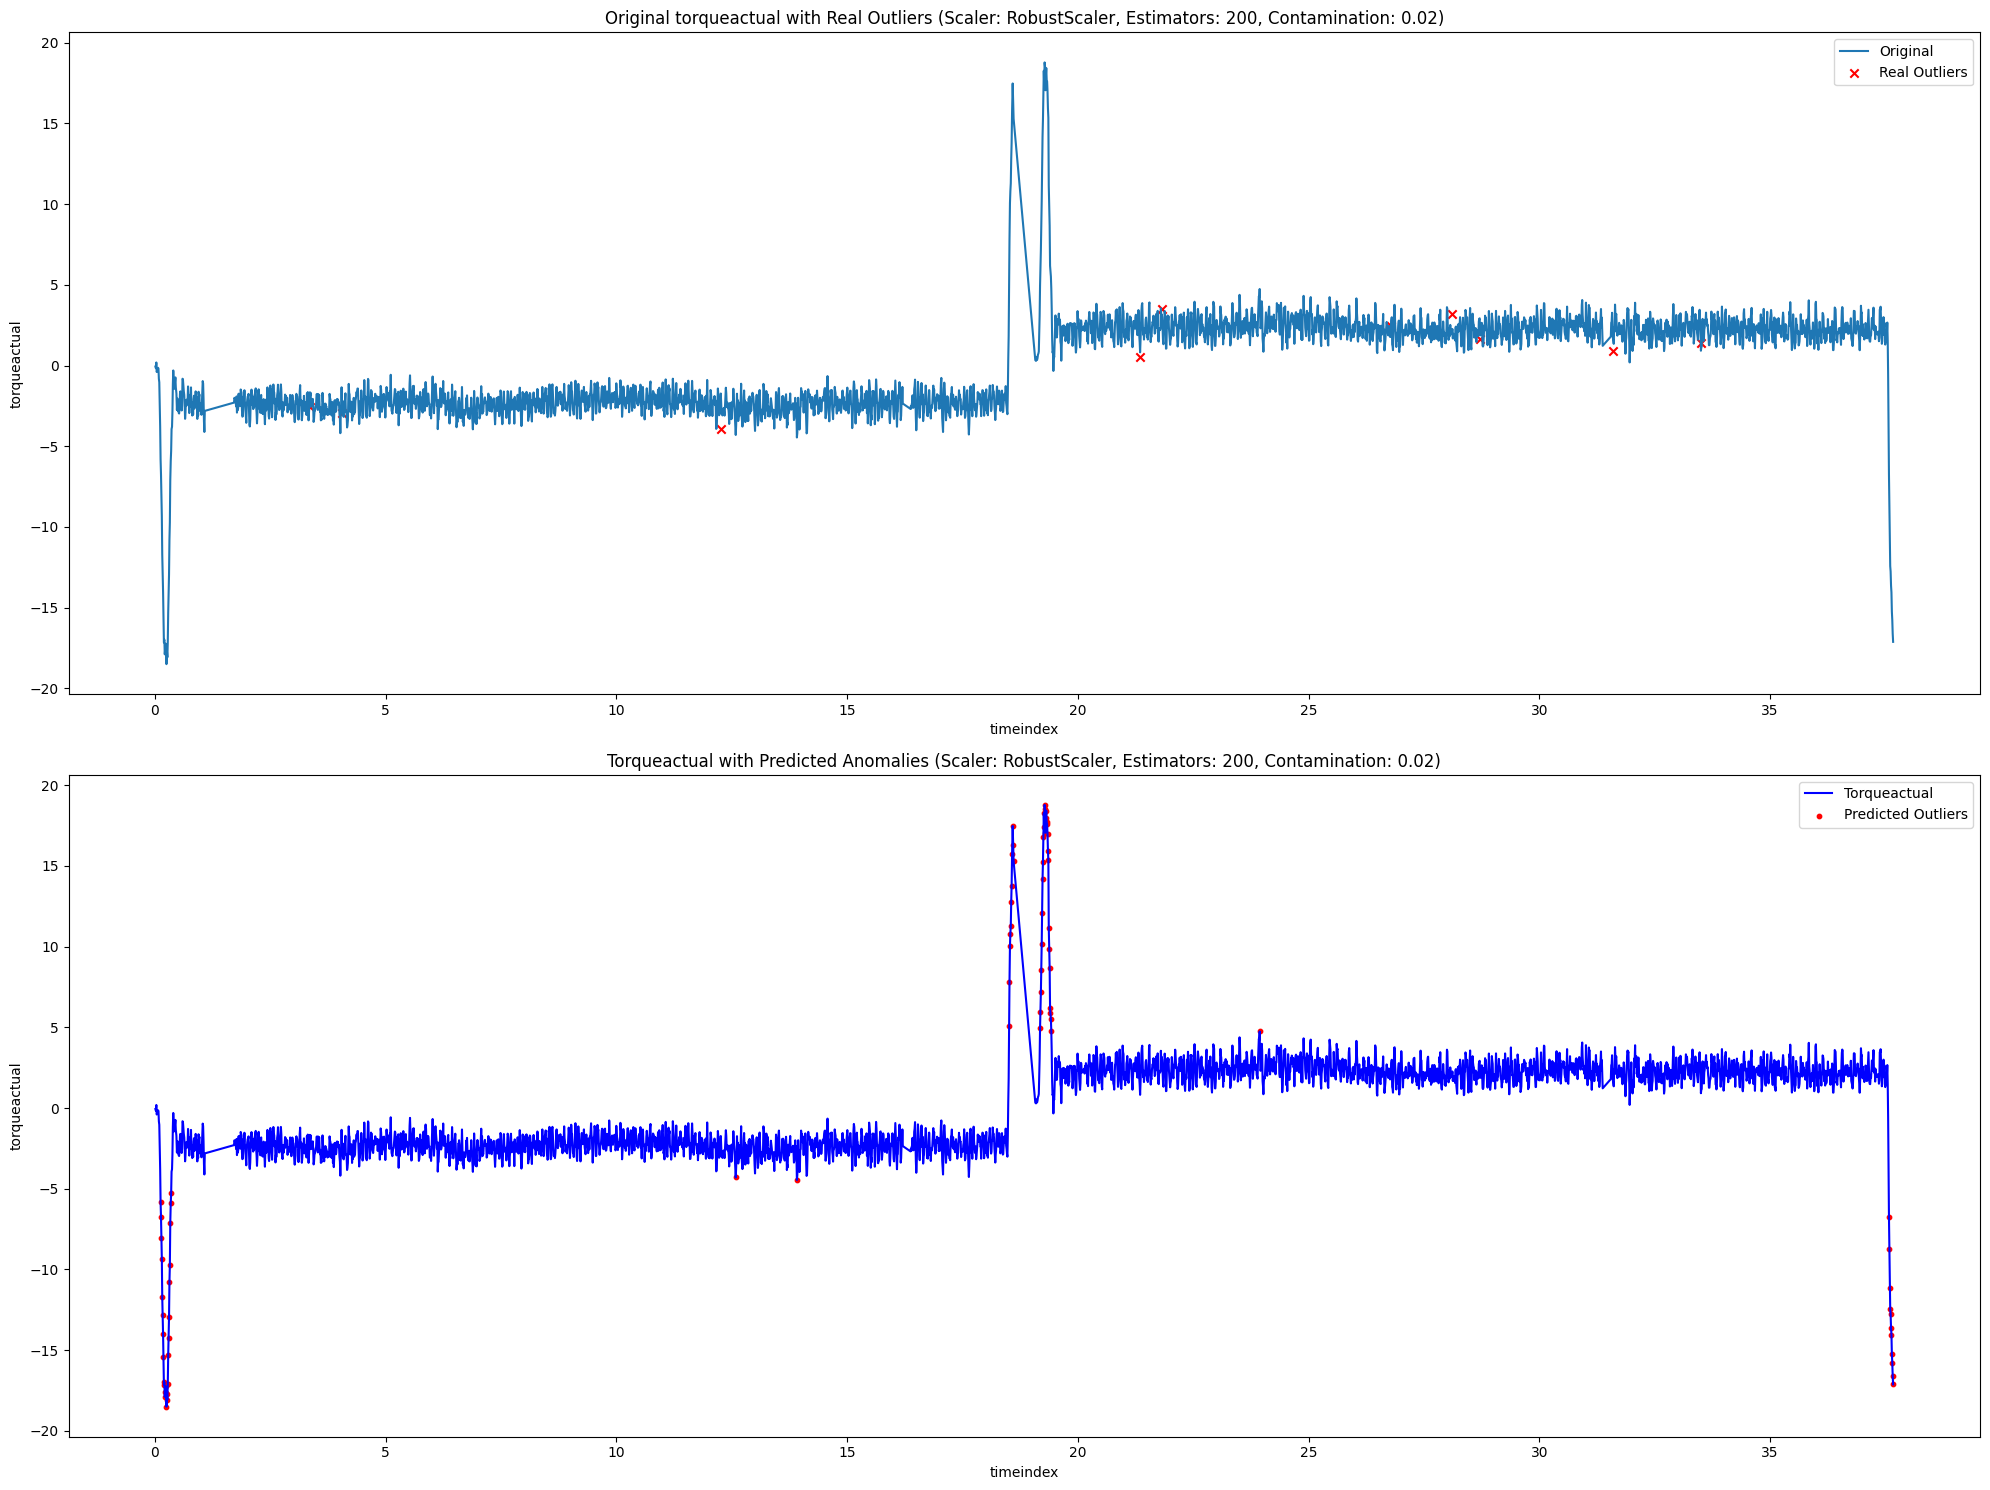

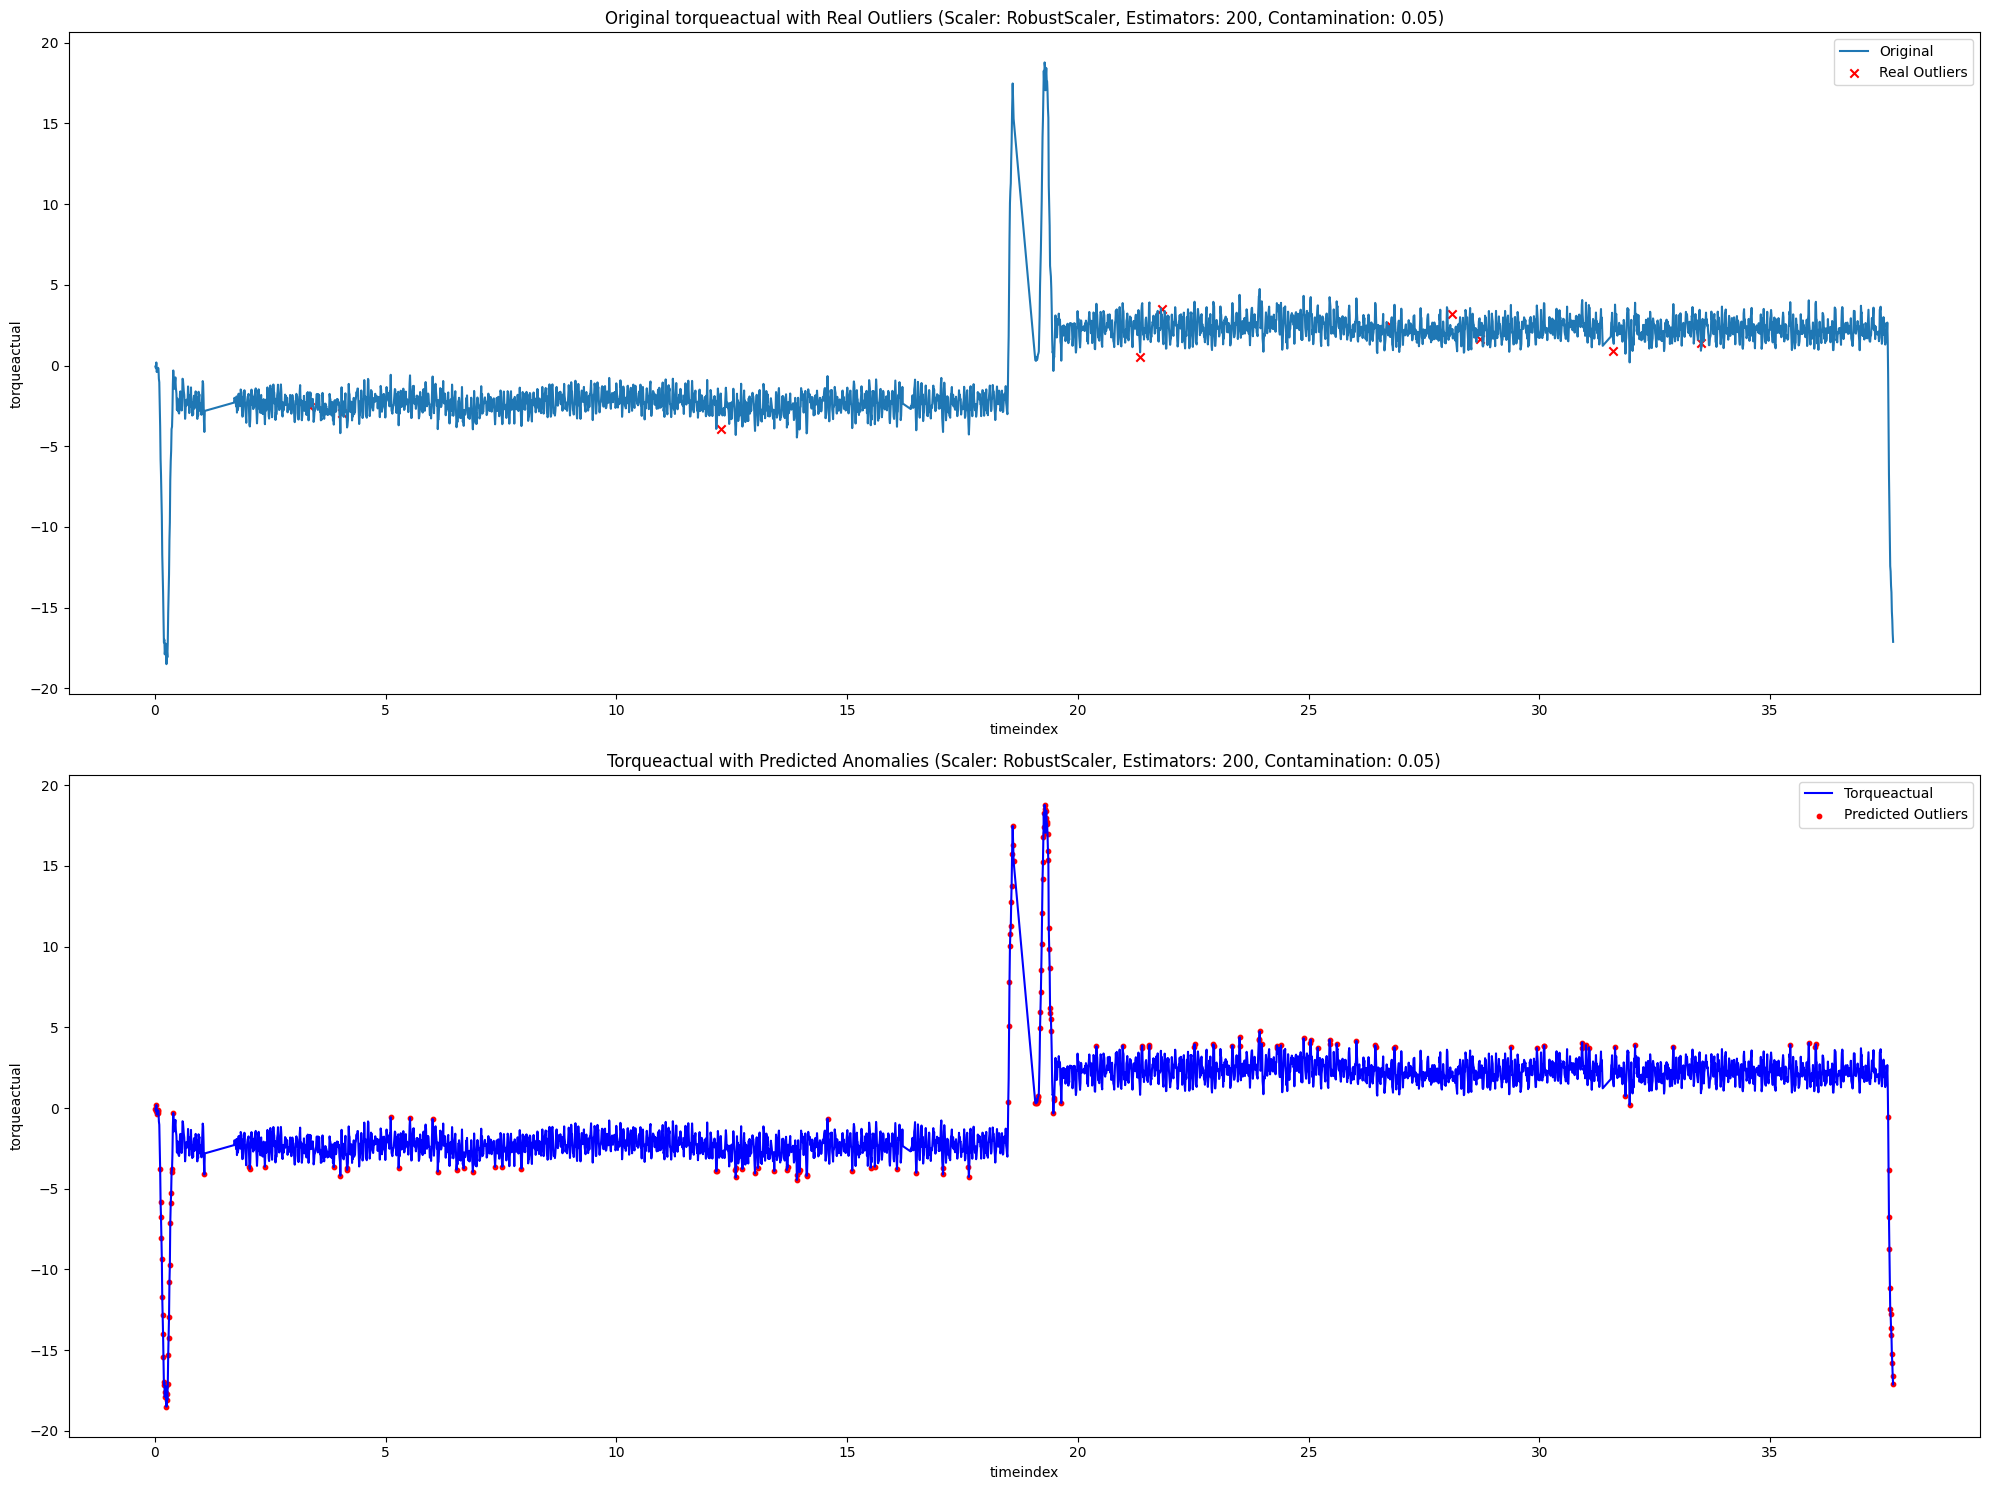

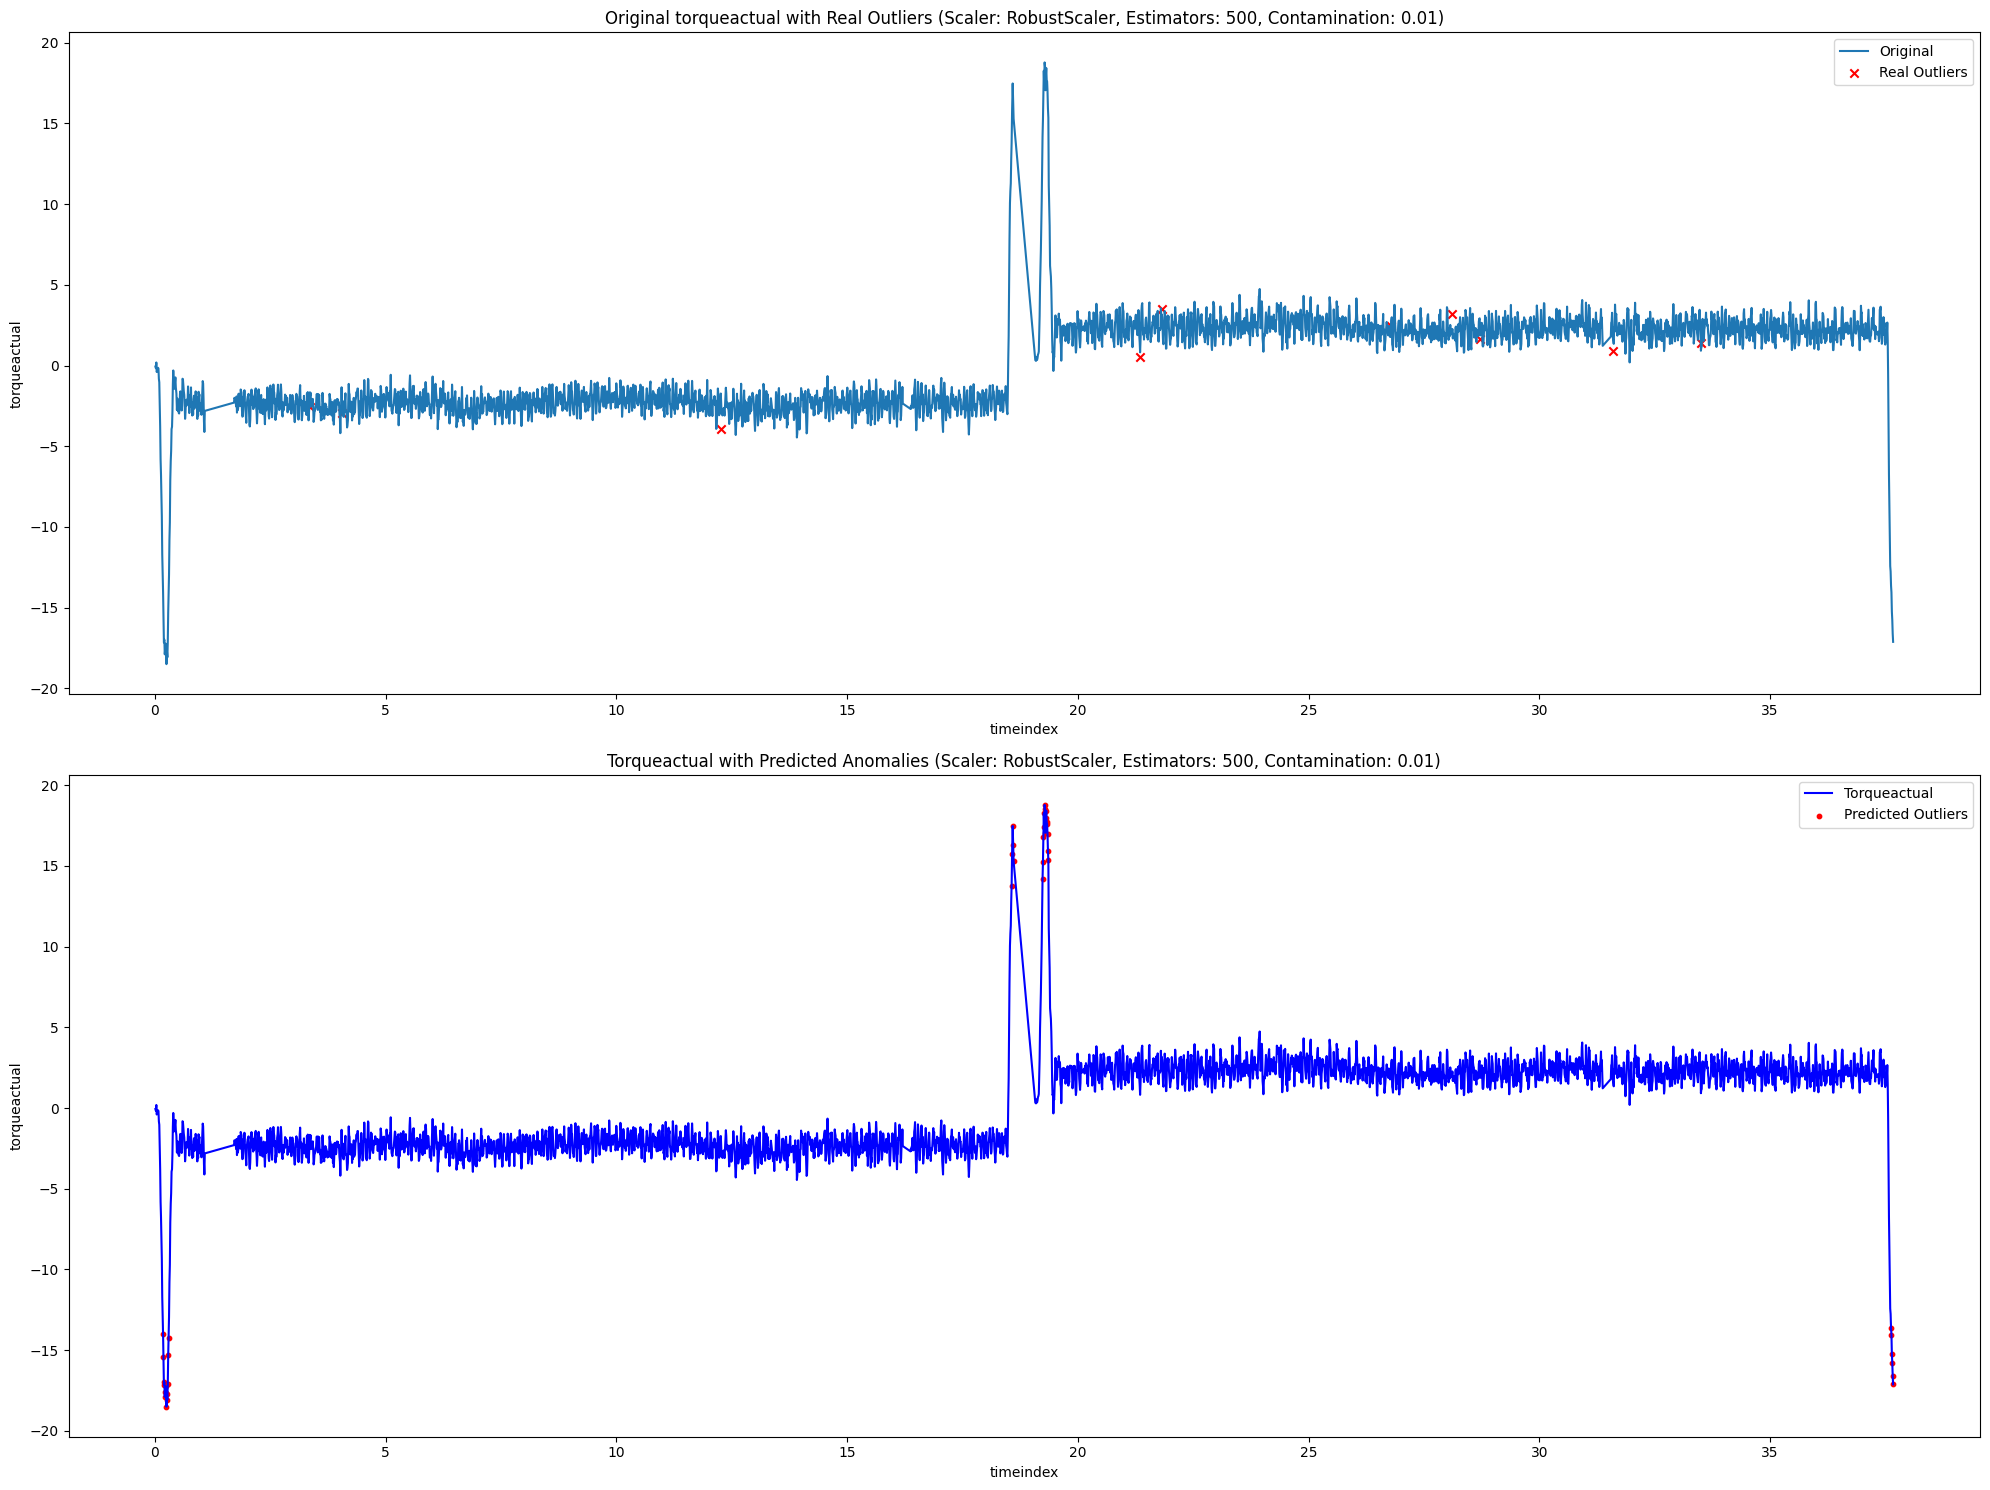

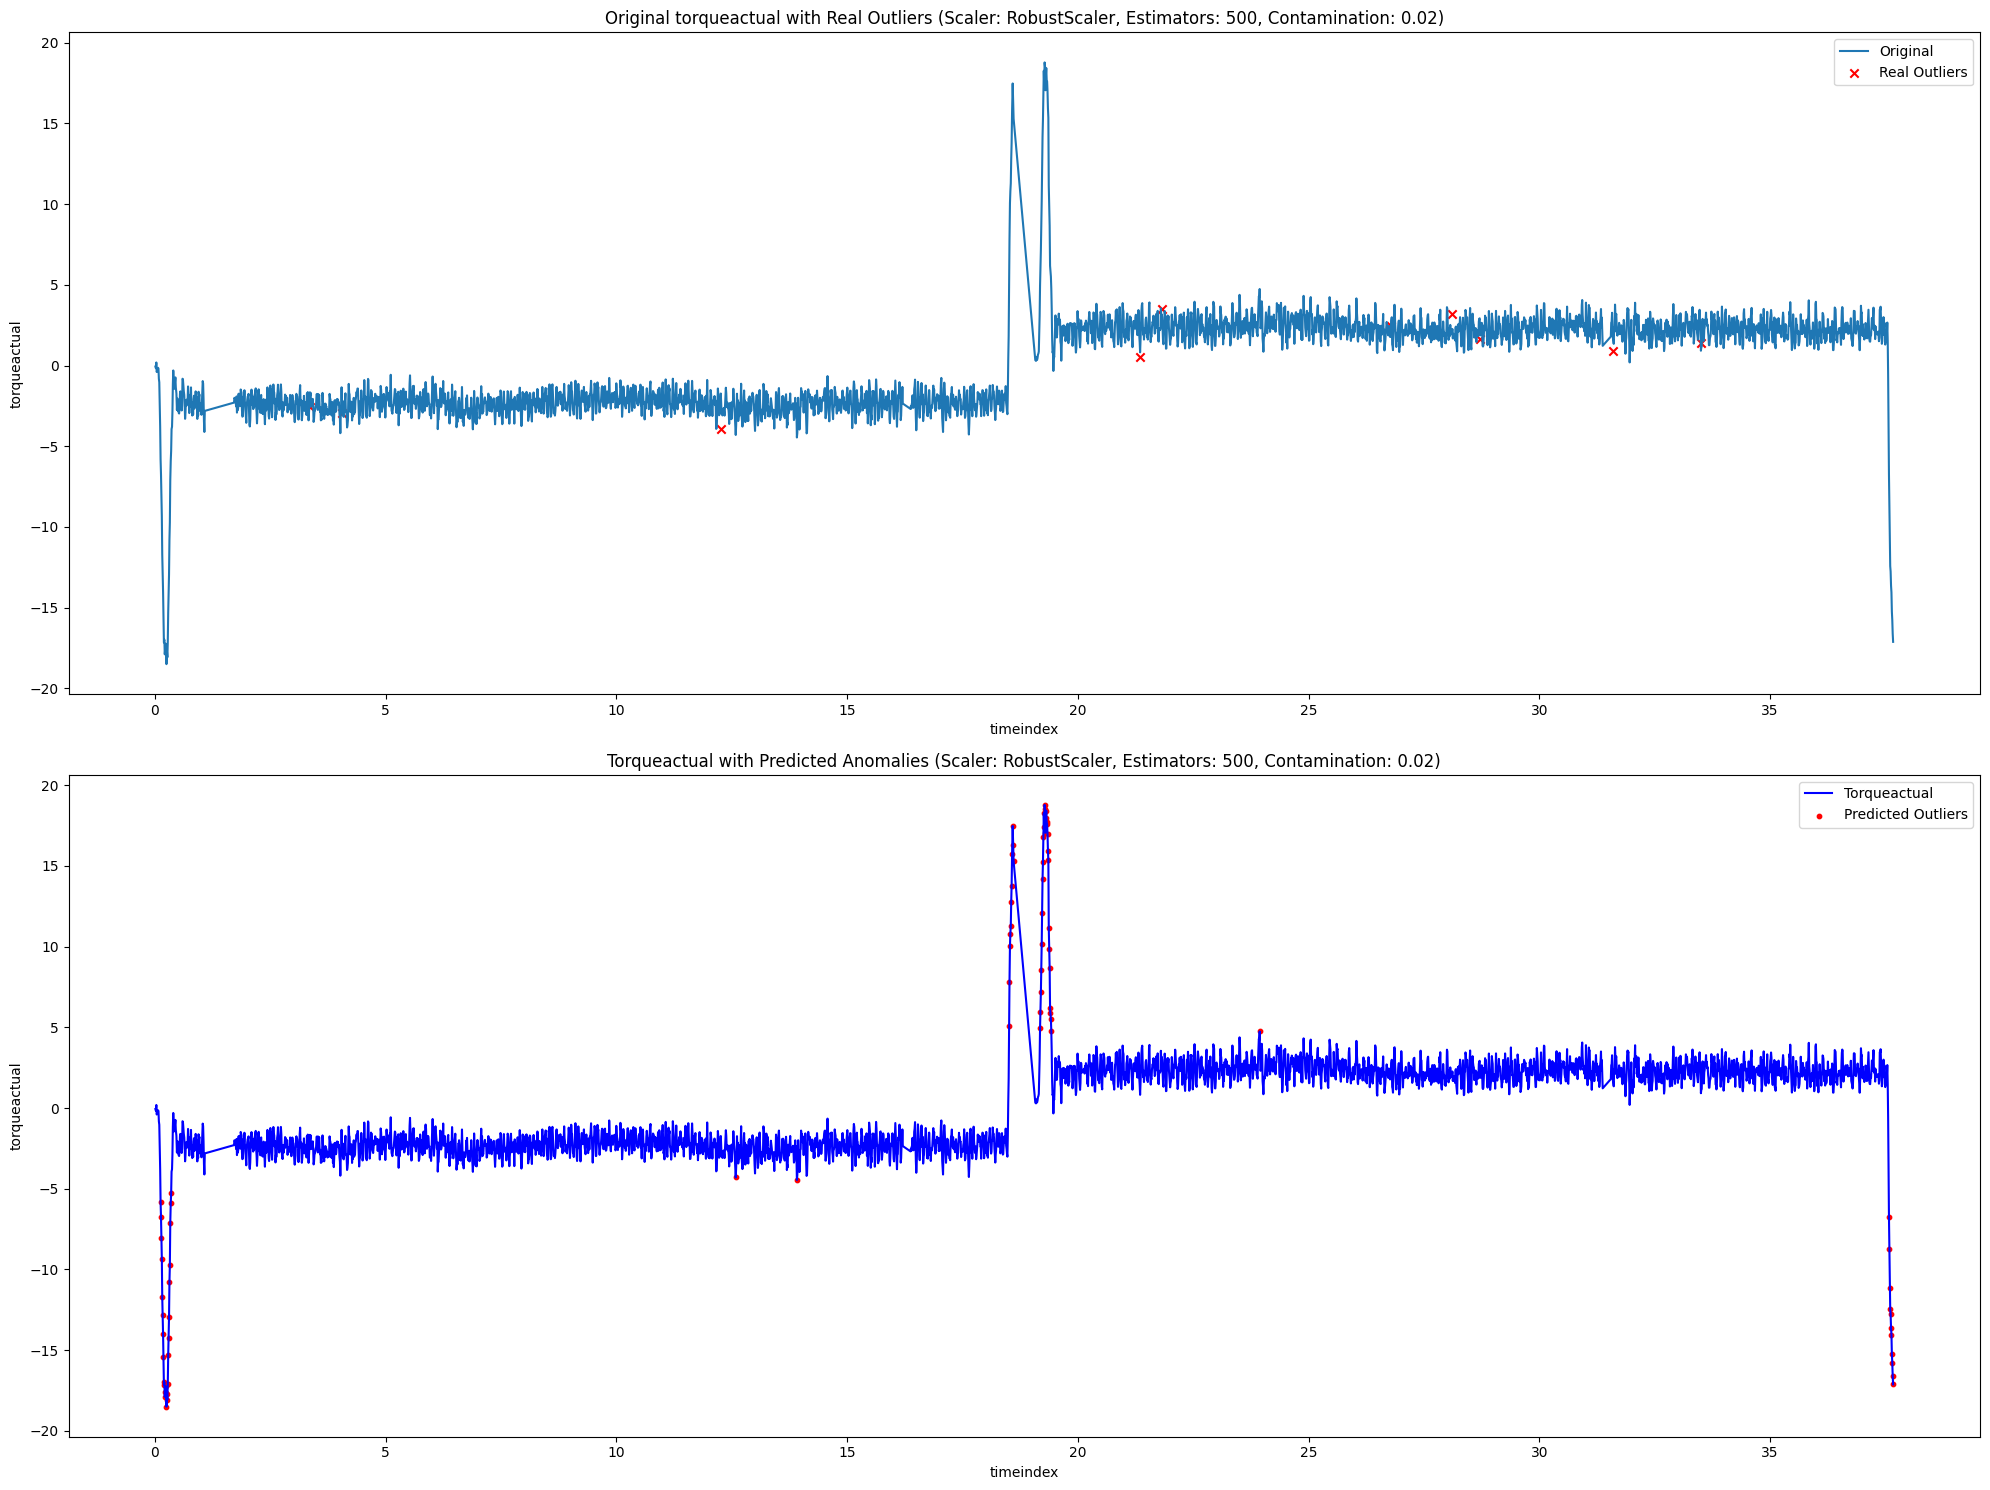

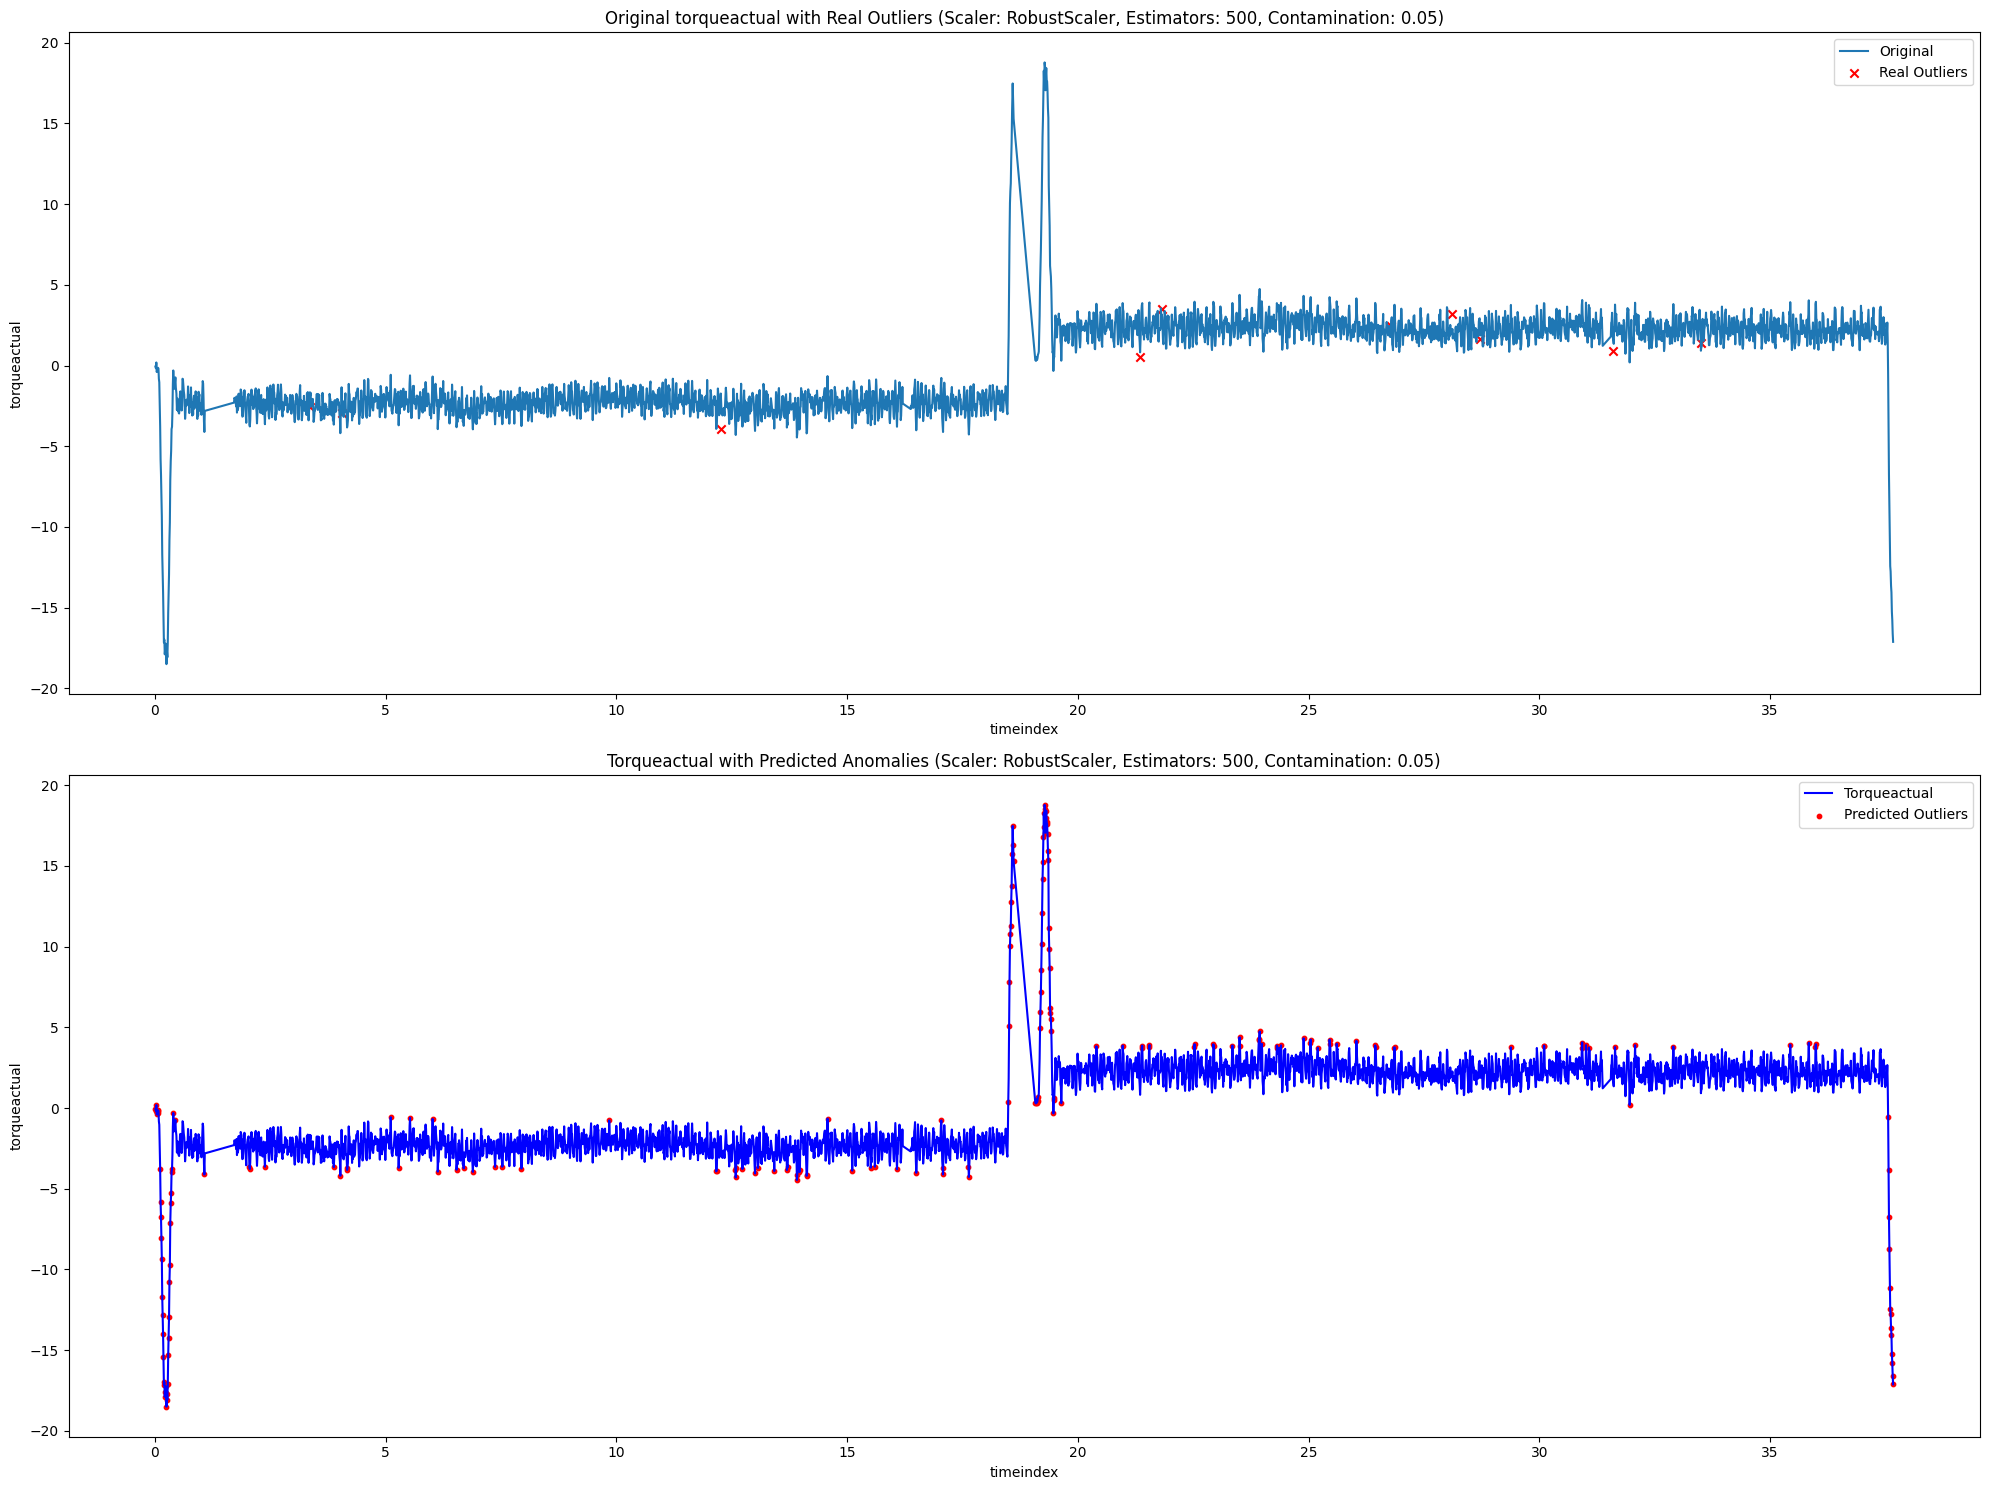

In [13]:
# Function to train and plot results
def train_and_plot(data, features, scaler, n_estimators, contamination, random_state):
    # Normalize the features
    scaled_features = scaler.fit_transform(features)

    # Train Isolation Forest on the normalized features
    iso_forest = IsolationForest(n_estimators=n_estimators, contamination=contamination, random_state=random_state)
    iso_forest.fit(scaled_features)

    # Predict anomalies
    data['outlier'] = iso_forest.predict(scaled_features)

    # Separate inliers and outliers for plotting
    outliers = data[data['outlier'] == -1]

    # Plotting torqueactual against timeindex
    plt.figure(figsize=(20, 15))

    # Plot original torqueactual with real anomalies
    plt.subplot(2, 1, 1)
    plt.plot(data['timeindex'], data['torqueactual'], label='Original')
    plt.scatter(real_anomalies_point['timeindex'], real_anomalies_point['torqueactual'] + real_anomalies_point['noise'], 
                c='red', label='Real Outliers', marker='x')
    plt.xlabel('timeindex')
    plt.ylabel('torqueactual')
    plt.title(f'Original torqueactual with Real Outliers (Scaler: {scaler.__class__.__name__}, Estimators: {n_estimators}, Contamination: {contamination})')
    plt.legend()

    # Highlighting detected anomalies in torqueactual
    plt.subplot(2, 1, 2)
    plt.plot(data['timeindex'], data['torqueactual'], label='Torqueactual', color='blue')
    plt.scatter(outliers['timeindex'], outliers['torqueactual'], color='red', s=10, label='Predicted Outliers')
    plt.title(f'Torqueactual with Predicted Anomalies (Scaler: {scaler.__class__.__name__}, Estimators: {n_estimators}, Contamination: {contamination})')
    plt.xlabel('timeindex')
    plt.ylabel('torqueactual')
    plt.legend()

    plt.tight_layout()
    plt.show()

# Iterate over all combinations of scalers and parameters
for scaler, (n_estimators, contamination, random_state) in product(scalers, product(params['n_estimators'], params['contamination'], params['random_state'])):
    train_and_plot(data_point, features_point, scaler, n_estimators, contamination, random_state)


# Gaussian Noise Anomaly

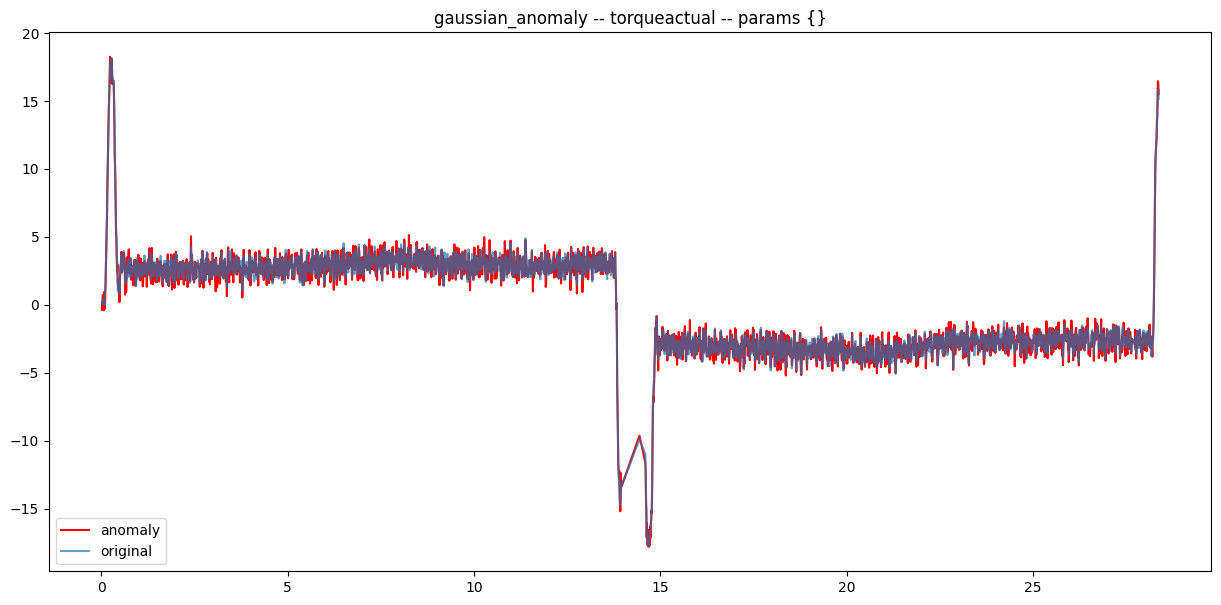

In [14]:
data_gauss = get_rand_sequence()

std = 0.4

data_gauss = NoiseMachine.gaussian_anomaly(data_gauss, std=std)
NoiseMachine.plot(data_gauss, column="torqueactual")

In [15]:
# Extract features for training
features_gauss = data_gauss[['torqueactual']].values

In [16]:
# Normalize the features
scaler = StandardScaler()
scaled_features = scaler.fit_transform(features_gauss)

# Train Isolation Forest on the normalized features
iso_forest = IsolationForest(n_estimators=500, contamination=0.02, random_state=42)
iso_forest.fit(scaled_features)

IsolationForest(contamination=0.02, n_estimators=500, random_state=42)

In [17]:
data_gauss['outlier'] = iso_forest.predict(scaled_features)

In [18]:
real_anomalies_gauss = data_gauss[data_gauss['noise'] != 0]

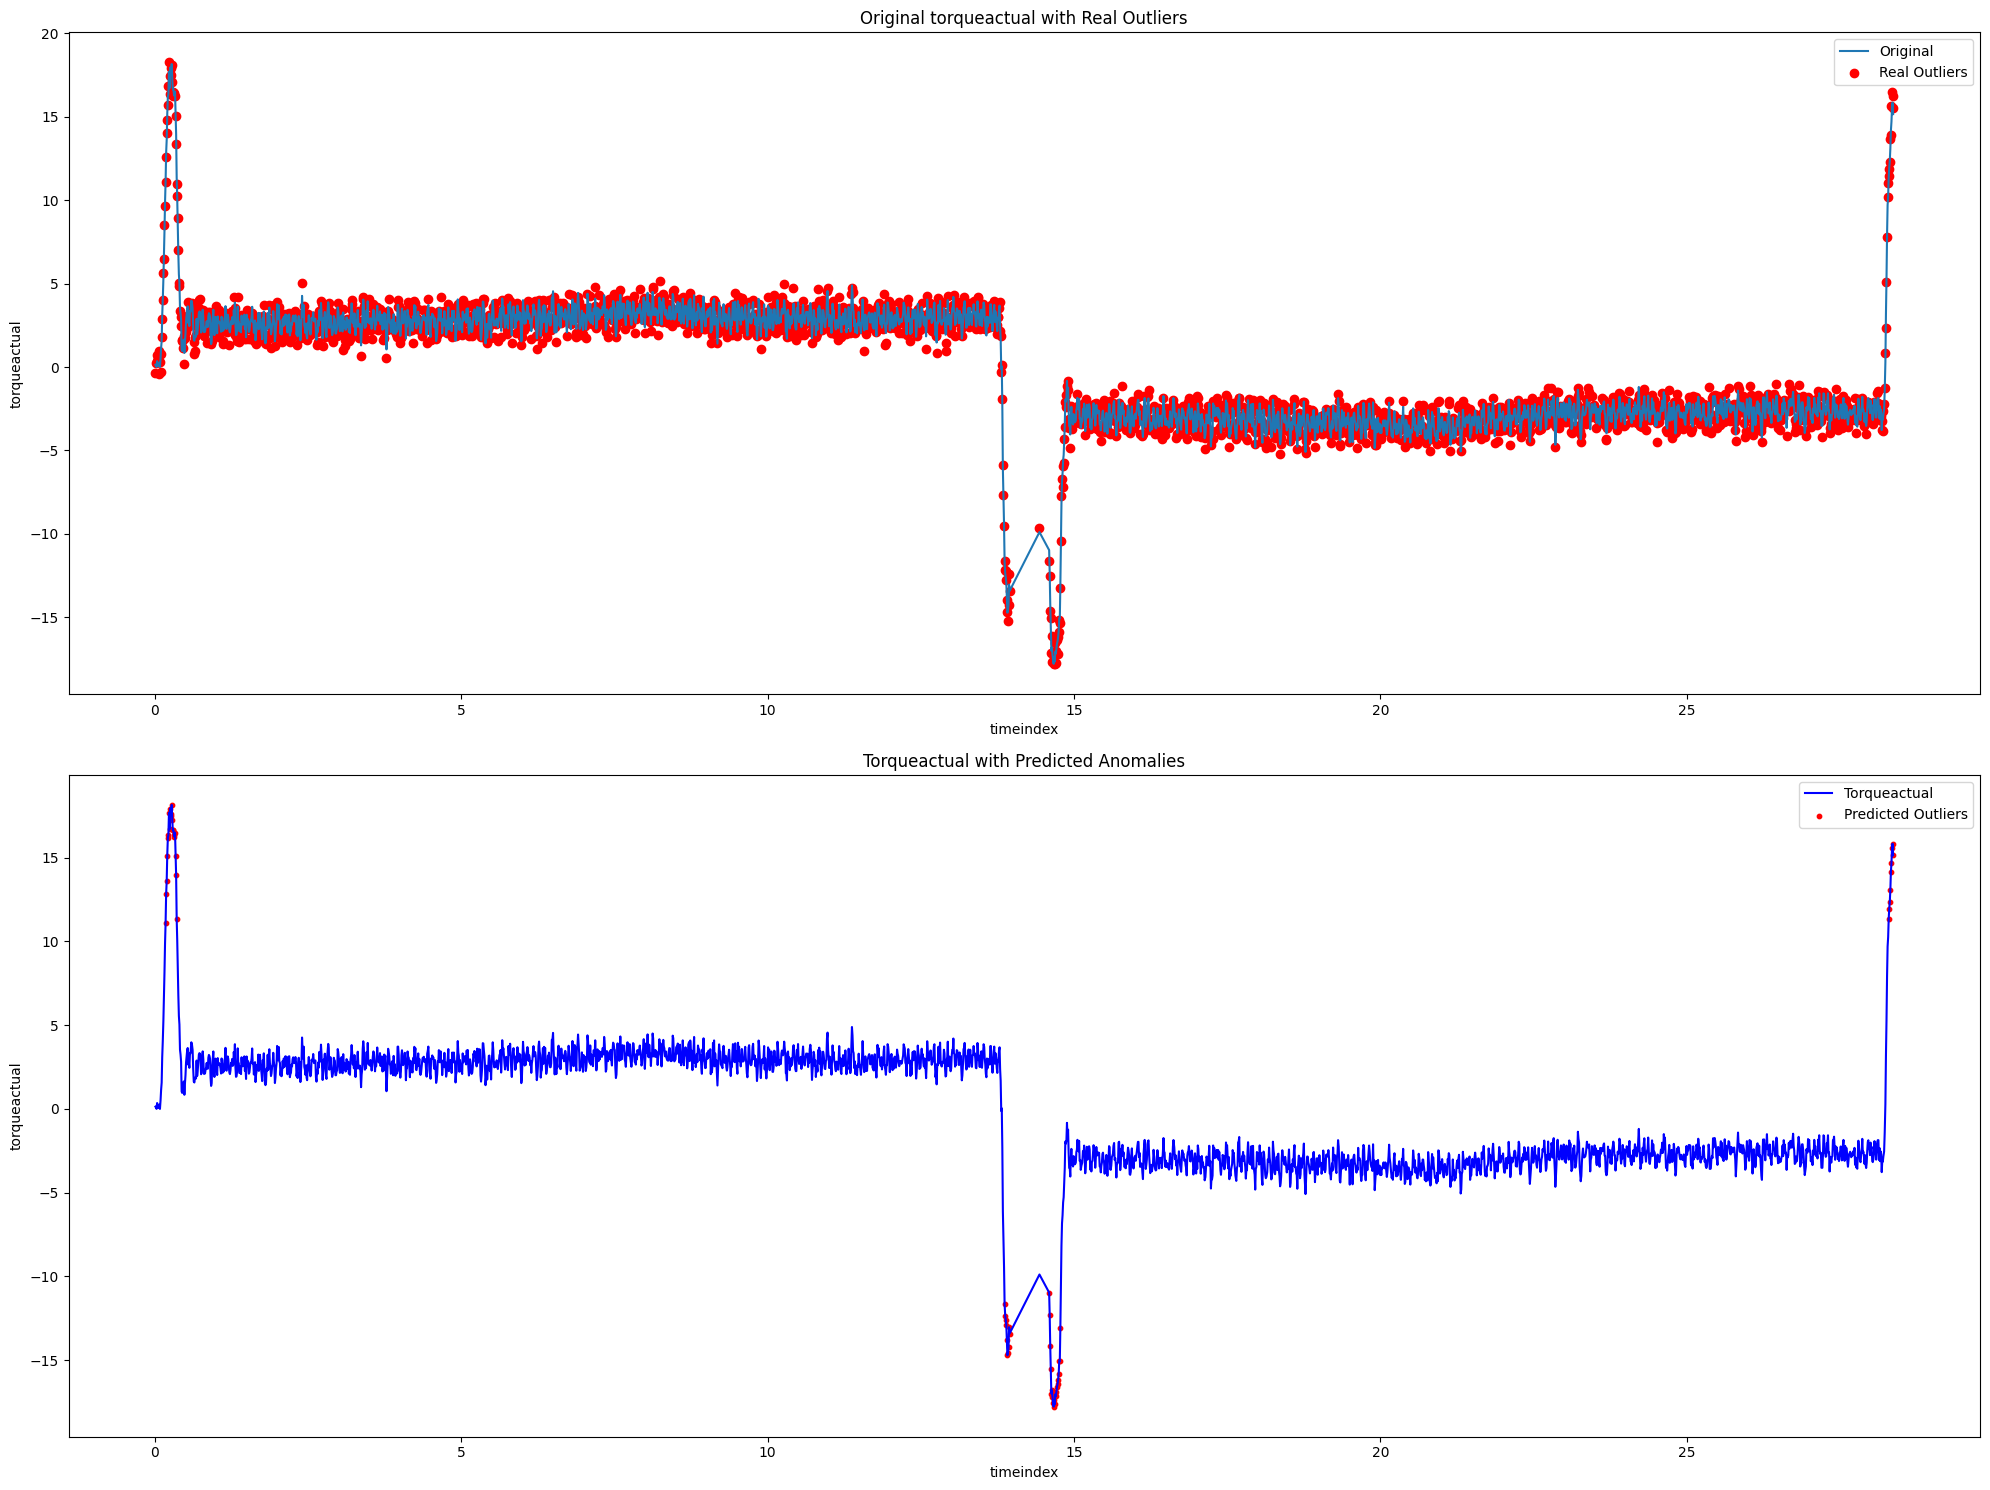

In [19]:
# Plotting torqueactual against timeindex
plt.figure(figsize=(20, 15))

# Plot original torqueactual with real anomalies
plt.subplot(2, 1, 1)
plt.plot(data_gauss['timeindex'], data_gauss['torqueactual'], label='Original')
plt.scatter(real_anomalies_gauss['timeindex'], real_anomalies_gauss['torqueactual'] + real_anomalies_gauss['noise'], 
            c='red', label='Real Outliers')
plt.xlabel('timeindex')
plt.ylabel('torqueactual')
plt.title('Original torqueactual with Real Outliers')
plt.legend()

# Separate inliers and outliers for plotting
outliers = data_gauss[data_gauss['outlier'] == -1]

# Highlighting detected anomalies in torqueactual
plt.subplot(2, 1, 2)
plt.plot(data_gauss['timeindex'], data_gauss['torqueactual'], label='Torqueactual', color='blue')
plt.scatter(outliers['timeindex'], outliers['torqueactual'], color='red', s=10, label='Predicted Outliers')
plt.title('Torqueactual with Predicted Anomalies')
plt.xlabel('timeindex')
plt.ylabel('torqueactual')
plt.legend()

plt.tight_layout()
plt.show()

# Shift Anomaly

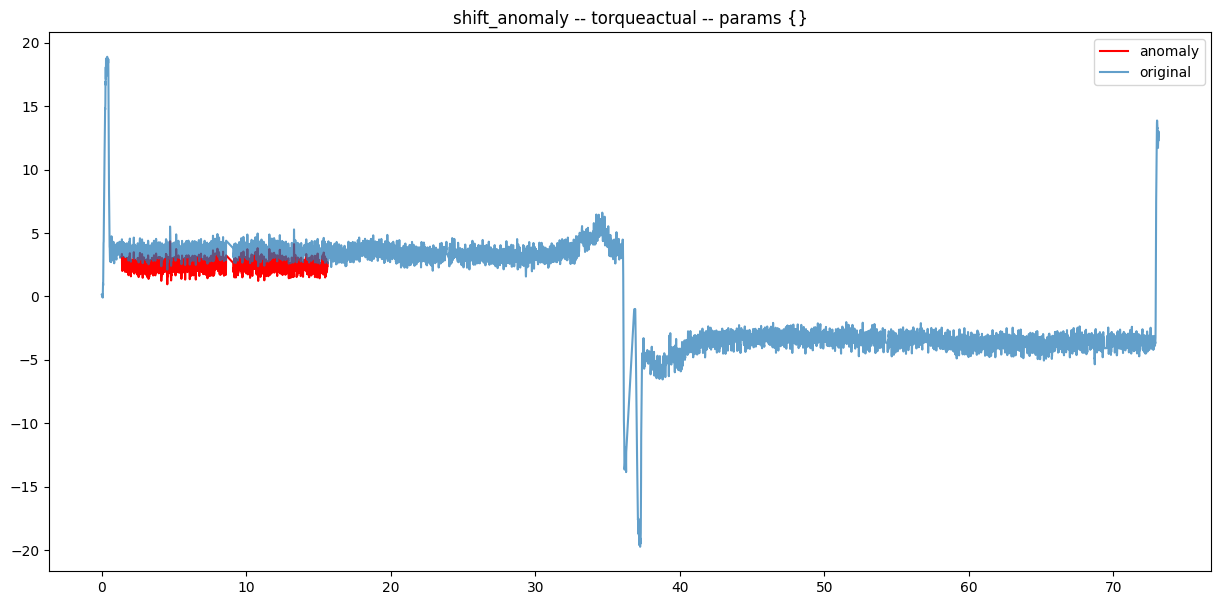

In [27]:
data_shift = get_rand_sequence()

start = 150
end = 1500
strength = 1.5

data_shift = NoiseMachine.shift_anomaly(
    data_shift,
    column="torqueactual",
    start=start,
    length=end,
    strength=strength,
)
NoiseMachine.plot(data_shift, column="torqueactual")

In [28]:
# Extract features for training
features_shift = data_shift[['torqueactual']].values

In [29]:
# Normalize the features
scaler = StandardScaler()
scaled_features = scaler.fit_transform(features_shift)

# Train Isolation Forest on the normalized features
iso_forest = IsolationForest(n_estimators=500, contamination=0.02, random_state=42)
iso_forest.fit(scaled_features)

IsolationForest(contamination=0.02, n_estimators=500, random_state=42)

In [30]:
data_shift['outlier'] = iso_forest.predict(scaled_features)

In [31]:
real_anomalies_shift = data_shift[data_shift['noise'] != 0]

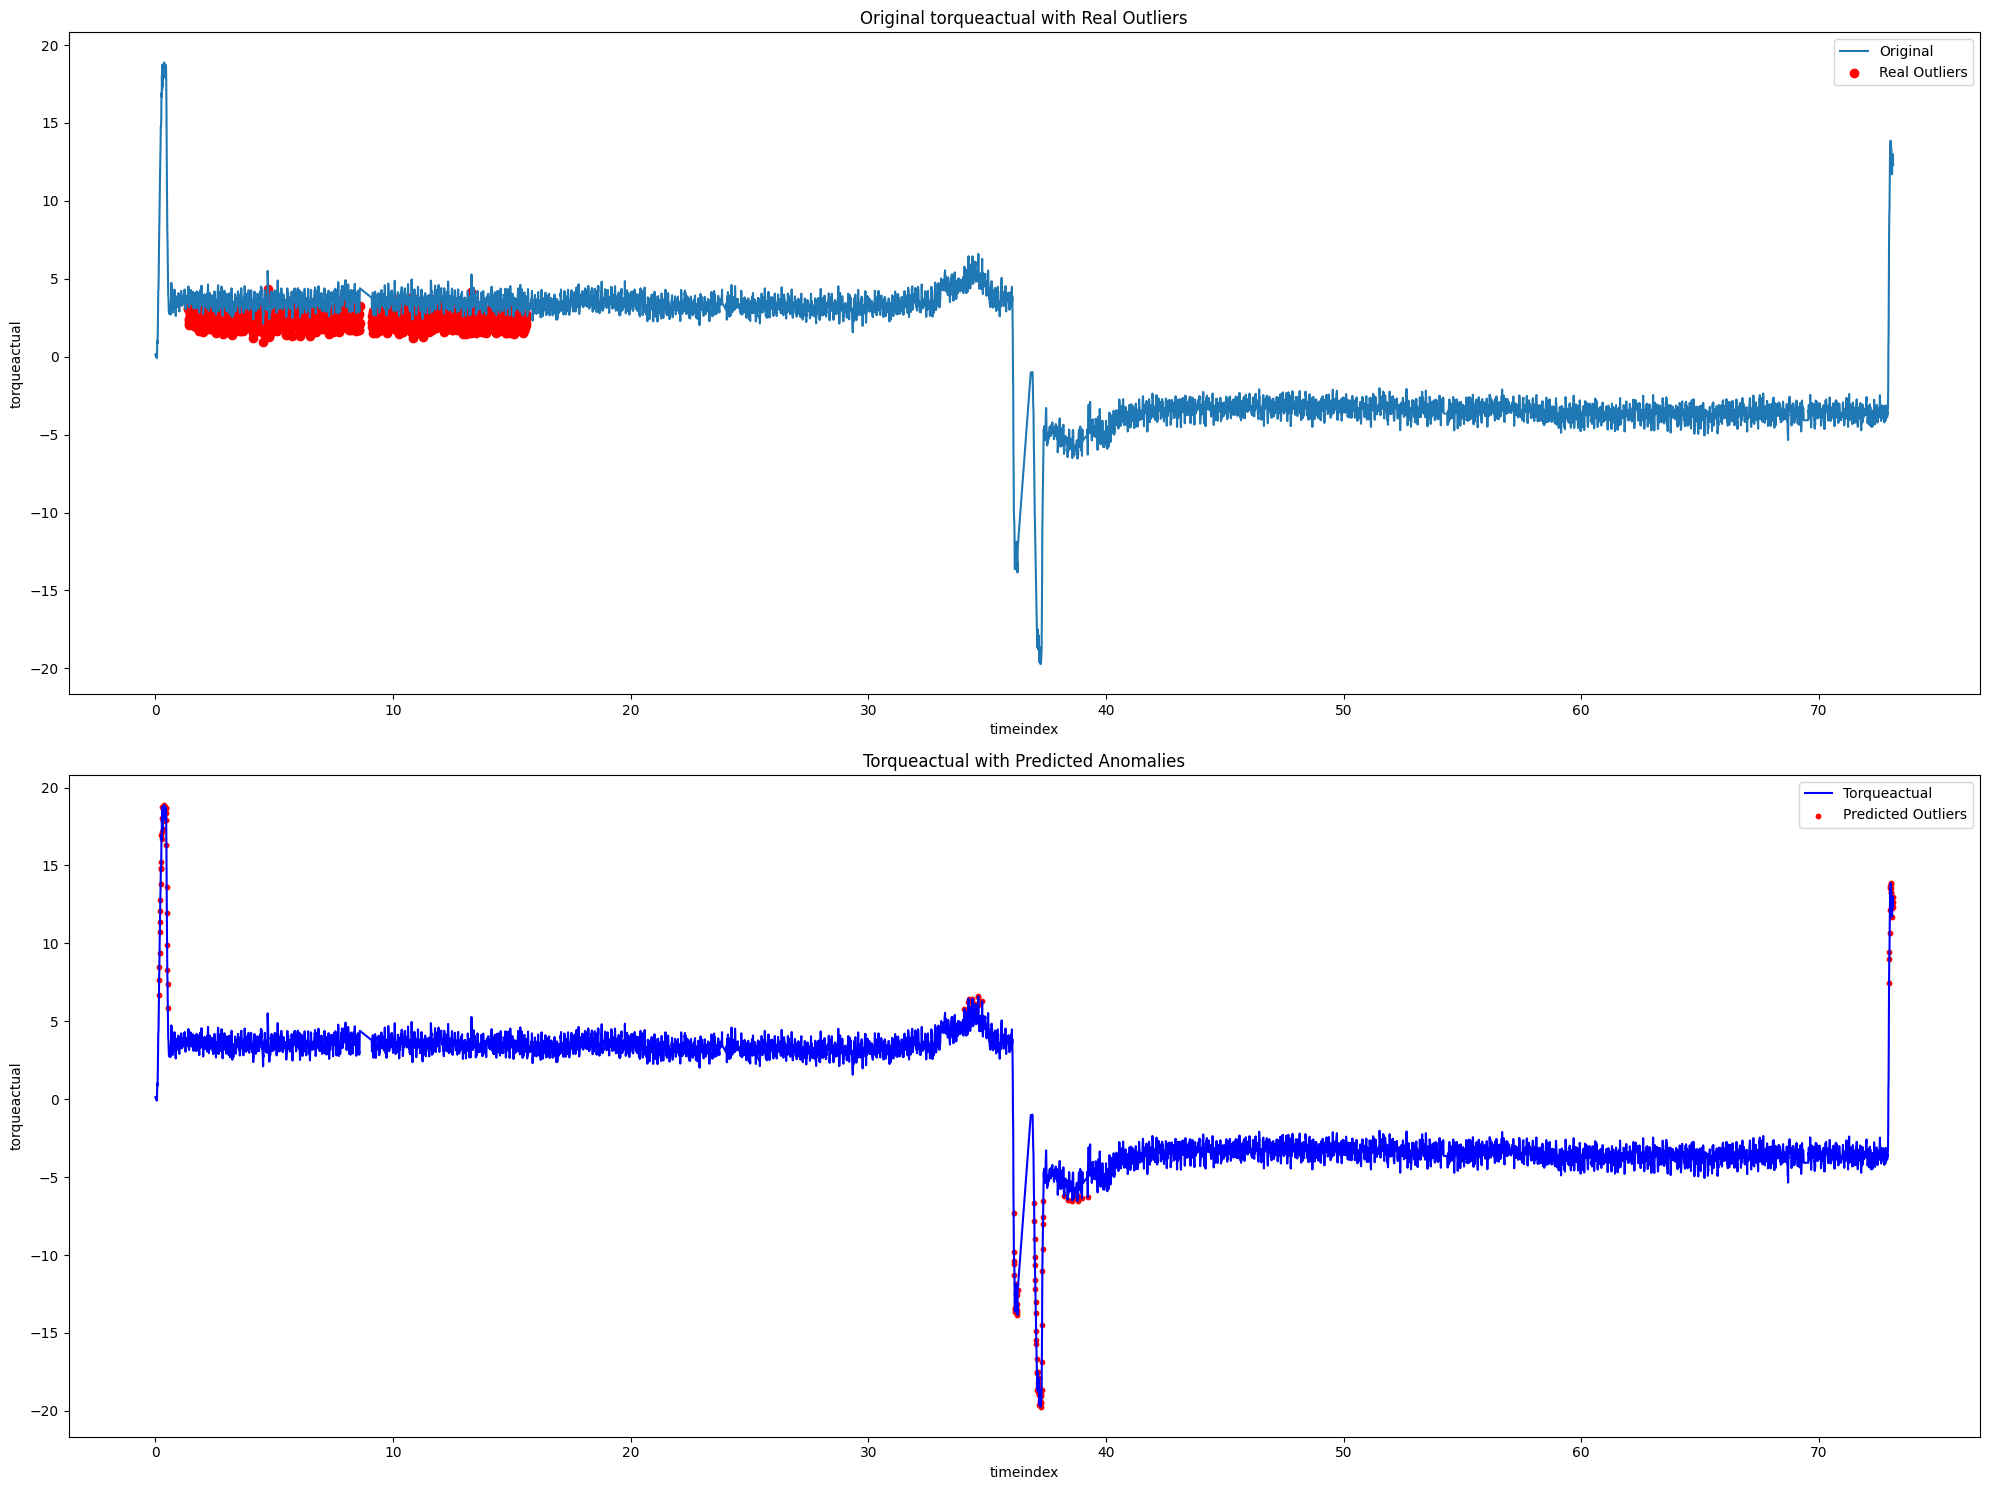

In [32]:
# Plotting torqueactual against timeindex
plt.figure(figsize=(20, 15))

# Plot original torqueactual with real anomalies
plt.subplot(2, 1, 1)
plt.plot(data_shift['timeindex'], data_shift['torqueactual'], label='Original')
plt.scatter(real_anomalies_shift['timeindex'], real_anomalies_shift['torqueactual'] + real_anomalies_shift['noise'], 
            c='red', label='Real Outliers')
plt.xlabel('timeindex')
plt.ylabel('torqueactual')
plt.title('Original torqueactual with Real Outliers')
plt.legend()

# Separate inliers and outliers for plotting
outliers = data_shift[data_shift['outlier'] == -1]

# Highlighting detected anomalies in torqueactual
plt.subplot(2, 1, 2)
plt.plot(data_shift['timeindex'], data_shift['torqueactual'], label='Torqueactual', color='blue')
plt.scatter(outliers['timeindex'], outliers['torqueactual'], color='red', s=10, label='Predicted Outliers')
plt.title('Torqueactual with Predicted Anomalies')
plt.xlabel('timeindex')
plt.ylabel('torqueactual')
plt.legend()

plt.tight_layout()
plt.show()

# Trend Anomaly

In [33]:
data["type"] = data["id"].apply(lambda x: x.split("-")[1].split("|")[0])
data["datetime"] = data["id"].apply(lambda x: x.split("|")[1].replace("_", " "))
data["datetime"] = pd.to_datetime(data["datetime"])

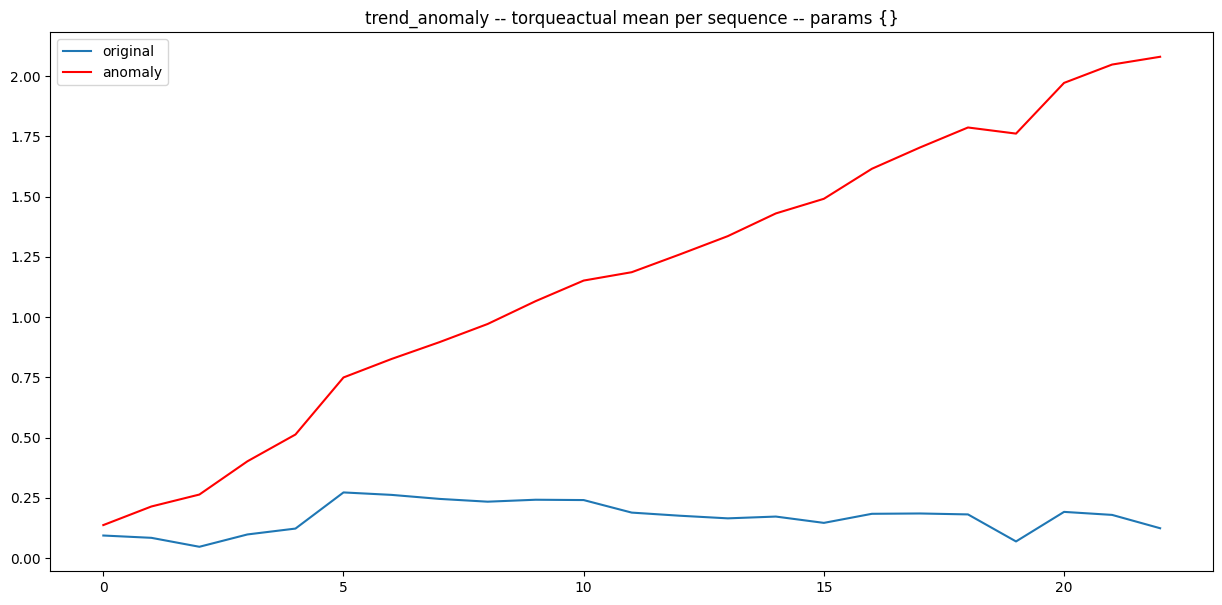

In [34]:
data_440 = data[data["type"] == "100440"]
data_440 = data_440.sort_values(by=["datetime", "timeindex"])
data_440 = data_440.reset_index(drop=True)

max_shift = 2

data_440 = NoiseMachine.trend_anomaly(data_440, max_shift=max_shift)
NoiseMachine.plot(data_440, column="torqueactual")

In [35]:
real_anomalies_trend = data_440[data_440['noise'] != 0]

In [36]:
# Extract features for training
features_trend = data_440[['torqueactual']].values

In [37]:
# Normalize the features
scaler = StandardScaler()
scaled_features = scaler.fit_transform(features_trend)

# Train Isolation Forest on the normalized features
iso_forest = IsolationForest(n_estimators=500, contamination=0.02, random_state=42)
iso_forest.fit(scaled_features)

IsolationForest(contamination=0.02, n_estimators=500, random_state=42)

In [38]:
data_440['outlier'] = iso_forest.predict(scaled_features)

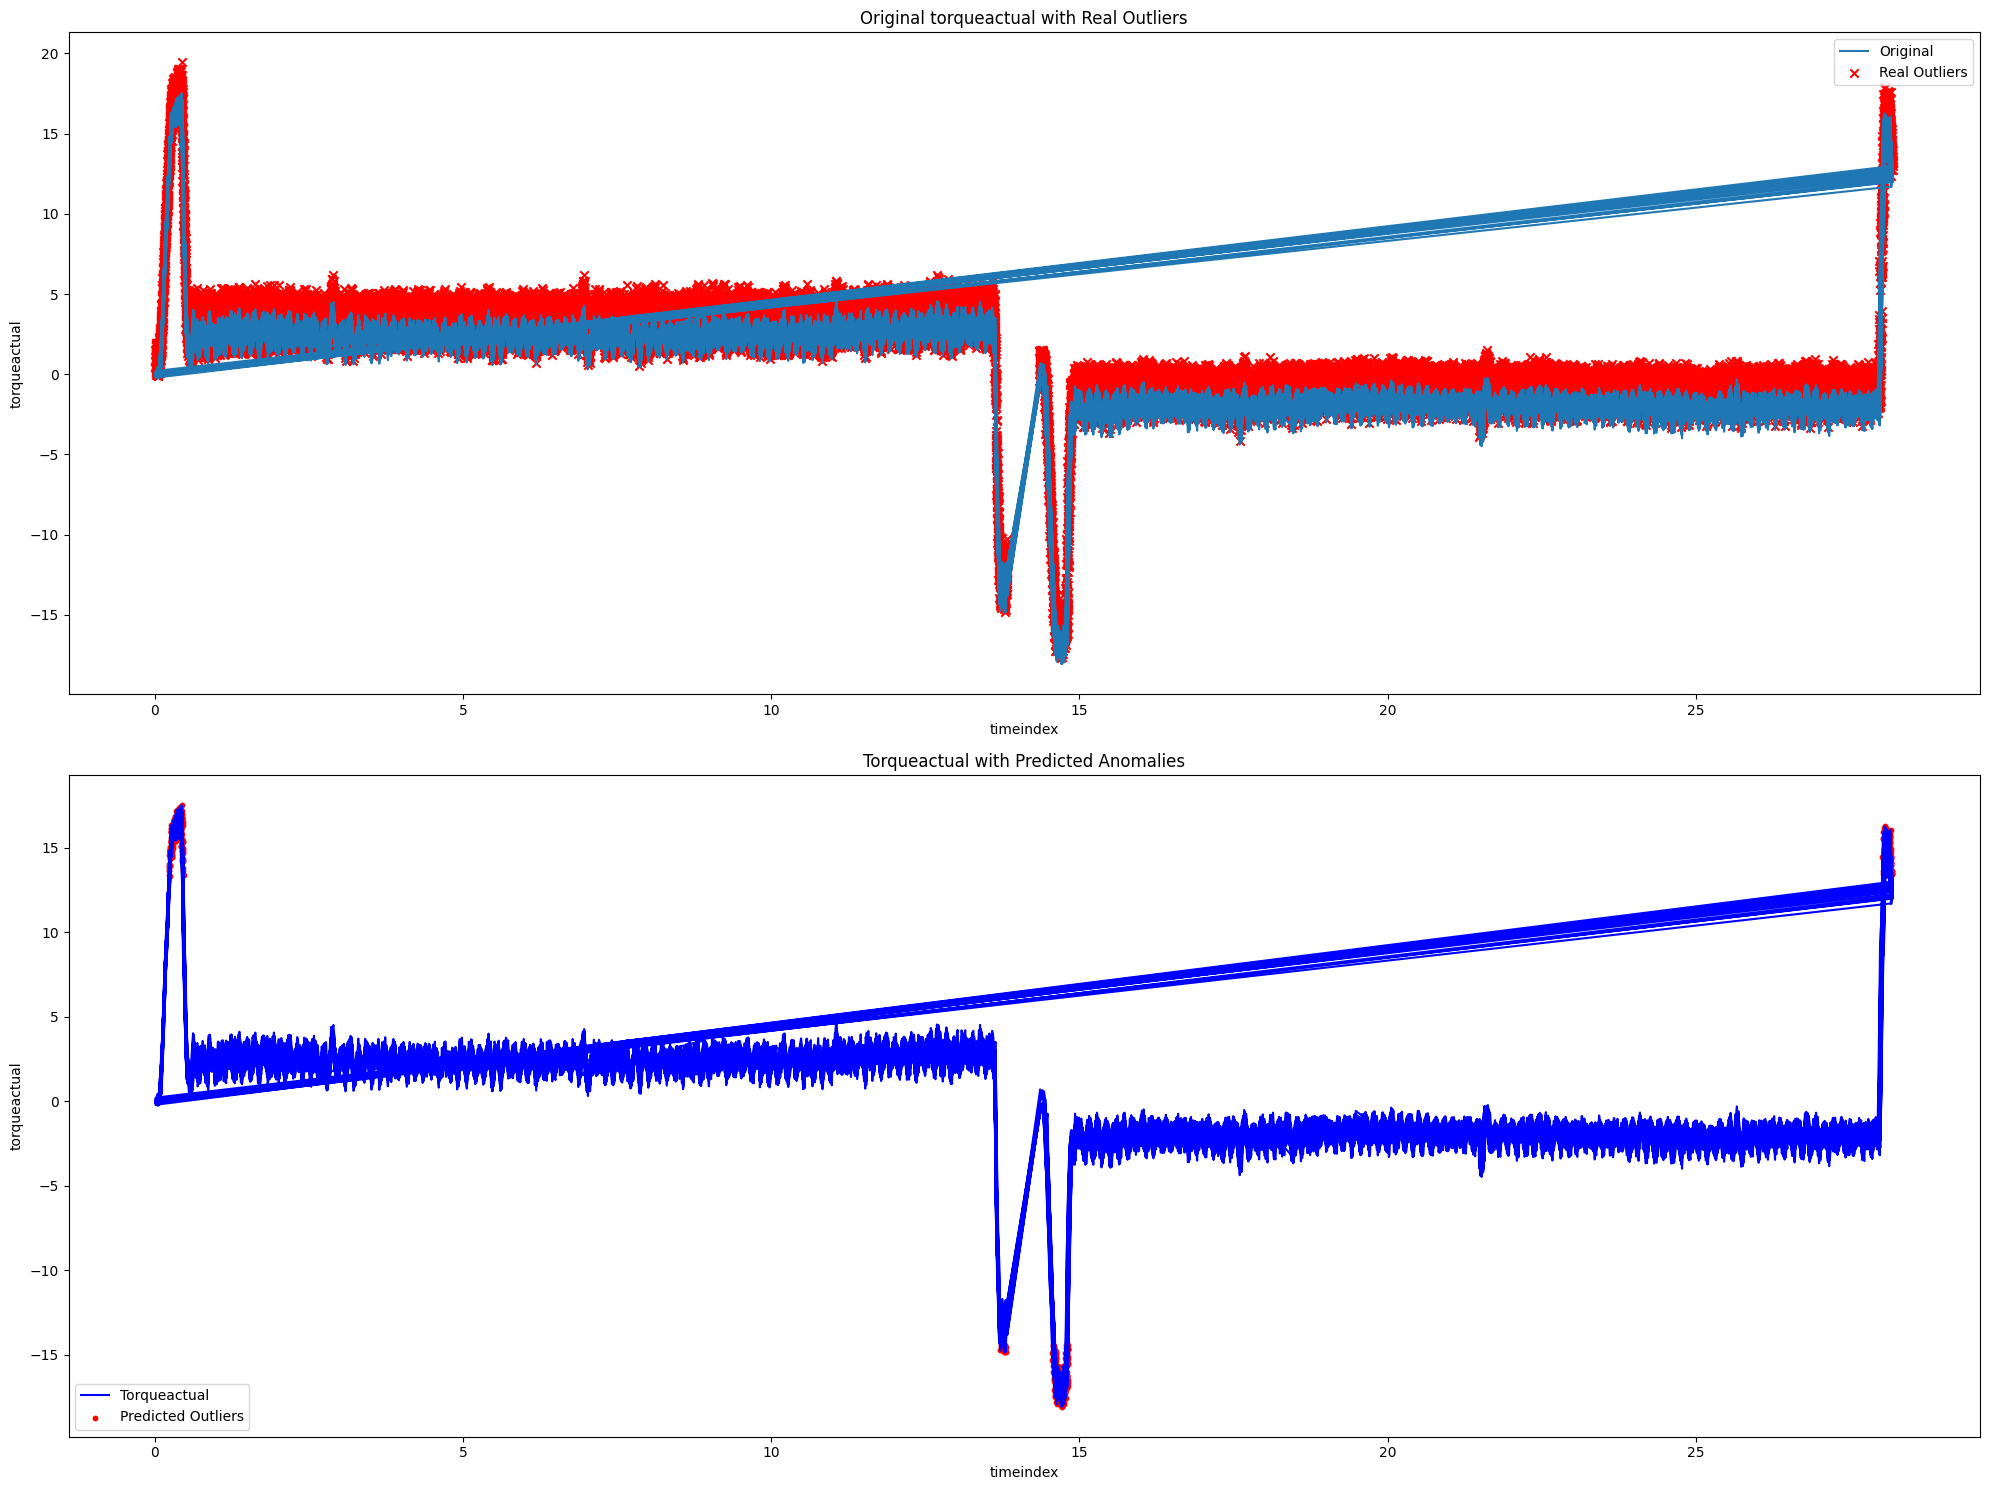

In [39]:
# Separate inliers and outliers for plotting
outliers = data_440[data_440['outlier'] == -1]

# Plotting torqueactual against timeindex
plt.figure(figsize=(20, 15))

# Plot original torqueactual with real anomalies
plt.subplot(2, 1, 1)
plt.plot(data_440['timeindex'], data_440['torqueactual'], label='Original')
plt.scatter(real_anomalies_trend['timeindex'], real_anomalies_trend['torqueactual'] + real_anomalies_trend['noise'], 
            c='red', label='Real Outliers', marker='x')
plt.xlabel('timeindex')
plt.ylabel('torqueactual')
plt.title('Original torqueactual with Real Outliers')
plt.legend()

# Highlighting detected anomalies in torqueactual
plt.subplot(2, 1, 2)
plt.plot(data_440['timeindex'], data_440['torqueactual'], label='Torqueactual', color='blue')
plt.scatter(outliers['timeindex'], outliers['torqueactual'], color='red', s=10, label='Predicted Outliers')
plt.title('Torqueactual with Predicted Anomalies')
plt.xlabel('timeindex')
plt.ylabel('torqueactual')
plt.legend()

plt.tight_layout()
plt.show()